# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

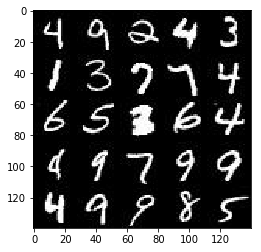

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

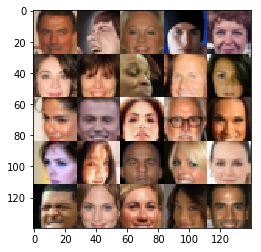

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf
import numpy as np

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, [None,image_width,image_height,image_channels], name='Real_Input')
    inputs_z = tf.placeholder(tf.float32, [None, z_dim], name='Z_Input')
    learning_rate = tf.placeholder(tf.float32, name='Learning_Rate')
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/home/paperspace/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/home/paperspace/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/home/paperspace/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/home/paperspace/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/home/paperspace/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/home/paperspace/anaconda3/lib/python3.6/sit

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    keep_prob = 0.5
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha=0.15
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)

        x3 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)

        
        flat = tf.reshape(relu3, (-1, 7*7*256))
        flat = tf.nn.dropout(flat, keep_prob)
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAoutT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse = not is_train):
        alpha=0.15  
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256 now

        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x128 now
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')

        # 28x28x5 now
        out = tf.tanh(logits)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    

    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    
    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()


### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    image_channels=1
    if data_image_mode =="RGB":
        image_channels = 3


    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], image_channels, 200)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)

   

    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))

    samples, losses = [], []
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps+=1
                # batch images
                batch_images = batch_images.reshape(batch_size, data_shape[1], data_shape[2], image_channels)
                batch_images = batch_images*2

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z,lr:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images,lr:learning_rate})

                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                if steps % 100 == 0:
                    show_generator_output(sess=sess, n_images=30, input_z=input_z, out_channel_dim=image_channels, image_mode=data_image_mode)


      # saver.save(sess, './checkpoints/generator.ckpt')

    #with open('samples.pkl', 'wb') as f:
     #   pkl.dump(samples, f)

    return losses, samples

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.1222... Generator Loss: 3.0906
Epoch 1/2... Discriminator Loss: 0.0222... Generator Loss: 5.1858
Epoch 1/2... Discriminator Loss: 0.0117... Generator Loss: 5.2396
Epoch 1/2... Discriminator Loss: 0.0820... Generator Loss: 3.3636
Epoch 1/2... Discriminator Loss: 0.0504... Generator Loss: 4.5476
Epoch 1/2... Discriminator Loss: 0.0386... Generator Loss: 4.5573
Epoch 1/2... Discriminator Loss: 0.0060... Generator Loss: 5.5678
Epoch 1/2... Discriminator Loss: 0.2606... Generator Loss: 2.3065
Epoch 1/2... Discriminator Loss: 2.6003... Generator Loss: 0.4251
Epoch 1/2... Discriminator Loss: 2.7274... Generator Loss: 0.1897


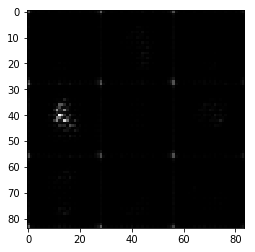

Epoch 1/2... Discriminator Loss: 2.7507... Generator Loss: 0.3926
Epoch 1/2... Discriminator Loss: 2.3608... Generator Loss: 0.4293
Epoch 1/2... Discriminator Loss: 1.3062... Generator Loss: 1.1801
Epoch 1/2... Discriminator Loss: 3.2072... Generator Loss: 0.1502
Epoch 1/2... Discriminator Loss: 1.6752... Generator Loss: 0.5966
Epoch 1/2... Discriminator Loss: 2.0462... Generator Loss: 0.2473
Epoch 1/2... Discriminator Loss: 1.6125... Generator Loss: 0.7847
Epoch 1/2... Discriminator Loss: 1.5153... Generator Loss: 0.5130
Epoch 1/2... Discriminator Loss: 2.8280... Generator Loss: 0.2945
Epoch 1/2... Discriminator Loss: 1.9440... Generator Loss: 0.1273


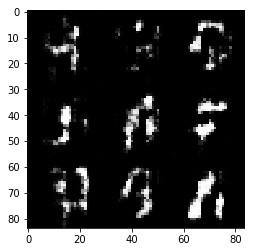

Epoch 1/2... Discriminator Loss: 2.1909... Generator Loss: 0.4823
Epoch 1/2... Discriminator Loss: 2.3760... Generator Loss: 0.2444
Epoch 1/2... Discriminator Loss: 1.9237... Generator Loss: 0.9305
Epoch 1/2... Discriminator Loss: 1.8618... Generator Loss: 0.5068
Epoch 1/2... Discriminator Loss: 1.5443... Generator Loss: 0.7435
Epoch 1/2... Discriminator Loss: 1.8798... Generator Loss: 0.2694
Epoch 1/2... Discriminator Loss: 2.0133... Generator Loss: 0.2340
Epoch 1/2... Discriminator Loss: 2.1651... Generator Loss: 0.3392
Epoch 1/2... Discriminator Loss: 2.3156... Generator Loss: 0.4865
Epoch 1/2... Discriminator Loss: 2.2964... Generator Loss: 0.2255


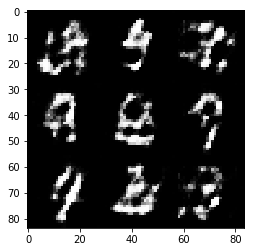

Epoch 1/2... Discriminator Loss: 1.5123... Generator Loss: 0.7602
Epoch 1/2... Discriminator Loss: 1.4106... Generator Loss: 0.4584
Epoch 1/2... Discriminator Loss: 1.9574... Generator Loss: 0.5426
Epoch 1/2... Discriminator Loss: 1.7184... Generator Loss: 1.0236
Epoch 1/2... Discriminator Loss: 1.7564... Generator Loss: 1.2638
Epoch 1/2... Discriminator Loss: 1.7152... Generator Loss: 0.4461
Epoch 1/2... Discriminator Loss: 1.7497... Generator Loss: 0.8893
Epoch 1/2... Discriminator Loss: 1.3564... Generator Loss: 0.4331
Epoch 1/2... Discriminator Loss: 2.3187... Generator Loss: 0.2790
Epoch 1/2... Discriminator Loss: 1.7480... Generator Loss: 0.3404


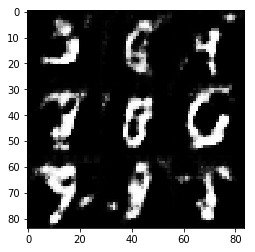

Epoch 1/2... Discriminator Loss: 1.6833... Generator Loss: 0.3835
Epoch 1/2... Discriminator Loss: 1.6079... Generator Loss: 0.4137
Epoch 1/2... Discriminator Loss: 1.4508... Generator Loss: 1.5897
Epoch 1/2... Discriminator Loss: 1.5357... Generator Loss: 0.4683
Epoch 1/2... Discriminator Loss: 1.6597... Generator Loss: 1.7705
Epoch 1/2... Discriminator Loss: 1.2788... Generator Loss: 1.1255
Epoch 1/2... Discriminator Loss: 2.2906... Generator Loss: 0.3550
Epoch 1/2... Discriminator Loss: 1.7830... Generator Loss: 0.3833
Epoch 1/2... Discriminator Loss: 1.4311... Generator Loss: 0.4033
Epoch 1/2... Discriminator Loss: 1.0634... Generator Loss: 0.3815


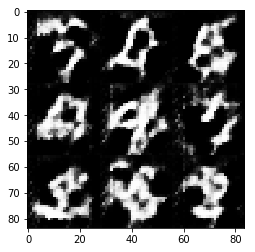

Epoch 1/2... Discriminator Loss: 2.1576... Generator Loss: 0.5405
Epoch 1/2... Discriminator Loss: 2.0439... Generator Loss: 0.3448
Epoch 1/2... Discriminator Loss: 1.3412... Generator Loss: 0.9410
Epoch 1/2... Discriminator Loss: 1.7084... Generator Loss: 0.4412
Epoch 1/2... Discriminator Loss: 1.9174... Generator Loss: 0.6769
Epoch 1/2... Discriminator Loss: 1.3675... Generator Loss: 1.1123
Epoch 1/2... Discriminator Loss: 1.4956... Generator Loss: 0.5810
Epoch 1/2... Discriminator Loss: 1.9100... Generator Loss: 0.4591
Epoch 1/2... Discriminator Loss: 1.7728... Generator Loss: 1.3027
Epoch 1/2... Discriminator Loss: 2.5426... Generator Loss: 0.3416


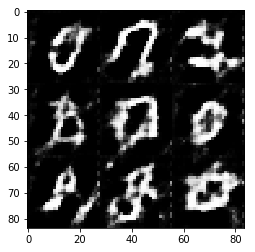

Epoch 1/2... Discriminator Loss: 1.7615... Generator Loss: 0.6704
Epoch 1/2... Discriminator Loss: 2.0470... Generator Loss: 0.7882
Epoch 1/2... Discriminator Loss: 1.5974... Generator Loss: 0.5371
Epoch 1/2... Discriminator Loss: 2.0845... Generator Loss: 0.5263
Epoch 1/2... Discriminator Loss: 1.1508... Generator Loss: 0.6583
Epoch 1/2... Discriminator Loss: 1.3656... Generator Loss: 1.6006
Epoch 1/2... Discriminator Loss: 1.8306... Generator Loss: 0.2497
Epoch 1/2... Discriminator Loss: 1.8483... Generator Loss: 1.2113
Epoch 1/2... Discriminator Loss: 1.6374... Generator Loss: 0.4549
Epoch 1/2... Discriminator Loss: 1.9737... Generator Loss: 0.6189


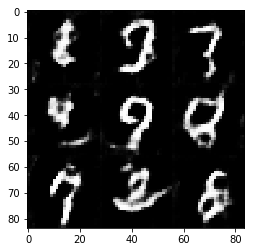

Epoch 1/2... Discriminator Loss: 1.4521... Generator Loss: 0.8726
Epoch 1/2... Discriminator Loss: 2.0409... Generator Loss: 0.4269
Epoch 1/2... Discriminator Loss: 1.3717... Generator Loss: 0.3001
Epoch 1/2... Discriminator Loss: 1.2681... Generator Loss: 1.6651
Epoch 1/2... Discriminator Loss: 2.2207... Generator Loss: 0.2144
Epoch 1/2... Discriminator Loss: 1.4356... Generator Loss: 0.7934
Epoch 1/2... Discriminator Loss: 1.3713... Generator Loss: 1.2424
Epoch 1/2... Discriminator Loss: 1.9437... Generator Loss: 0.5913
Epoch 1/2... Discriminator Loss: 1.9642... Generator Loss: 0.3870
Epoch 1/2... Discriminator Loss: 2.2054... Generator Loss: 0.4483


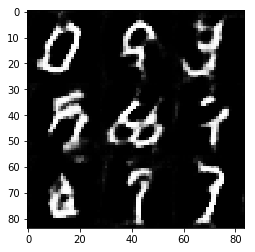

Epoch 1/2... Discriminator Loss: 1.7783... Generator Loss: 0.5773
Epoch 1/2... Discriminator Loss: 1.2623... Generator Loss: 1.0235
Epoch 1/2... Discriminator Loss: 2.4015... Generator Loss: 0.3020
Epoch 1/2... Discriminator Loss: 1.8206... Generator Loss: 1.4036
Epoch 1/2... Discriminator Loss: 2.1196... Generator Loss: 0.3345
Epoch 1/2... Discriminator Loss: 1.4265... Generator Loss: 1.1632
Epoch 1/2... Discriminator Loss: 1.6751... Generator Loss: 0.8643
Epoch 1/2... Discriminator Loss: 2.0352... Generator Loss: 1.0858
Epoch 1/2... Discriminator Loss: 1.7475... Generator Loss: 0.4933
Epoch 1/2... Discriminator Loss: 1.7635... Generator Loss: 0.6522


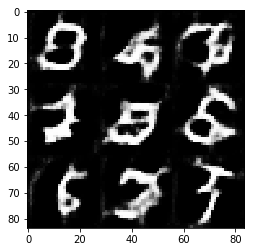

Epoch 1/2... Discriminator Loss: 1.9606... Generator Loss: 0.5261
Epoch 1/2... Discriminator Loss: 1.4393... Generator Loss: 0.3791
Epoch 1/2... Discriminator Loss: 1.4912... Generator Loss: 1.2660
Epoch 1/2... Discriminator Loss: 1.2259... Generator Loss: 0.8225
Epoch 1/2... Discriminator Loss: 1.8557... Generator Loss: 0.2465
Epoch 1/2... Discriminator Loss: 1.2358... Generator Loss: 0.5348
Epoch 1/2... Discriminator Loss: 2.1348... Generator Loss: 0.9605
Epoch 1/2... Discriminator Loss: 1.5644... Generator Loss: 0.6882
Epoch 1/2... Discriminator Loss: 1.1562... Generator Loss: 0.8958
Epoch 1/2... Discriminator Loss: 1.6417... Generator Loss: 1.5310


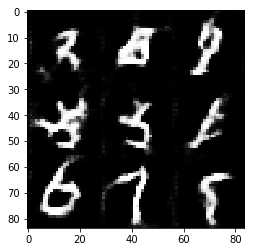

Epoch 1/2... Discriminator Loss: 1.3731... Generator Loss: 0.6174
Epoch 1/2... Discriminator Loss: 2.0482... Generator Loss: 0.6197
Epoch 1/2... Discriminator Loss: 1.2597... Generator Loss: 1.6286
Epoch 1/2... Discriminator Loss: 1.6657... Generator Loss: 0.2959
Epoch 1/2... Discriminator Loss: 0.9435... Generator Loss: 0.9020
Epoch 1/2... Discriminator Loss: 1.3858... Generator Loss: 1.1336
Epoch 1/2... Discriminator Loss: 1.3397... Generator Loss: 0.8218
Epoch 1/2... Discriminator Loss: 1.6094... Generator Loss: 0.5700
Epoch 1/2... Discriminator Loss: 1.8578... Generator Loss: 0.3721
Epoch 1/2... Discriminator Loss: 1.3786... Generator Loss: 0.9794


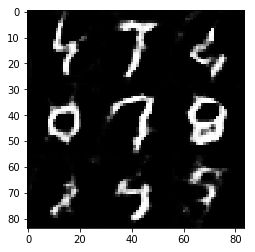

Epoch 1/2... Discriminator Loss: 1.6451... Generator Loss: 0.7157
Epoch 1/2... Discriminator Loss: 2.1416... Generator Loss: 0.3406
Epoch 1/2... Discriminator Loss: 1.4197... Generator Loss: 0.4405
Epoch 1/2... Discriminator Loss: 1.1910... Generator Loss: 1.6348
Epoch 1/2... Discriminator Loss: 1.4864... Generator Loss: 0.5661
Epoch 1/2... Discriminator Loss: 2.1111... Generator Loss: 0.3878
Epoch 1/2... Discriminator Loss: 0.8208... Generator Loss: 1.0480
Epoch 1/2... Discriminator Loss: 1.4057... Generator Loss: 0.3703
Epoch 1/2... Discriminator Loss: 2.0510... Generator Loss: 0.5480
Epoch 1/2... Discriminator Loss: 2.0224... Generator Loss: 0.3965


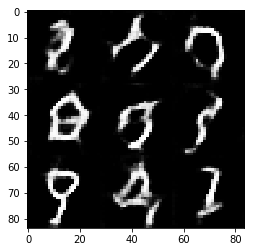

Epoch 1/2... Discriminator Loss: 1.7514... Generator Loss: 0.3612
Epoch 1/2... Discriminator Loss: 2.1796... Generator Loss: 0.3667
Epoch 1/2... Discriminator Loss: 1.6573... Generator Loss: 0.2518
Epoch 1/2... Discriminator Loss: 2.3629... Generator Loss: 0.2326
Epoch 1/2... Discriminator Loss: 1.5829... Generator Loss: 0.3567
Epoch 1/2... Discriminator Loss: 1.2971... Generator Loss: 0.7629
Epoch 1/2... Discriminator Loss: 1.7504... Generator Loss: 1.1456
Epoch 1/2... Discriminator Loss: 1.0932... Generator Loss: 1.1285
Epoch 1/2... Discriminator Loss: 1.3688... Generator Loss: 0.5315
Epoch 1/2... Discriminator Loss: 1.8756... Generator Loss: 0.3740


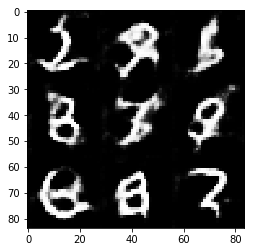

Epoch 1/2... Discriminator Loss: 2.0972... Generator Loss: 0.5340
Epoch 1/2... Discriminator Loss: 1.1728... Generator Loss: 1.1620
Epoch 1/2... Discriminator Loss: 1.7984... Generator Loss: 0.4767
Epoch 1/2... Discriminator Loss: 1.5062... Generator Loss: 1.0295
Epoch 1/2... Discriminator Loss: 1.7368... Generator Loss: 0.5314
Epoch 1/2... Discriminator Loss: 1.2183... Generator Loss: 1.2156
Epoch 1/2... Discriminator Loss: 1.8789... Generator Loss: 0.8750
Epoch 1/2... Discriminator Loss: 1.2514... Generator Loss: 0.8058
Epoch 1/2... Discriminator Loss: 1.3870... Generator Loss: 0.9355
Epoch 1/2... Discriminator Loss: 1.6785... Generator Loss: 1.1969


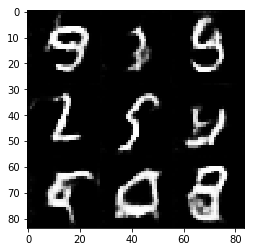

Epoch 1/2... Discriminator Loss: 1.7879... Generator Loss: 0.9494
Epoch 1/2... Discriminator Loss: 1.6630... Generator Loss: 0.6195
Epoch 1/2... Discriminator Loss: 1.6865... Generator Loss: 0.6306
Epoch 1/2... Discriminator Loss: 1.9554... Generator Loss: 0.2558
Epoch 1/2... Discriminator Loss: 1.5639... Generator Loss: 0.6018
Epoch 1/2... Discriminator Loss: 1.2071... Generator Loss: 0.9299
Epoch 1/2... Discriminator Loss: 1.6984... Generator Loss: 0.4227
Epoch 1/2... Discriminator Loss: 1.3422... Generator Loss: 0.6489
Epoch 1/2... Discriminator Loss: 1.7022... Generator Loss: 0.4909
Epoch 1/2... Discriminator Loss: 1.2362... Generator Loss: 0.7093


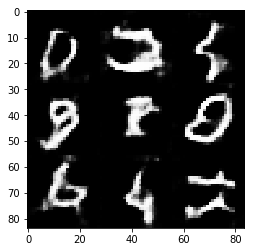

Epoch 1/2... Discriminator Loss: 1.8158... Generator Loss: 0.5935
Epoch 1/2... Discriminator Loss: 1.4695... Generator Loss: 0.7582
Epoch 1/2... Discriminator Loss: 1.4696... Generator Loss: 0.4724
Epoch 1/2... Discriminator Loss: 1.8574... Generator Loss: 0.6153
Epoch 1/2... Discriminator Loss: 1.9965... Generator Loss: 0.6189
Epoch 1/2... Discriminator Loss: 1.6323... Generator Loss: 1.5105
Epoch 1/2... Discriminator Loss: 1.6668... Generator Loss: 0.8119
Epoch 1/2... Discriminator Loss: 1.7841... Generator Loss: 0.7918
Epoch 1/2... Discriminator Loss: 1.2210... Generator Loss: 1.4781
Epoch 1/2... Discriminator Loss: 1.7180... Generator Loss: 0.3208


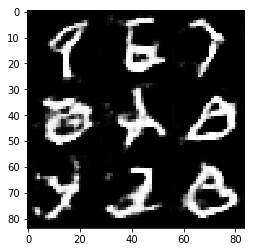

Epoch 1/2... Discriminator Loss: 1.2156... Generator Loss: 0.5011
Epoch 1/2... Discriminator Loss: 1.5506... Generator Loss: 0.7103
Epoch 1/2... Discriminator Loss: 1.1582... Generator Loss: 1.2015
Epoch 1/2... Discriminator Loss: 1.6564... Generator Loss: 0.5667
Epoch 1/2... Discriminator Loss: 1.3475... Generator Loss: 0.5490
Epoch 1/2... Discriminator Loss: 2.3302... Generator Loss: 0.2063
Epoch 1/2... Discriminator Loss: 1.6096... Generator Loss: 0.5926
Epoch 1/2... Discriminator Loss: 1.7011... Generator Loss: 0.6767
Epoch 1/2... Discriminator Loss: 1.9616... Generator Loss: 0.7782
Epoch 1/2... Discriminator Loss: 1.2229... Generator Loss: 0.6452


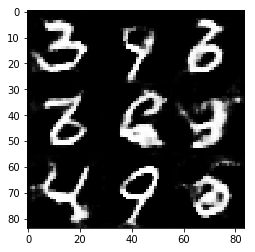

Epoch 1/2... Discriminator Loss: 1.4482... Generator Loss: 0.8873
Epoch 1/2... Discriminator Loss: 1.9552... Generator Loss: 0.3486
Epoch 1/2... Discriminator Loss: 1.4076... Generator Loss: 0.4750
Epoch 1/2... Discriminator Loss: 1.2997... Generator Loss: 0.5471
Epoch 1/2... Discriminator Loss: 1.6196... Generator Loss: 0.5060
Epoch 1/2... Discriminator Loss: 1.0082... Generator Loss: 0.7170
Epoch 1/2... Discriminator Loss: 1.3127... Generator Loss: 1.5487
Epoch 1/2... Discriminator Loss: 2.1293... Generator Loss: 1.6852
Epoch 1/2... Discriminator Loss: 1.2695... Generator Loss: 0.7172
Epoch 1/2... Discriminator Loss: 2.0501... Generator Loss: 0.5500


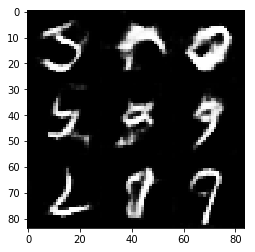

Epoch 1/2... Discriminator Loss: 1.0872... Generator Loss: 1.2303
Epoch 1/2... Discriminator Loss: 1.2127... Generator Loss: 1.1346
Epoch 1/2... Discriminator Loss: 1.6203... Generator Loss: 0.2684
Epoch 1/2... Discriminator Loss: 1.3501... Generator Loss: 0.6038
Epoch 1/2... Discriminator Loss: 1.4686... Generator Loss: 1.4547
Epoch 1/2... Discriminator Loss: 1.5615... Generator Loss: 0.2837
Epoch 1/2... Discriminator Loss: 1.4873... Generator Loss: 1.1074
Epoch 1/2... Discriminator Loss: 1.2892... Generator Loss: 0.8787
Epoch 1/2... Discriminator Loss: 1.5422... Generator Loss: 0.6185
Epoch 1/2... Discriminator Loss: 1.0075... Generator Loss: 1.0884


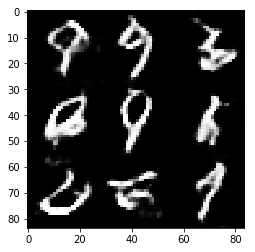

Epoch 1/2... Discriminator Loss: 1.3031... Generator Loss: 0.5505
Epoch 1/2... Discriminator Loss: 1.3105... Generator Loss: 0.8847
Epoch 1/2... Discriminator Loss: 1.4120... Generator Loss: 0.6867
Epoch 1/2... Discriminator Loss: 1.5252... Generator Loss: 0.3012
Epoch 1/2... Discriminator Loss: 1.7537... Generator Loss: 0.4567
Epoch 1/2... Discriminator Loss: 1.3962... Generator Loss: 0.5522
Epoch 1/2... Discriminator Loss: 1.8405... Generator Loss: 0.3071
Epoch 1/2... Discriminator Loss: 1.6983... Generator Loss: 0.8207
Epoch 1/2... Discriminator Loss: 1.8285... Generator Loss: 0.7114
Epoch 1/2... Discriminator Loss: 0.8725... Generator Loss: 1.0187


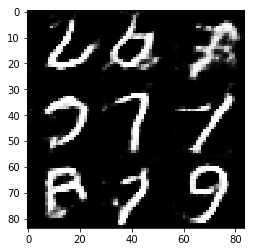

Epoch 1/2... Discriminator Loss: 1.3836... Generator Loss: 0.3797
Epoch 1/2... Discriminator Loss: 1.5766... Generator Loss: 0.8313
Epoch 1/2... Discriminator Loss: 1.8001... Generator Loss: 0.8209
Epoch 1/2... Discriminator Loss: 1.5043... Generator Loss: 1.0962
Epoch 1/2... Discriminator Loss: 2.0950... Generator Loss: 0.3982
Epoch 1/2... Discriminator Loss: 1.4154... Generator Loss: 0.3004
Epoch 1/2... Discriminator Loss: 2.1171... Generator Loss: 0.9917
Epoch 1/2... Discriminator Loss: 1.6933... Generator Loss: 0.8348
Epoch 1/2... Discriminator Loss: 1.8556... Generator Loss: 0.2829
Epoch 1/2... Discriminator Loss: 1.5999... Generator Loss: 0.4378


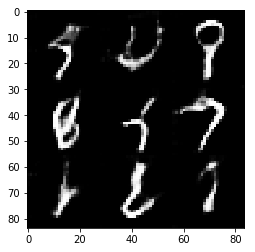

Epoch 1/2... Discriminator Loss: 1.2185... Generator Loss: 0.7819
Epoch 1/2... Discriminator Loss: 1.6605... Generator Loss: 0.9665
Epoch 1/2... Discriminator Loss: 1.6006... Generator Loss: 0.5821
Epoch 1/2... Discriminator Loss: 0.9814... Generator Loss: 0.4795
Epoch 1/2... Discriminator Loss: 2.0131... Generator Loss: 0.2375
Epoch 1/2... Discriminator Loss: 1.6875... Generator Loss: 0.9935
Epoch 1/2... Discriminator Loss: 2.0952... Generator Loss: 0.5044
Epoch 1/2... Discriminator Loss: 1.6285... Generator Loss: 1.1075
Epoch 1/2... Discriminator Loss: 1.5817... Generator Loss: 0.6654
Epoch 1/2... Discriminator Loss: 1.7663... Generator Loss: 0.4550


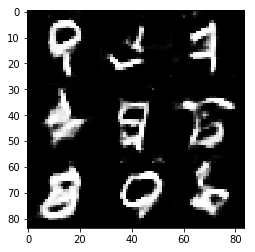

Epoch 1/2... Discriminator Loss: 1.8390... Generator Loss: 0.9934
Epoch 1/2... Discriminator Loss: 1.5477... Generator Loss: 0.7470
Epoch 1/2... Discriminator Loss: 1.2050... Generator Loss: 1.2157
Epoch 1/2... Discriminator Loss: 1.4799... Generator Loss: 0.3755
Epoch 1/2... Discriminator Loss: 1.3518... Generator Loss: 1.0497
Epoch 1/2... Discriminator Loss: 1.4019... Generator Loss: 0.4156
Epoch 1/2... Discriminator Loss: 1.1167... Generator Loss: 0.5067
Epoch 1/2... Discriminator Loss: 2.2752... Generator Loss: 1.0202
Epoch 1/2... Discriminator Loss: 1.5152... Generator Loss: 0.5535
Epoch 1/2... Discriminator Loss: 1.5378... Generator Loss: 0.4323


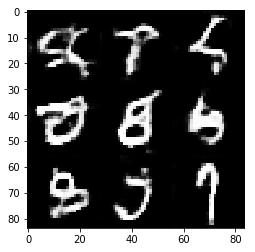

Epoch 1/2... Discriminator Loss: 1.5622... Generator Loss: 0.8774
Epoch 1/2... Discriminator Loss: 1.6937... Generator Loss: 0.7168
Epoch 1/2... Discriminator Loss: 1.5196... Generator Loss: 0.9206
Epoch 1/2... Discriminator Loss: 1.8064... Generator Loss: 0.4581
Epoch 1/2... Discriminator Loss: 1.4195... Generator Loss: 1.0087
Epoch 1/2... Discriminator Loss: 1.4214... Generator Loss: 1.2077
Epoch 1/2... Discriminator Loss: 1.5807... Generator Loss: 0.5138
Epoch 1/2... Discriminator Loss: 1.3837... Generator Loss: 0.5990
Epoch 1/2... Discriminator Loss: 1.5879... Generator Loss: 0.6785
Epoch 1/2... Discriminator Loss: 1.3796... Generator Loss: 0.5843


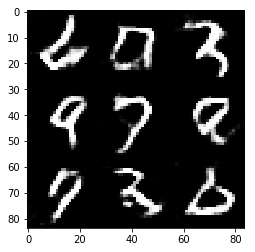

Epoch 1/2... Discriminator Loss: 1.5656... Generator Loss: 0.7046
Epoch 1/2... Discriminator Loss: 1.0870... Generator Loss: 1.4372
Epoch 1/2... Discriminator Loss: 1.3319... Generator Loss: 0.6069
Epoch 1/2... Discriminator Loss: 2.0228... Generator Loss: 0.4121
Epoch 1/2... Discriminator Loss: 1.7451... Generator Loss: 0.4542
Epoch 1/2... Discriminator Loss: 1.3522... Generator Loss: 1.2447
Epoch 1/2... Discriminator Loss: 1.7224... Generator Loss: 0.3287
Epoch 1/2... Discriminator Loss: 1.3939... Generator Loss: 0.9758
Epoch 1/2... Discriminator Loss: 1.7761... Generator Loss: 0.2530
Epoch 1/2... Discriminator Loss: 1.1460... Generator Loss: 0.8618


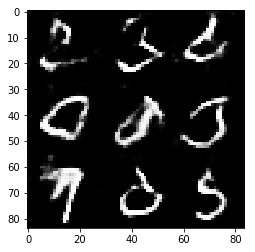

Epoch 1/2... Discriminator Loss: 0.9881... Generator Loss: 0.6089
Epoch 1/2... Discriminator Loss: 1.4426... Generator Loss: 0.6463
Epoch 1/2... Discriminator Loss: 1.9469... Generator Loss: 0.5455
Epoch 1/2... Discriminator Loss: 1.4889... Generator Loss: 0.8124
Epoch 1/2... Discriminator Loss: 1.4000... Generator Loss: 0.6808
Epoch 1/2... Discriminator Loss: 1.3901... Generator Loss: 0.6172
Epoch 1/2... Discriminator Loss: 1.1485... Generator Loss: 0.5649
Epoch 1/2... Discriminator Loss: 1.6718... Generator Loss: 0.5389
Epoch 1/2... Discriminator Loss: 1.6469... Generator Loss: 0.3733
Epoch 1/2... Discriminator Loss: 1.4309... Generator Loss: 0.4383


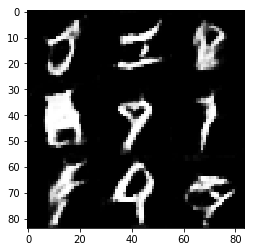

Epoch 1/2... Discriminator Loss: 1.9613... Generator Loss: 0.7822
Epoch 1/2... Discriminator Loss: 1.7877... Generator Loss: 0.7623
Epoch 1/2... Discriminator Loss: 1.8768... Generator Loss: 0.5540
Epoch 1/2... Discriminator Loss: 1.3387... Generator Loss: 0.7273
Epoch 1/2... Discriminator Loss: 1.4680... Generator Loss: 0.4685
Epoch 1/2... Discriminator Loss: 1.5445... Generator Loss: 0.9120
Epoch 1/2... Discriminator Loss: 1.2610... Generator Loss: 0.5204
Epoch 1/2... Discriminator Loss: 1.7350... Generator Loss: 0.4843
Epoch 1/2... Discriminator Loss: 1.5288... Generator Loss: 0.6914
Epoch 1/2... Discriminator Loss: 1.9176... Generator Loss: 0.4225


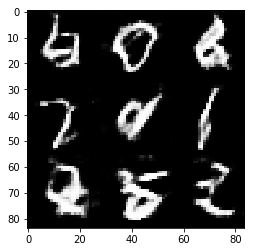

Epoch 1/2... Discriminator Loss: 1.2192... Generator Loss: 0.9979
Epoch 1/2... Discriminator Loss: 1.6020... Generator Loss: 0.5365
Epoch 1/2... Discriminator Loss: 1.4054... Generator Loss: 0.7742
Epoch 1/2... Discriminator Loss: 1.9266... Generator Loss: 0.4298
Epoch 1/2... Discriminator Loss: 1.5799... Generator Loss: 0.7885
Epoch 1/2... Discriminator Loss: 1.5543... Generator Loss: 0.3221
Epoch 1/2... Discriminator Loss: 1.7088... Generator Loss: 0.2855
Epoch 1/2... Discriminator Loss: 1.2721... Generator Loss: 0.7423
Epoch 1/2... Discriminator Loss: 1.9395... Generator Loss: 0.3026
Epoch 1/2... Discriminator Loss: 1.3966... Generator Loss: 0.6459


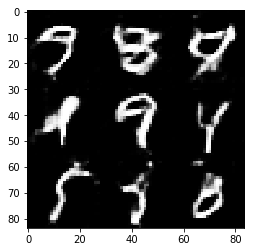

Epoch 1/2... Discriminator Loss: 1.1831... Generator Loss: 1.3852
Epoch 1/2... Discriminator Loss: 1.2329... Generator Loss: 1.5255
Epoch 1/2... Discriminator Loss: 1.0200... Generator Loss: 1.0766
Epoch 1/2... Discriminator Loss: 1.9382... Generator Loss: 0.4957
Epoch 1/2... Discriminator Loss: 1.5482... Generator Loss: 1.5738
Epoch 1/2... Discriminator Loss: 1.8831... Generator Loss: 0.5081
Epoch 1/2... Discriminator Loss: 1.7056... Generator Loss: 0.5305
Epoch 1/2... Discriminator Loss: 1.7048... Generator Loss: 0.4741
Epoch 1/2... Discriminator Loss: 1.0884... Generator Loss: 1.1560
Epoch 1/2... Discriminator Loss: 1.3973... Generator Loss: 0.3841


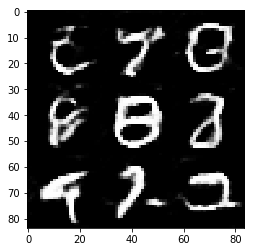

Epoch 1/2... Discriminator Loss: 1.6542... Generator Loss: 0.5985
Epoch 1/2... Discriminator Loss: 1.2541... Generator Loss: 1.1732
Epoch 1/2... Discriminator Loss: 1.2831... Generator Loss: 0.8286
Epoch 1/2... Discriminator Loss: 1.3823... Generator Loss: 0.3550
Epoch 1/2... Discriminator Loss: 1.5114... Generator Loss: 0.5977
Epoch 1/2... Discriminator Loss: 1.2791... Generator Loss: 1.2343
Epoch 1/2... Discriminator Loss: 1.0975... Generator Loss: 0.7999
Epoch 1/2... Discriminator Loss: 1.8232... Generator Loss: 0.5522
Epoch 1/2... Discriminator Loss: 1.5475... Generator Loss: 0.6385
Epoch 1/2... Discriminator Loss: 1.7713... Generator Loss: 0.5179


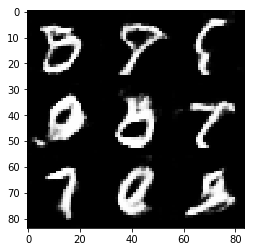

Epoch 1/2... Discriminator Loss: 1.7440... Generator Loss: 1.1112
Epoch 1/2... Discriminator Loss: 0.6958... Generator Loss: 1.0417
Epoch 1/2... Discriminator Loss: 1.5375... Generator Loss: 0.4303
Epoch 1/2... Discriminator Loss: 1.2916... Generator Loss: 0.7473
Epoch 1/2... Discriminator Loss: 1.1693... Generator Loss: 0.6677
Epoch 1/2... Discriminator Loss: 1.6474... Generator Loss: 0.6696
Epoch 1/2... Discriminator Loss: 1.3151... Generator Loss: 1.0402
Epoch 1/2... Discriminator Loss: 1.2418... Generator Loss: 0.8154
Epoch 1/2... Discriminator Loss: 1.5133... Generator Loss: 0.3415
Epoch 1/2... Discriminator Loss: 1.3773... Generator Loss: 1.0313


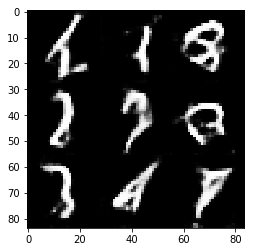

Epoch 1/2... Discriminator Loss: 1.5010... Generator Loss: 0.6745
Epoch 1/2... Discriminator Loss: 1.4075... Generator Loss: 1.5289
Epoch 1/2... Discriminator Loss: 1.4611... Generator Loss: 0.5094
Epoch 1/2... Discriminator Loss: 1.4350... Generator Loss: 0.6958
Epoch 1/2... Discriminator Loss: 1.0004... Generator Loss: 1.3129
Epoch 1/2... Discriminator Loss: 1.2423... Generator Loss: 1.2094
Epoch 1/2... Discriminator Loss: 1.6787... Generator Loss: 0.2310
Epoch 1/2... Discriminator Loss: 1.5953... Generator Loss: 0.4462
Epoch 1/2... Discriminator Loss: 1.4348... Generator Loss: 0.5232
Epoch 1/2... Discriminator Loss: 1.3657... Generator Loss: 0.7008


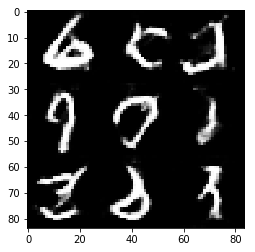

Epoch 1/2... Discriminator Loss: 1.4114... Generator Loss: 0.8900
Epoch 1/2... Discriminator Loss: 1.4384... Generator Loss: 0.3711
Epoch 1/2... Discriminator Loss: 1.1257... Generator Loss: 0.8817
Epoch 1/2... Discriminator Loss: 1.2339... Generator Loss: 0.4795
Epoch 1/2... Discriminator Loss: 0.7178... Generator Loss: 1.2225
Epoch 1/2... Discriminator Loss: 1.4343... Generator Loss: 0.6800
Epoch 1/2... Discriminator Loss: 1.2546... Generator Loss: 0.6644
Epoch 1/2... Discriminator Loss: 1.6479... Generator Loss: 0.7346
Epoch 1/2... Discriminator Loss: 1.0303... Generator Loss: 0.7116
Epoch 1/2... Discriminator Loss: 1.6185... Generator Loss: 0.3861


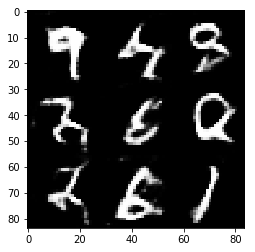

Epoch 1/2... Discriminator Loss: 1.4570... Generator Loss: 0.5092
Epoch 1/2... Discriminator Loss: 1.8344... Generator Loss: 0.4802
Epoch 1/2... Discriminator Loss: 2.0210... Generator Loss: 0.5647
Epoch 1/2... Discriminator Loss: 1.0645... Generator Loss: 1.0725
Epoch 1/2... Discriminator Loss: 1.2599... Generator Loss: 0.7568
Epoch 1/2... Discriminator Loss: 1.2235... Generator Loss: 0.6404
Epoch 1/2... Discriminator Loss: 1.6259... Generator Loss: 0.7130
Epoch 1/2... Discriminator Loss: 1.2521... Generator Loss: 0.6970
Epoch 1/2... Discriminator Loss: 1.6182... Generator Loss: 0.3893
Epoch 1/2... Discriminator Loss: 1.5750... Generator Loss: 0.7098


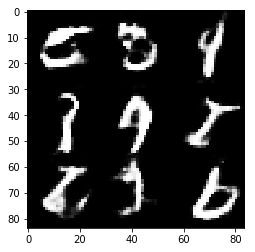

Epoch 1/2... Discriminator Loss: 1.5523... Generator Loss: 0.7217
Epoch 1/2... Discriminator Loss: 1.5165... Generator Loss: 1.0709
Epoch 1/2... Discriminator Loss: 1.4664... Generator Loss: 0.4452
Epoch 1/2... Discriminator Loss: 1.4700... Generator Loss: 0.6151
Epoch 1/2... Discriminator Loss: 2.1517... Generator Loss: 0.7885
Epoch 1/2... Discriminator Loss: 1.8848... Generator Loss: 0.2148
Epoch 1/2... Discriminator Loss: 1.5650... Generator Loss: 0.7615
Epoch 1/2... Discriminator Loss: 1.2519... Generator Loss: 0.6221
Epoch 1/2... Discriminator Loss: 1.5996... Generator Loss: 0.4962
Epoch 1/2... Discriminator Loss: 1.4794... Generator Loss: 0.8243


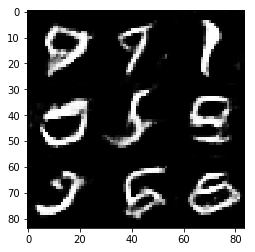

Epoch 1/2... Discriminator Loss: 1.3899... Generator Loss: 0.6676
Epoch 1/2... Discriminator Loss: 0.9492... Generator Loss: 0.7684
Epoch 1/2... Discriminator Loss: 0.8136... Generator Loss: 1.0369
Epoch 1/2... Discriminator Loss: 1.5060... Generator Loss: 0.9194
Epoch 1/2... Discriminator Loss: 1.1798... Generator Loss: 0.8983
Epoch 1/2... Discriminator Loss: 1.3111... Generator Loss: 0.7303
Epoch 1/2... Discriminator Loss: 1.2072... Generator Loss: 1.0679
Epoch 1/2... Discriminator Loss: 1.6084... Generator Loss: 0.9242
Epoch 1/2... Discriminator Loss: 0.9600... Generator Loss: 1.1748
Epoch 1/2... Discriminator Loss: 1.5752... Generator Loss: 1.2399


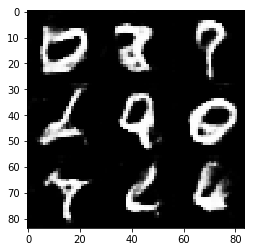

Epoch 1/2... Discriminator Loss: 1.5908... Generator Loss: 1.6382
Epoch 1/2... Discriminator Loss: 1.5318... Generator Loss: 0.7742
Epoch 1/2... Discriminator Loss: 1.6108... Generator Loss: 1.3806
Epoch 1/2... Discriminator Loss: 1.5273... Generator Loss: 0.7186
Epoch 1/2... Discriminator Loss: 1.1098... Generator Loss: 0.9626
Epoch 1/2... Discriminator Loss: 1.2345... Generator Loss: 1.0696
Epoch 1/2... Discriminator Loss: 1.4062... Generator Loss: 1.0968
Epoch 1/2... Discriminator Loss: 1.5526... Generator Loss: 1.3320
Epoch 1/2... Discriminator Loss: 1.1894... Generator Loss: 0.7153
Epoch 1/2... Discriminator Loss: 1.3515... Generator Loss: 0.6508


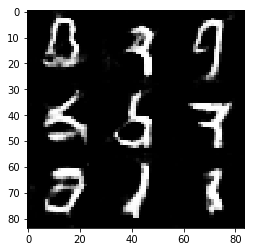

Epoch 1/2... Discriminator Loss: 0.7809... Generator Loss: 1.3346
Epoch 1/2... Discriminator Loss: 1.7802... Generator Loss: 0.3378
Epoch 1/2... Discriminator Loss: 1.4124... Generator Loss: 0.5053
Epoch 1/2... Discriminator Loss: 1.7912... Generator Loss: 0.4098
Epoch 1/2... Discriminator Loss: 1.1714... Generator Loss: 0.6885
Epoch 2/2... Discriminator Loss: 1.2959... Generator Loss: 0.8469
Epoch 2/2... Discriminator Loss: 1.5590... Generator Loss: 0.9335
Epoch 2/2... Discriminator Loss: 2.0647... Generator Loss: 0.4660
Epoch 2/2... Discriminator Loss: 1.3481... Generator Loss: 0.9236
Epoch 2/2... Discriminator Loss: 1.8608... Generator Loss: 0.3339


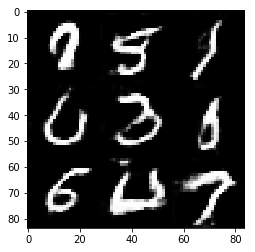

Epoch 2/2... Discriminator Loss: 1.5753... Generator Loss: 0.4153
Epoch 2/2... Discriminator Loss: 1.2320... Generator Loss: 1.0928
Epoch 2/2... Discriminator Loss: 1.5775... Generator Loss: 0.9891
Epoch 2/2... Discriminator Loss: 1.1313... Generator Loss: 0.9964
Epoch 2/2... Discriminator Loss: 1.6051... Generator Loss: 0.5454
Epoch 2/2... Discriminator Loss: 1.1439... Generator Loss: 1.0023
Epoch 2/2... Discriminator Loss: 1.6456... Generator Loss: 0.5543
Epoch 2/2... Discriminator Loss: 0.9874... Generator Loss: 1.3769
Epoch 2/2... Discriminator Loss: 1.6772... Generator Loss: 0.4961
Epoch 2/2... Discriminator Loss: 1.2879... Generator Loss: 0.5918


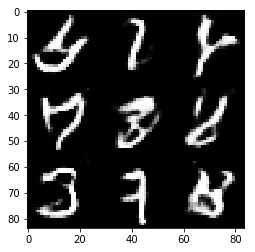

Epoch 2/2... Discriminator Loss: 1.1329... Generator Loss: 0.4254
Epoch 2/2... Discriminator Loss: 1.3438... Generator Loss: 0.9754
Epoch 2/2... Discriminator Loss: 2.0008... Generator Loss: 0.4765
Epoch 2/2... Discriminator Loss: 1.3581... Generator Loss: 0.9235
Epoch 2/2... Discriminator Loss: 1.4223... Generator Loss: 0.8791
Epoch 2/2... Discriminator Loss: 1.5105... Generator Loss: 0.5212
Epoch 2/2... Discriminator Loss: 0.9093... Generator Loss: 1.1811
Epoch 2/2... Discriminator Loss: 1.2581... Generator Loss: 0.9800
Epoch 2/2... Discriminator Loss: 0.8256... Generator Loss: 1.2266
Epoch 2/2... Discriminator Loss: 1.3180... Generator Loss: 0.9422


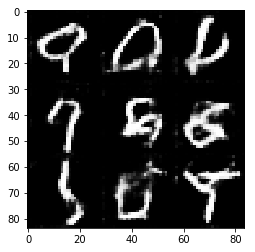

Epoch 2/2... Discriminator Loss: 1.6538... Generator Loss: 0.5799
Epoch 2/2... Discriminator Loss: 1.6432... Generator Loss: 0.6257
Epoch 2/2... Discriminator Loss: 1.0745... Generator Loss: 0.7612
Epoch 2/2... Discriminator Loss: 1.2751... Generator Loss: 0.8304
Epoch 2/2... Discriminator Loss: 1.0705... Generator Loss: 1.0564
Epoch 2/2... Discriminator Loss: 1.6372... Generator Loss: 0.5221
Epoch 2/2... Discriminator Loss: 1.3370... Generator Loss: 1.0241
Epoch 2/2... Discriminator Loss: 1.0334... Generator Loss: 1.0845
Epoch 2/2... Discriminator Loss: 1.3929... Generator Loss: 0.6328
Epoch 2/2... Discriminator Loss: 1.3187... Generator Loss: 0.6295


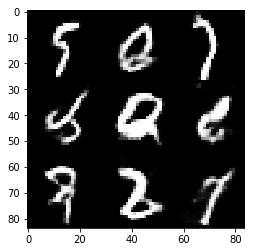

Epoch 2/2... Discriminator Loss: 1.4330... Generator Loss: 1.3007
Epoch 2/2... Discriminator Loss: 1.4408... Generator Loss: 0.7335
Epoch 2/2... Discriminator Loss: 1.5345... Generator Loss: 0.4178
Epoch 2/2... Discriminator Loss: 1.3300... Generator Loss: 1.0936
Epoch 2/2... Discriminator Loss: 1.9217... Generator Loss: 0.4782
Epoch 2/2... Discriminator Loss: 1.3872... Generator Loss: 0.7098
Epoch 2/2... Discriminator Loss: 1.1202... Generator Loss: 0.8901
Epoch 2/2... Discriminator Loss: 1.3630... Generator Loss: 0.5601
Epoch 2/2... Discriminator Loss: 1.2224... Generator Loss: 1.0418
Epoch 2/2... Discriminator Loss: 1.3830... Generator Loss: 0.8210


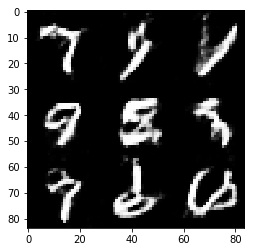

Epoch 2/2... Discriminator Loss: 1.2812... Generator Loss: 1.4850
Epoch 2/2... Discriminator Loss: 2.3459... Generator Loss: 0.5409
Epoch 2/2... Discriminator Loss: 1.0189... Generator Loss: 0.7404
Epoch 2/2... Discriminator Loss: 1.5496... Generator Loss: 0.2969
Epoch 2/2... Discriminator Loss: 1.0424... Generator Loss: 1.0175
Epoch 2/2... Discriminator Loss: 2.2097... Generator Loss: 0.3903
Epoch 2/2... Discriminator Loss: 1.2038... Generator Loss: 1.3982
Epoch 2/2... Discriminator Loss: 1.4160... Generator Loss: 0.6758
Epoch 2/2... Discriminator Loss: 1.4264... Generator Loss: 0.4684
Epoch 2/2... Discriminator Loss: 1.3960... Generator Loss: 0.6191


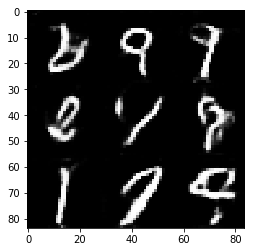

Epoch 2/2... Discriminator Loss: 1.6051... Generator Loss: 0.2689
Epoch 2/2... Discriminator Loss: 1.6822... Generator Loss: 0.7923
Epoch 2/2... Discriminator Loss: 1.3280... Generator Loss: 0.9019
Epoch 2/2... Discriminator Loss: 0.9203... Generator Loss: 0.8872
Epoch 2/2... Discriminator Loss: 1.6824... Generator Loss: 0.5123
Epoch 2/2... Discriminator Loss: 1.4406... Generator Loss: 1.1645
Epoch 2/2... Discriminator Loss: 0.9335... Generator Loss: 1.5602
Epoch 2/2... Discriminator Loss: 1.9788... Generator Loss: 0.7974
Epoch 2/2... Discriminator Loss: 1.2673... Generator Loss: 0.7243
Epoch 2/2... Discriminator Loss: 1.4883... Generator Loss: 0.6665


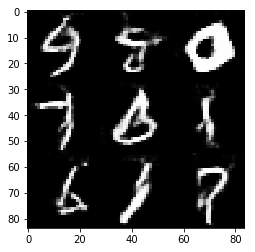

Epoch 2/2... Discriminator Loss: 1.6155... Generator Loss: 1.0312
Epoch 2/2... Discriminator Loss: 1.1170... Generator Loss: 0.7889
Epoch 2/2... Discriminator Loss: 1.6434... Generator Loss: 0.7077
Epoch 2/2... Discriminator Loss: 0.7411... Generator Loss: 0.8167
Epoch 2/2... Discriminator Loss: 1.2161... Generator Loss: 0.7776
Epoch 2/2... Discriminator Loss: 1.5171... Generator Loss: 0.6981
Epoch 2/2... Discriminator Loss: 1.3347... Generator Loss: 1.1064
Epoch 2/2... Discriminator Loss: 1.8441... Generator Loss: 1.0439
Epoch 2/2... Discriminator Loss: 1.2984... Generator Loss: 1.0602
Epoch 2/2... Discriminator Loss: 1.4422... Generator Loss: 1.6752


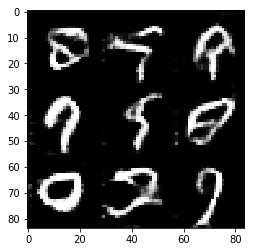

Epoch 2/2... Discriminator Loss: 1.9831... Generator Loss: 0.7884
Epoch 2/2... Discriminator Loss: 1.2626... Generator Loss: 0.6733
Epoch 2/2... Discriminator Loss: 0.9724... Generator Loss: 0.7955
Epoch 2/2... Discriminator Loss: 1.2031... Generator Loss: 0.6299
Epoch 2/2... Discriminator Loss: 1.4493... Generator Loss: 0.6361
Epoch 2/2... Discriminator Loss: 1.5476... Generator Loss: 0.5262
Epoch 2/2... Discriminator Loss: 1.3390... Generator Loss: 1.2522
Epoch 2/2... Discriminator Loss: 1.4992... Generator Loss: 0.4166
Epoch 2/2... Discriminator Loss: 1.3148... Generator Loss: 1.2909
Epoch 2/2... Discriminator Loss: 1.1160... Generator Loss: 0.8081


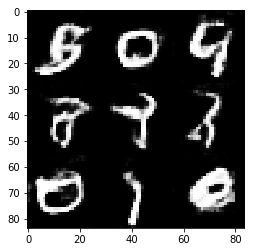

Epoch 2/2... Discriminator Loss: 1.3835... Generator Loss: 0.7233
Epoch 2/2... Discriminator Loss: 1.2148... Generator Loss: 0.6930
Epoch 2/2... Discriminator Loss: 1.2722... Generator Loss: 1.1930
Epoch 2/2... Discriminator Loss: 1.1899... Generator Loss: 1.1070
Epoch 2/2... Discriminator Loss: 1.8106... Generator Loss: 1.8816
Epoch 2/2... Discriminator Loss: 1.3969... Generator Loss: 0.7662
Epoch 2/2... Discriminator Loss: 1.2651... Generator Loss: 0.5356
Epoch 2/2... Discriminator Loss: 1.5348... Generator Loss: 0.5595
Epoch 2/2... Discriminator Loss: 1.7869... Generator Loss: 0.4612
Epoch 2/2... Discriminator Loss: 1.4152... Generator Loss: 0.7719


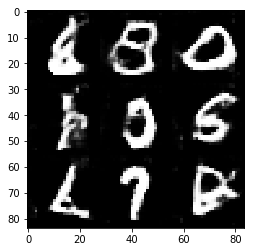

Epoch 2/2... Discriminator Loss: 1.6354... Generator Loss: 0.4682
Epoch 2/2... Discriminator Loss: 1.2144... Generator Loss: 1.1375
Epoch 2/2... Discriminator Loss: 1.7598... Generator Loss: 0.6177
Epoch 2/2... Discriminator Loss: 1.4908... Generator Loss: 0.8129
Epoch 2/2... Discriminator Loss: 1.9423... Generator Loss: 1.0276
Epoch 2/2... Discriminator Loss: 1.5201... Generator Loss: 0.5350
Epoch 2/2... Discriminator Loss: 1.5409... Generator Loss: 1.0789
Epoch 2/2... Discriminator Loss: 0.9021... Generator Loss: 1.0188
Epoch 2/2... Discriminator Loss: 1.4215... Generator Loss: 0.9850
Epoch 2/2... Discriminator Loss: 1.4363... Generator Loss: 0.9573


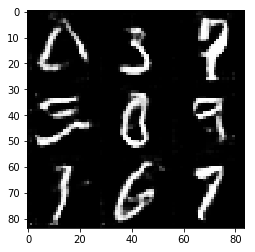

Epoch 2/2... Discriminator Loss: 1.1830... Generator Loss: 0.5105
Epoch 2/2... Discriminator Loss: 1.8171... Generator Loss: 0.7091
Epoch 2/2... Discriminator Loss: 0.8683... Generator Loss: 0.8150
Epoch 2/2... Discriminator Loss: 1.1893... Generator Loss: 1.4705
Epoch 2/2... Discriminator Loss: 1.1993... Generator Loss: 0.6501
Epoch 2/2... Discriminator Loss: 1.3045... Generator Loss: 0.7414
Epoch 2/2... Discriminator Loss: 1.3776... Generator Loss: 0.5066
Epoch 2/2... Discriminator Loss: 0.9206... Generator Loss: 0.9906
Epoch 2/2... Discriminator Loss: 1.8663... Generator Loss: 1.0585
Epoch 2/2... Discriminator Loss: 1.4585... Generator Loss: 1.4784


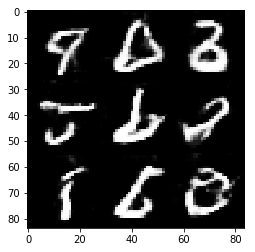

Epoch 2/2... Discriminator Loss: 1.3237... Generator Loss: 0.7439
Epoch 2/2... Discriminator Loss: 1.1483... Generator Loss: 1.1353
Epoch 2/2... Discriminator Loss: 2.1394... Generator Loss: 0.2924
Epoch 2/2... Discriminator Loss: 1.4218... Generator Loss: 0.8329
Epoch 2/2... Discriminator Loss: 1.2557... Generator Loss: 1.2527
Epoch 2/2... Discriminator Loss: 1.7464... Generator Loss: 0.5455
Epoch 2/2... Discriminator Loss: 1.5503... Generator Loss: 1.1189
Epoch 2/2... Discriminator Loss: 1.0856... Generator Loss: 0.5805
Epoch 2/2... Discriminator Loss: 1.2751... Generator Loss: 0.4202
Epoch 2/2... Discriminator Loss: 1.1224... Generator Loss: 1.2237


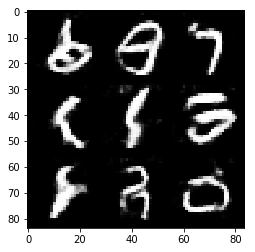

Epoch 2/2... Discriminator Loss: 0.8794... Generator Loss: 1.8036
Epoch 2/2... Discriminator Loss: 2.1545... Generator Loss: 0.5017
Epoch 2/2... Discriminator Loss: 1.4191... Generator Loss: 1.0971
Epoch 2/2... Discriminator Loss: 1.2027... Generator Loss: 0.6016
Epoch 2/2... Discriminator Loss: 1.0229... Generator Loss: 1.1560
Epoch 2/2... Discriminator Loss: 1.3499... Generator Loss: 0.6960
Epoch 2/2... Discriminator Loss: 1.4105... Generator Loss: 0.6322
Epoch 2/2... Discriminator Loss: 1.2626... Generator Loss: 0.7936
Epoch 2/2... Discriminator Loss: 1.3183... Generator Loss: 0.5152
Epoch 2/2... Discriminator Loss: 1.5564... Generator Loss: 0.5114


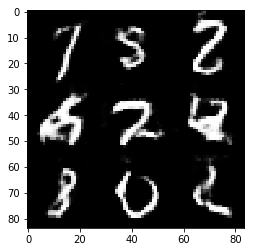

Epoch 2/2... Discriminator Loss: 1.0074... Generator Loss: 0.8824
Epoch 2/2... Discriminator Loss: 1.4807... Generator Loss: 1.1819
Epoch 2/2... Discriminator Loss: 0.9801... Generator Loss: 1.2663
Epoch 2/2... Discriminator Loss: 1.3586... Generator Loss: 0.6300
Epoch 2/2... Discriminator Loss: 1.8236... Generator Loss: 0.5843
Epoch 2/2... Discriminator Loss: 1.3117... Generator Loss: 0.8217
Epoch 2/2... Discriminator Loss: 1.5966... Generator Loss: 0.3488
Epoch 2/2... Discriminator Loss: 1.5406... Generator Loss: 0.5383
Epoch 2/2... Discriminator Loss: 1.5071... Generator Loss: 0.6023
Epoch 2/2... Discriminator Loss: 1.7482... Generator Loss: 0.5984


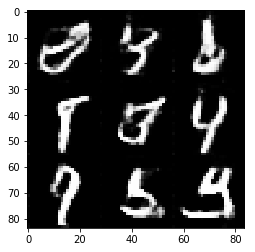

Epoch 2/2... Discriminator Loss: 1.7583... Generator Loss: 0.6136
Epoch 2/2... Discriminator Loss: 1.9282... Generator Loss: 1.0044
Epoch 2/2... Discriminator Loss: 1.1879... Generator Loss: 0.9925
Epoch 2/2... Discriminator Loss: 1.5789... Generator Loss: 0.4220
Epoch 2/2... Discriminator Loss: 0.9798... Generator Loss: 0.6924
Epoch 2/2... Discriminator Loss: 1.9164... Generator Loss: 0.4188
Epoch 2/2... Discriminator Loss: 1.3946... Generator Loss: 1.3234
Epoch 2/2... Discriminator Loss: 1.2363... Generator Loss: 0.7073
Epoch 2/2... Discriminator Loss: 1.6473... Generator Loss: 0.4794
Epoch 2/2... Discriminator Loss: 1.8687... Generator Loss: 1.3441


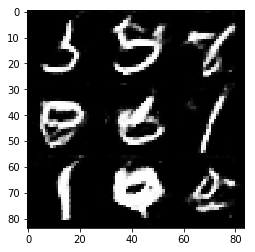

Epoch 2/2... Discriminator Loss: 1.4066... Generator Loss: 0.8133
Epoch 2/2... Discriminator Loss: 1.2635... Generator Loss: 0.6021
Epoch 2/2... Discriminator Loss: 1.3328... Generator Loss: 0.6852
Epoch 2/2... Discriminator Loss: 1.8227... Generator Loss: 0.8672
Epoch 2/2... Discriminator Loss: 0.9709... Generator Loss: 0.9080
Epoch 2/2... Discriminator Loss: 1.0871... Generator Loss: 1.3987
Epoch 2/2... Discriminator Loss: 1.8377... Generator Loss: 0.3868
Epoch 2/2... Discriminator Loss: 1.3564... Generator Loss: 0.6314
Epoch 2/2... Discriminator Loss: 0.9581... Generator Loss: 0.5376
Epoch 2/2... Discriminator Loss: 1.5491... Generator Loss: 0.3727


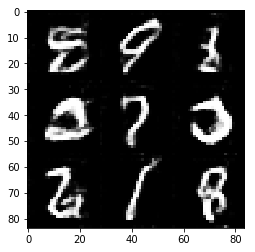

Epoch 2/2... Discriminator Loss: 1.4892... Generator Loss: 0.5741
Epoch 2/2... Discriminator Loss: 1.1033... Generator Loss: 1.3640
Epoch 2/2... Discriminator Loss: 1.5801... Generator Loss: 1.4895
Epoch 2/2... Discriminator Loss: 1.1400... Generator Loss: 0.5386
Epoch 2/2... Discriminator Loss: 1.2465... Generator Loss: 0.7774
Epoch 2/2... Discriminator Loss: 1.3293... Generator Loss: 0.7923
Epoch 2/2... Discriminator Loss: 1.6221... Generator Loss: 0.2977
Epoch 2/2... Discriminator Loss: 1.2771... Generator Loss: 0.8243
Epoch 2/2... Discriminator Loss: 1.7548... Generator Loss: 0.7799
Epoch 2/2... Discriminator Loss: 1.8083... Generator Loss: 0.6796


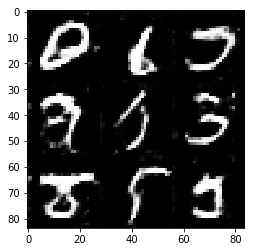

Epoch 2/2... Discriminator Loss: 1.5807... Generator Loss: 0.7278
Epoch 2/2... Discriminator Loss: 1.4115... Generator Loss: 0.9480
Epoch 2/2... Discriminator Loss: 1.2971... Generator Loss: 1.0173
Epoch 2/2... Discriminator Loss: 1.4067... Generator Loss: 1.0046
Epoch 2/2... Discriminator Loss: 1.6070... Generator Loss: 0.7657
Epoch 2/2... Discriminator Loss: 1.5370... Generator Loss: 0.7167
Epoch 2/2... Discriminator Loss: 1.4096... Generator Loss: 1.2404
Epoch 2/2... Discriminator Loss: 1.2212... Generator Loss: 1.4376
Epoch 2/2... Discriminator Loss: 0.8620... Generator Loss: 0.9661
Epoch 2/2... Discriminator Loss: 1.5202... Generator Loss: 0.6274


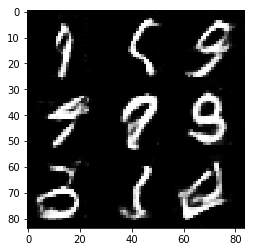

Epoch 2/2... Discriminator Loss: 1.2569... Generator Loss: 1.3799
Epoch 2/2... Discriminator Loss: 1.2960... Generator Loss: 1.3117
Epoch 2/2... Discriminator Loss: 1.3097... Generator Loss: 0.5947
Epoch 2/2... Discriminator Loss: 1.4722... Generator Loss: 0.4983
Epoch 2/2... Discriminator Loss: 1.5699... Generator Loss: 0.4690
Epoch 2/2... Discriminator Loss: 1.1489... Generator Loss: 1.0878
Epoch 2/2... Discriminator Loss: 1.6825... Generator Loss: 0.8660
Epoch 2/2... Discriminator Loss: 1.4952... Generator Loss: 0.4660
Epoch 2/2... Discriminator Loss: 1.2724... Generator Loss: 0.8727
Epoch 2/2... Discriminator Loss: 0.8699... Generator Loss: 0.6345


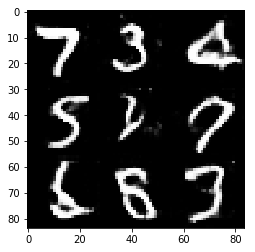

Epoch 2/2... Discriminator Loss: 1.3675... Generator Loss: 1.3188
Epoch 2/2... Discriminator Loss: 1.5289... Generator Loss: 0.9673
Epoch 2/2... Discriminator Loss: 1.7292... Generator Loss: 0.7442
Epoch 2/2... Discriminator Loss: 1.7807... Generator Loss: 0.7824
Epoch 2/2... Discriminator Loss: 0.9725... Generator Loss: 0.5792
Epoch 2/2... Discriminator Loss: 1.5479... Generator Loss: 0.6688
Epoch 2/2... Discriminator Loss: 1.9549... Generator Loss: 0.3714
Epoch 2/2... Discriminator Loss: 1.1772... Generator Loss: 1.6203
Epoch 2/2... Discriminator Loss: 1.4515... Generator Loss: 1.3587
Epoch 2/2... Discriminator Loss: 1.4054... Generator Loss: 0.3264


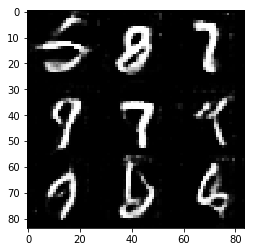

Epoch 2/2... Discriminator Loss: 1.5783... Generator Loss: 0.7230
Epoch 2/2... Discriminator Loss: 1.0745... Generator Loss: 1.5103
Epoch 2/2... Discriminator Loss: 1.6325... Generator Loss: 0.8144
Epoch 2/2... Discriminator Loss: 1.8734... Generator Loss: 0.6148
Epoch 2/2... Discriminator Loss: 1.9153... Generator Loss: 0.8740
Epoch 2/2... Discriminator Loss: 1.1417... Generator Loss: 1.1030
Epoch 2/2... Discriminator Loss: 1.2027... Generator Loss: 1.1189
Epoch 2/2... Discriminator Loss: 1.2578... Generator Loss: 1.5488
Epoch 2/2... Discriminator Loss: 1.5099... Generator Loss: 0.7267
Epoch 2/2... Discriminator Loss: 1.6558... Generator Loss: 0.7781


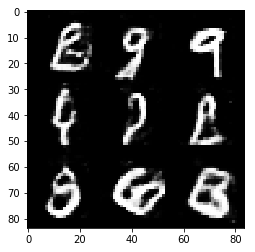

Epoch 2/2... Discriminator Loss: 1.0694... Generator Loss: 1.3204
Epoch 2/2... Discriminator Loss: 1.5933... Generator Loss: 0.7042
Epoch 2/2... Discriminator Loss: 1.0169... Generator Loss: 1.0200
Epoch 2/2... Discriminator Loss: 1.3825... Generator Loss: 0.9754
Epoch 2/2... Discriminator Loss: 1.2669... Generator Loss: 0.6609
Epoch 2/2... Discriminator Loss: 1.7826... Generator Loss: 0.4541
Epoch 2/2... Discriminator Loss: 1.2296... Generator Loss: 0.6527
Epoch 2/2... Discriminator Loss: 0.8892... Generator Loss: 0.8832
Epoch 2/2... Discriminator Loss: 1.0669... Generator Loss: 0.6709
Epoch 2/2... Discriminator Loss: 0.7248... Generator Loss: 1.6118


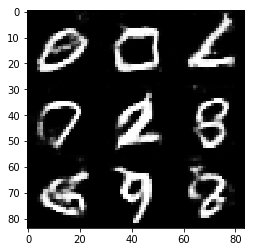

Epoch 2/2... Discriminator Loss: 1.4598... Generator Loss: 0.9676
Epoch 2/2... Discriminator Loss: 1.2304... Generator Loss: 0.9793
Epoch 2/2... Discriminator Loss: 1.2930... Generator Loss: 0.6825
Epoch 2/2... Discriminator Loss: 1.2192... Generator Loss: 0.9881
Epoch 2/2... Discriminator Loss: 1.9130... Generator Loss: 0.3789
Epoch 2/2... Discriminator Loss: 1.6787... Generator Loss: 0.6684
Epoch 2/2... Discriminator Loss: 1.4412... Generator Loss: 0.6310
Epoch 2/2... Discriminator Loss: 1.3749... Generator Loss: 0.7413
Epoch 2/2... Discriminator Loss: 1.9508... Generator Loss: 0.6849
Epoch 2/2... Discriminator Loss: 2.0875... Generator Loss: 0.3765


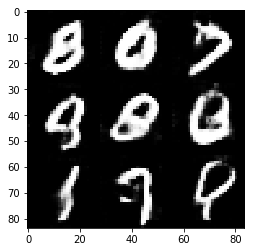

Epoch 2/2... Discriminator Loss: 2.3578... Generator Loss: 0.2427
Epoch 2/2... Discriminator Loss: 1.2760... Generator Loss: 0.9604
Epoch 2/2... Discriminator Loss: 1.7272... Generator Loss: 0.7754
Epoch 2/2... Discriminator Loss: 1.1489... Generator Loss: 1.5779
Epoch 2/2... Discriminator Loss: 1.9020... Generator Loss: 0.2199
Epoch 2/2... Discriminator Loss: 1.4086... Generator Loss: 0.5735
Epoch 2/2... Discriminator Loss: 1.0913... Generator Loss: 1.3039
Epoch 2/2... Discriminator Loss: 1.3664... Generator Loss: 0.8985
Epoch 2/2... Discriminator Loss: 1.2729... Generator Loss: 0.7245
Epoch 2/2... Discriminator Loss: 1.2653... Generator Loss: 0.5005


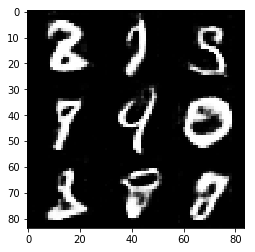

Epoch 2/2... Discriminator Loss: 1.3643... Generator Loss: 0.4952
Epoch 2/2... Discriminator Loss: 1.6583... Generator Loss: 0.3607
Epoch 2/2... Discriminator Loss: 1.5979... Generator Loss: 0.5688
Epoch 2/2... Discriminator Loss: 1.6645... Generator Loss: 0.8946
Epoch 2/2... Discriminator Loss: 1.2311... Generator Loss: 0.9681
Epoch 2/2... Discriminator Loss: 0.9878... Generator Loss: 1.0322
Epoch 2/2... Discriminator Loss: 1.2389... Generator Loss: 0.9164
Epoch 2/2... Discriminator Loss: 1.5711... Generator Loss: 0.4246
Epoch 2/2... Discriminator Loss: 1.1430... Generator Loss: 0.9739
Epoch 2/2... Discriminator Loss: 1.2411... Generator Loss: 1.5293


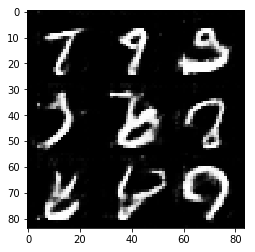

Epoch 2/2... Discriminator Loss: 0.9615... Generator Loss: 0.6487
Epoch 2/2... Discriminator Loss: 1.2694... Generator Loss: 0.8208
Epoch 2/2... Discriminator Loss: 1.2285... Generator Loss: 0.7225
Epoch 2/2... Discriminator Loss: 1.5443... Generator Loss: 1.4730
Epoch 2/2... Discriminator Loss: 1.4253... Generator Loss: 0.3575
Epoch 2/2... Discriminator Loss: 1.4545... Generator Loss: 0.6262
Epoch 2/2... Discriminator Loss: 1.8355... Generator Loss: 0.5507
Epoch 2/2... Discriminator Loss: 1.8372... Generator Loss: 0.4117
Epoch 2/2... Discriminator Loss: 1.3849... Generator Loss: 0.9605
Epoch 2/2... Discriminator Loss: 1.7662... Generator Loss: 0.7302


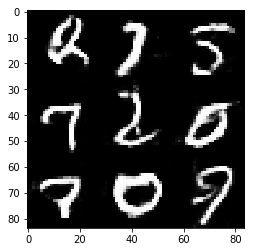

Epoch 2/2... Discriminator Loss: 1.7994... Generator Loss: 0.3132
Epoch 2/2... Discriminator Loss: 1.5993... Generator Loss: 0.7386
Epoch 2/2... Discriminator Loss: 1.4460... Generator Loss: 0.4135
Epoch 2/2... Discriminator Loss: 1.1946... Generator Loss: 0.7591
Epoch 2/2... Discriminator Loss: 1.4860... Generator Loss: 0.3991
Epoch 2/2... Discriminator Loss: 0.8774... Generator Loss: 0.9053
Epoch 2/2... Discriminator Loss: 0.9554... Generator Loss: 1.3575
Epoch 2/2... Discriminator Loss: 1.7719... Generator Loss: 0.6551
Epoch 2/2... Discriminator Loss: 1.0386... Generator Loss: 0.8389
Epoch 2/2... Discriminator Loss: 1.8685... Generator Loss: 0.8922


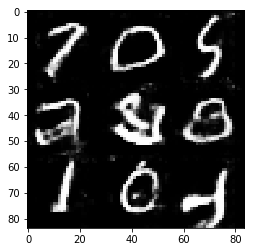

Epoch 2/2... Discriminator Loss: 2.2429... Generator Loss: 0.3317
Epoch 2/2... Discriminator Loss: 1.6583... Generator Loss: 0.3542
Epoch 2/2... Discriminator Loss: 0.8758... Generator Loss: 1.4670
Epoch 2/2... Discriminator Loss: 1.4332... Generator Loss: 1.5231
Epoch 2/2... Discriminator Loss: 1.4111... Generator Loss: 0.8414
Epoch 2/2... Discriminator Loss: 1.3549... Generator Loss: 0.9053
Epoch 2/2... Discriminator Loss: 1.1830... Generator Loss: 1.4374
Epoch 2/2... Discriminator Loss: 0.9577... Generator Loss: 1.3602
Epoch 2/2... Discriminator Loss: 1.1226... Generator Loss: 1.3133
Epoch 2/2... Discriminator Loss: 1.2290... Generator Loss: 0.8889


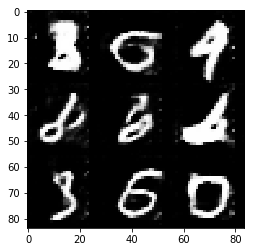

Epoch 2/2... Discriminator Loss: 1.8206... Generator Loss: 0.4629
Epoch 2/2... Discriminator Loss: 1.9520... Generator Loss: 0.4826
Epoch 2/2... Discriminator Loss: 1.2260... Generator Loss: 0.4519
Epoch 2/2... Discriminator Loss: 1.3148... Generator Loss: 1.1385
Epoch 2/2... Discriminator Loss: 1.2900... Generator Loss: 0.6553
Epoch 2/2... Discriminator Loss: 1.4856... Generator Loss: 0.1949
Epoch 2/2... Discriminator Loss: 1.2440... Generator Loss: 0.6155
Epoch 2/2... Discriminator Loss: 1.2242... Generator Loss: 0.9617
Epoch 2/2... Discriminator Loss: 1.5031... Generator Loss: 0.7100
Epoch 2/2... Discriminator Loss: 1.3807... Generator Loss: 0.7590


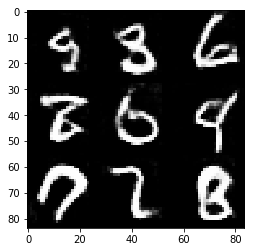

Epoch 2/2... Discriminator Loss: 1.1457... Generator Loss: 1.0976
Epoch 2/2... Discriminator Loss: 0.8827... Generator Loss: 1.1266
Epoch 2/2... Discriminator Loss: 1.4657... Generator Loss: 1.0422
Epoch 2/2... Discriminator Loss: 1.1059... Generator Loss: 0.8964
Epoch 2/2... Discriminator Loss: 1.0957... Generator Loss: 0.7425
Epoch 2/2... Discriminator Loss: 1.3830... Generator Loss: 0.5051
Epoch 2/2... Discriminator Loss: 1.4302... Generator Loss: 0.7250
Epoch 2/2... Discriminator Loss: 1.2889... Generator Loss: 1.4117
Epoch 2/2... Discriminator Loss: 1.3653... Generator Loss: 1.9632
Epoch 2/2... Discriminator Loss: 2.1267... Generator Loss: 0.2531


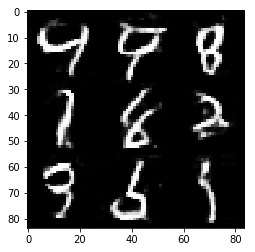

Epoch 2/2... Discriminator Loss: 1.3460... Generator Loss: 0.5096
Epoch 2/2... Discriminator Loss: 1.2942... Generator Loss: 0.7701
Epoch 2/2... Discriminator Loss: 1.8998... Generator Loss: 0.3287
Epoch 2/2... Discriminator Loss: 1.1332... Generator Loss: 0.5419
Epoch 2/2... Discriminator Loss: 1.4519... Generator Loss: 0.6689
Epoch 2/2... Discriminator Loss: 1.0960... Generator Loss: 0.6973
Epoch 2/2... Discriminator Loss: 1.2994... Generator Loss: 1.0279
Epoch 2/2... Discriminator Loss: 1.8118... Generator Loss: 0.7151
Epoch 2/2... Discriminator Loss: 1.1056... Generator Loss: 0.4746
Epoch 2/2... Discriminator Loss: 1.4105... Generator Loss: 0.8284


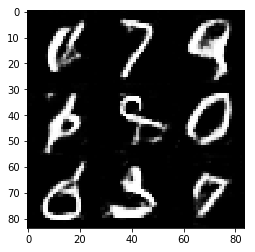

Epoch 2/2... Discriminator Loss: 1.0459... Generator Loss: 1.0061
Epoch 2/2... Discriminator Loss: 1.5949... Generator Loss: 0.5180
Epoch 2/2... Discriminator Loss: 1.3964... Generator Loss: 0.3463
Epoch 2/2... Discriminator Loss: 1.3132... Generator Loss: 0.6621
Epoch 2/2... Discriminator Loss: 1.6572... Generator Loss: 0.9142
Epoch 2/2... Discriminator Loss: 1.1166... Generator Loss: 0.7115
Epoch 2/2... Discriminator Loss: 1.8326... Generator Loss: 0.2850
Epoch 2/2... Discriminator Loss: 1.2514... Generator Loss: 1.2836
Epoch 2/2... Discriminator Loss: 1.0671... Generator Loss: 1.1783
Epoch 2/2... Discriminator Loss: 1.0827... Generator Loss: 1.7164


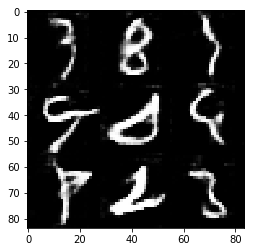

Epoch 2/2... Discriminator Loss: 1.0492... Generator Loss: 0.8035
Epoch 2/2... Discriminator Loss: 1.1933... Generator Loss: 0.6294
Epoch 2/2... Discriminator Loss: 1.7033... Generator Loss: 0.6430
Epoch 2/2... Discriminator Loss: 1.6266... Generator Loss: 0.8291
Epoch 2/2... Discriminator Loss: 1.5137... Generator Loss: 0.3956
Epoch 2/2... Discriminator Loss: 1.1778... Generator Loss: 0.8152
Epoch 2/2... Discriminator Loss: 1.4329... Generator Loss: 0.8257
Epoch 2/2... Discriminator Loss: 0.8152... Generator Loss: 1.3274
Epoch 2/2... Discriminator Loss: 1.0328... Generator Loss: 1.0732
Epoch 2/2... Discriminator Loss: 2.0532... Generator Loss: 1.0715


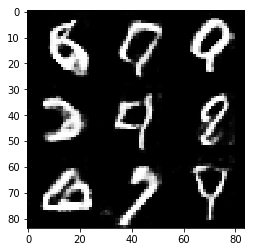

Epoch 2/2... Discriminator Loss: 1.5260... Generator Loss: 0.9328
Epoch 2/2... Discriminator Loss: 1.5582... Generator Loss: 0.7002
Epoch 2/2... Discriminator Loss: 1.2433... Generator Loss: 0.3545
Epoch 2/2... Discriminator Loss: 0.9145... Generator Loss: 0.6292
Epoch 2/2... Discriminator Loss: 1.1450... Generator Loss: 0.7780
Epoch 2/2... Discriminator Loss: 1.4262... Generator Loss: 0.9768
Epoch 2/2... Discriminator Loss: 1.2116... Generator Loss: 0.9771
Epoch 2/2... Discriminator Loss: 1.4203... Generator Loss: 0.7632
Epoch 2/2... Discriminator Loss: 0.9871... Generator Loss: 1.5788
Epoch 2/2... Discriminator Loss: 1.7250... Generator Loss: 0.8538


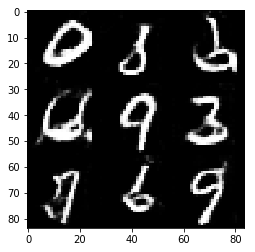

Epoch 2/2... Discriminator Loss: 1.2915... Generator Loss: 1.4317
Epoch 2/2... Discriminator Loss: 1.2719... Generator Loss: 1.4870
Epoch 2/2... Discriminator Loss: 1.7602... Generator Loss: 0.8401
Epoch 2/2... Discriminator Loss: 1.0135... Generator Loss: 0.4574
Epoch 2/2... Discriminator Loss: 1.2497... Generator Loss: 0.4282
Epoch 2/2... Discriminator Loss: 0.7096... Generator Loss: 1.0641
Epoch 2/2... Discriminator Loss: 1.6452... Generator Loss: 1.1017
Epoch 2/2... Discriminator Loss: 1.3214... Generator Loss: 0.4458
Epoch 2/2... Discriminator Loss: 1.1975... Generator Loss: 1.2494
Epoch 2/2... Discriminator Loss: 1.3447... Generator Loss: 0.5354


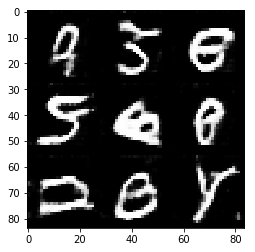

Epoch 2/2... Discriminator Loss: 0.6892... Generator Loss: 1.8602
Epoch 2/2... Discriminator Loss: 1.6043... Generator Loss: 0.8929
Epoch 2/2... Discriminator Loss: 1.6667... Generator Loss: 0.3549
Epoch 2/2... Discriminator Loss: 1.6433... Generator Loss: 0.9401
Epoch 2/2... Discriminator Loss: 1.7655... Generator Loss: 0.9707
Epoch 2/2... Discriminator Loss: 1.0761... Generator Loss: 0.8560
Epoch 2/2... Discriminator Loss: 0.8800... Generator Loss: 0.7476
Epoch 2/2... Discriminator Loss: 1.4598... Generator Loss: 0.5819
Epoch 2/2... Discriminator Loss: 1.7704... Generator Loss: 0.8285
Epoch 2/2... Discriminator Loss: 1.2089... Generator Loss: 1.7093


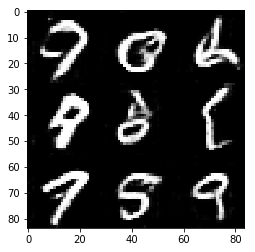

Epoch 2/2... Discriminator Loss: 1.2569... Generator Loss: 1.0968
Epoch 2/2... Discriminator Loss: 1.2117... Generator Loss: 0.6744
Epoch 2/2... Discriminator Loss: 1.7331... Generator Loss: 0.4617
Epoch 2/2... Discriminator Loss: 1.0322... Generator Loss: 1.2455
Epoch 2/2... Discriminator Loss: 1.5401... Generator Loss: 0.7486
Epoch 2/2... Discriminator Loss: 1.3382... Generator Loss: 0.8551
Epoch 2/2... Discriminator Loss: 1.1035... Generator Loss: 0.7133
Epoch 2/2... Discriminator Loss: 2.2190... Generator Loss: 0.3148
Epoch 2/2... Discriminator Loss: 1.4681... Generator Loss: 0.3602
Epoch 2/2... Discriminator Loss: 1.0573... Generator Loss: 1.0020


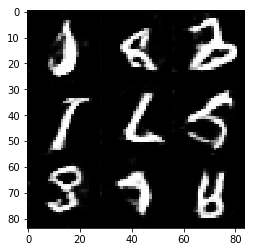

In [12]:
batch_size = 16
z_dim = 200
learning_rate = 0.0004
beta1 = 0.3




"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.7069... Generator Loss: 1.1531
Epoch 1/1... Discriminator Loss: 0.7951... Generator Loss: 0.8916
Epoch 1/1... Discriminator Loss: 0.7303... Generator Loss: 0.8577
Epoch 1/1... Discriminator Loss: 2.2635... Generator Loss: 0.5144
Epoch 1/1... Discriminator Loss: 0.8500... Generator Loss: 2.2804
Epoch 1/1... Discriminator Loss: 2.1193... Generator Loss: 0.8660
Epoch 1/1... Discriminator Loss: 0.6939... Generator Loss: 1.6465
Epoch 1/1... Discriminator Loss: 1.2472... Generator Loss: 0.9753
Epoch 1/1... Discriminator Loss: 1.0891... Generator Loss: 1.6303
Epoch 1/1... Discriminator Loss: 0.4138... Generator Loss: 2.1883


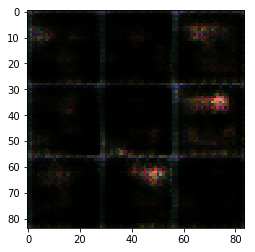

Epoch 1/1... Discriminator Loss: 1.5577... Generator Loss: 0.8011
Epoch 1/1... Discriminator Loss: 0.4269... Generator Loss: 1.2418
Epoch 1/1... Discriminator Loss: 0.2844... Generator Loss: 1.9195
Epoch 1/1... Discriminator Loss: 0.9292... Generator Loss: 0.6377
Epoch 1/1... Discriminator Loss: 0.2542... Generator Loss: 2.6957
Epoch 1/1... Discriminator Loss: 0.2665... Generator Loss: 3.3088
Epoch 1/1... Discriminator Loss: 1.7169... Generator Loss: 6.3266
Epoch 1/1... Discriminator Loss: 1.3464... Generator Loss: 0.7209
Epoch 1/1... Discriminator Loss: 0.9743... Generator Loss: 4.5103
Epoch 1/1... Discriminator Loss: 0.6924... Generator Loss: 1.8903


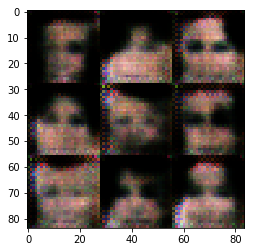

Epoch 1/1... Discriminator Loss: 1.0935... Generator Loss: 1.0445
Epoch 1/1... Discriminator Loss: 2.8041... Generator Loss: 0.0665
Epoch 1/1... Discriminator Loss: 0.9735... Generator Loss: 0.3251
Epoch 1/1... Discriminator Loss: 2.1347... Generator Loss: 0.1654
Epoch 1/1... Discriminator Loss: 0.6255... Generator Loss: 1.7213
Epoch 1/1... Discriminator Loss: 0.4680... Generator Loss: 1.8093
Epoch 1/1... Discriminator Loss: 0.9308... Generator Loss: 0.8910
Epoch 1/1... Discriminator Loss: 0.6147... Generator Loss: 1.3983
Epoch 1/1... Discriminator Loss: 0.7936... Generator Loss: 3.3883
Epoch 1/1... Discriminator Loss: 2.5716... Generator Loss: 0.0941


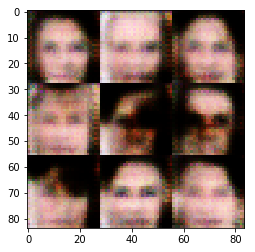

Epoch 1/1... Discriminator Loss: 1.5846... Generator Loss: 1.2020
Epoch 1/1... Discriminator Loss: 3.7888... Generator Loss: 0.0522
Epoch 1/1... Discriminator Loss: 1.0568... Generator Loss: 0.7839
Epoch 1/1... Discriminator Loss: 1.8918... Generator Loss: 0.4028
Epoch 1/1... Discriminator Loss: 1.6978... Generator Loss: 0.4742
Epoch 1/1... Discriminator Loss: 1.4825... Generator Loss: 0.1991
Epoch 1/1... Discriminator Loss: 0.2963... Generator Loss: 3.2081
Epoch 1/1... Discriminator Loss: 1.8335... Generator Loss: 0.6809
Epoch 1/1... Discriminator Loss: 1.0050... Generator Loss: 1.2772
Epoch 1/1... Discriminator Loss: 1.3896... Generator Loss: 4.3886


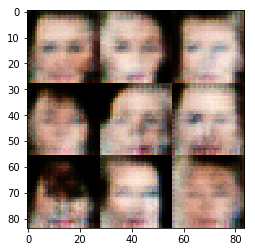

Epoch 1/1... Discriminator Loss: 1.5878... Generator Loss: 0.3625
Epoch 1/1... Discriminator Loss: 0.5416... Generator Loss: 1.3683
Epoch 1/1... Discriminator Loss: 2.2994... Generator Loss: 1.2406
Epoch 1/1... Discriminator Loss: 2.0429... Generator Loss: 0.6210
Epoch 1/1... Discriminator Loss: 1.6037... Generator Loss: 0.3087
Epoch 1/1... Discriminator Loss: 0.2349... Generator Loss: 4.6031
Epoch 1/1... Discriminator Loss: 1.3775... Generator Loss: 0.5211
Epoch 1/1... Discriminator Loss: 1.4659... Generator Loss: 0.6971
Epoch 1/1... Discriminator Loss: 0.7208... Generator Loss: 1.3624
Epoch 1/1... Discriminator Loss: 0.5793... Generator Loss: 2.1330


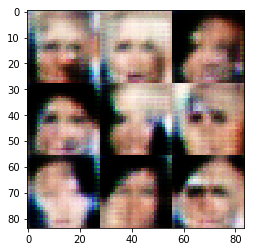

Epoch 1/1... Discriminator Loss: 2.8966... Generator Loss: 0.1627
Epoch 1/1... Discriminator Loss: 1.4245... Generator Loss: 0.4367
Epoch 1/1... Discriminator Loss: 0.5928... Generator Loss: 3.5942
Epoch 1/1... Discriminator Loss: 2.1024... Generator Loss: 1.4205
Epoch 1/1... Discriminator Loss: 1.0755... Generator Loss: 1.6205
Epoch 1/1... Discriminator Loss: 0.3622... Generator Loss: 7.8700
Epoch 1/1... Discriminator Loss: 1.1783... Generator Loss: 2.0974
Epoch 1/1... Discriminator Loss: 1.8546... Generator Loss: 0.3511
Epoch 1/1... Discriminator Loss: 1.9484... Generator Loss: 0.4403
Epoch 1/1... Discriminator Loss: 1.4404... Generator Loss: 0.5724


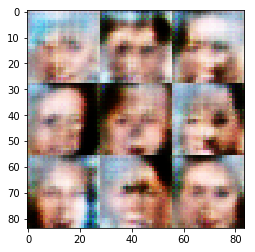

Epoch 1/1... Discriminator Loss: 0.7079... Generator Loss: 0.9763
Epoch 1/1... Discriminator Loss: 0.9479... Generator Loss: 4.9360
Epoch 1/1... Discriminator Loss: 0.6830... Generator Loss: 1.2915
Epoch 1/1... Discriminator Loss: 0.5139... Generator Loss: 2.6160
Epoch 1/1... Discriminator Loss: 0.3202... Generator Loss: 2.3906
Epoch 1/1... Discriminator Loss: 1.5501... Generator Loss: 0.6967
Epoch 1/1... Discriminator Loss: 1.0820... Generator Loss: 1.0617
Epoch 1/1... Discriminator Loss: 0.9206... Generator Loss: 2.3249
Epoch 1/1... Discriminator Loss: 1.9567... Generator Loss: 0.2688
Epoch 1/1... Discriminator Loss: 0.3977... Generator Loss: 3.2202


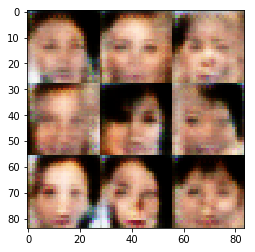

Epoch 1/1... Discriminator Loss: 2.2075... Generator Loss: 0.3248
Epoch 1/1... Discriminator Loss: 0.6676... Generator Loss: 2.0615
Epoch 1/1... Discriminator Loss: 0.9132... Generator Loss: 1.5735
Epoch 1/1... Discriminator Loss: 1.2061... Generator Loss: 0.7819
Epoch 1/1... Discriminator Loss: 1.1156... Generator Loss: 2.2510
Epoch 1/1... Discriminator Loss: 1.8252... Generator Loss: 0.3995
Epoch 1/1... Discriminator Loss: 0.8192... Generator Loss: 2.5977
Epoch 1/1... Discriminator Loss: 1.3456... Generator Loss: 0.6566
Epoch 1/1... Discriminator Loss: 4.4842... Generator Loss: 3.5030
Epoch 1/1... Discriminator Loss: 2.0783... Generator Loss: 0.4075


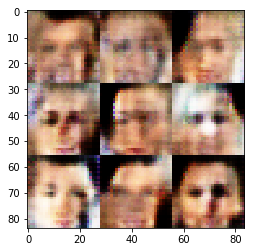

Epoch 1/1... Discriminator Loss: 1.5203... Generator Loss: 0.8341
Epoch 1/1... Discriminator Loss: 0.9245... Generator Loss: 1.7061
Epoch 1/1... Discriminator Loss: 2.9141... Generator Loss: 0.0797
Epoch 1/1... Discriminator Loss: 0.8061... Generator Loss: 1.2324
Epoch 1/1... Discriminator Loss: 1.4637... Generator Loss: 0.6929
Epoch 1/1... Discriminator Loss: 1.5076... Generator Loss: 0.2472
Epoch 1/1... Discriminator Loss: 0.7205... Generator Loss: 1.9302
Epoch 1/1... Discriminator Loss: 1.0311... Generator Loss: 0.6384
Epoch 1/1... Discriminator Loss: 0.2258... Generator Loss: 2.2644
Epoch 1/1... Discriminator Loss: 2.3999... Generator Loss: 0.2551


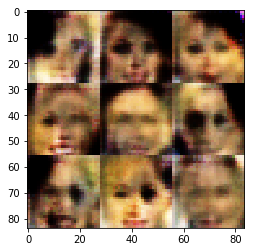

Epoch 1/1... Discriminator Loss: 1.0231... Generator Loss: 1.2133
Epoch 1/1... Discriminator Loss: 0.5799... Generator Loss: 1.5963
Epoch 1/1... Discriminator Loss: 1.1368... Generator Loss: 1.0321
Epoch 1/1... Discriminator Loss: 0.7408... Generator Loss: 1.2475
Epoch 1/1... Discriminator Loss: 2.1635... Generator Loss: 0.5108
Epoch 1/1... Discriminator Loss: 0.9147... Generator Loss: 2.1903
Epoch 1/1... Discriminator Loss: 0.9186... Generator Loss: 0.7412
Epoch 1/1... Discriminator Loss: 1.9345... Generator Loss: 0.5500
Epoch 1/1... Discriminator Loss: 1.6590... Generator Loss: 0.7214
Epoch 1/1... Discriminator Loss: 2.2768... Generator Loss: 0.1726


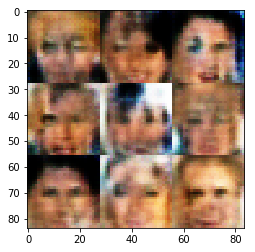

Epoch 1/1... Discriminator Loss: 2.3597... Generator Loss: 0.3850
Epoch 1/1... Discriminator Loss: 1.4201... Generator Loss: 0.5568
Epoch 1/1... Discriminator Loss: 0.9641... Generator Loss: 0.9164
Epoch 1/1... Discriminator Loss: 2.3761... Generator Loss: 0.9956
Epoch 1/1... Discriminator Loss: 2.3084... Generator Loss: 0.1811
Epoch 1/1... Discriminator Loss: 0.7902... Generator Loss: 4.0917
Epoch 1/1... Discriminator Loss: 0.4604... Generator Loss: 1.9239
Epoch 1/1... Discriminator Loss: 0.7517... Generator Loss: 1.3076
Epoch 1/1... Discriminator Loss: 1.2739... Generator Loss: 1.0553
Epoch 1/1... Discriminator Loss: 0.6421... Generator Loss: 3.0743


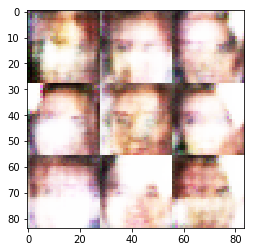

Epoch 1/1... Discriminator Loss: 0.2989... Generator Loss: 3.5061
Epoch 1/1... Discriminator Loss: 0.5357... Generator Loss: 2.1195
Epoch 1/1... Discriminator Loss: 0.8198... Generator Loss: 2.4034
Epoch 1/1... Discriminator Loss: 4.9574... Generator Loss: 4.8465
Epoch 1/1... Discriminator Loss: 1.5715... Generator Loss: 0.5509
Epoch 1/1... Discriminator Loss: 1.1804... Generator Loss: 1.0281
Epoch 1/1... Discriminator Loss: 2.0919... Generator Loss: 0.4810
Epoch 1/1... Discriminator Loss: 1.0340... Generator Loss: 0.9485
Epoch 1/1... Discriminator Loss: 1.8309... Generator Loss: 0.3830
Epoch 1/1... Discriminator Loss: 1.4779... Generator Loss: 0.6257


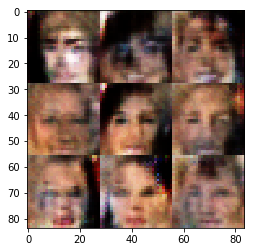

Epoch 1/1... Discriminator Loss: 1.4638... Generator Loss: 1.6169
Epoch 1/1... Discriminator Loss: 2.2324... Generator Loss: 0.2578
Epoch 1/1... Discriminator Loss: 0.8078... Generator Loss: 1.1006
Epoch 1/1... Discriminator Loss: 1.8402... Generator Loss: 0.4521
Epoch 1/1... Discriminator Loss: 0.9044... Generator Loss: 0.8463
Epoch 1/1... Discriminator Loss: 0.8457... Generator Loss: 1.3557
Epoch 1/1... Discriminator Loss: 1.1798... Generator Loss: 0.7008
Epoch 1/1... Discriminator Loss: 1.1935... Generator Loss: 1.9445
Epoch 1/1... Discriminator Loss: 1.0585... Generator Loss: 1.0333
Epoch 1/1... Discriminator Loss: 0.4562... Generator Loss: 2.6008


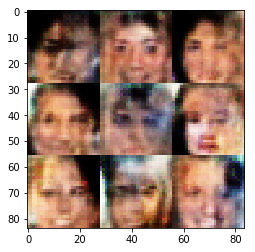

Epoch 1/1... Discriminator Loss: 1.6592... Generator Loss: 1.8448
Epoch 1/1... Discriminator Loss: 1.2561... Generator Loss: 0.5876
Epoch 1/1... Discriminator Loss: 1.2858... Generator Loss: 0.8301
Epoch 1/1... Discriminator Loss: 1.3715... Generator Loss: 0.8822
Epoch 1/1... Discriminator Loss: 1.7222... Generator Loss: 0.4360
Epoch 1/1... Discriminator Loss: 1.6040... Generator Loss: 0.6599
Epoch 1/1... Discriminator Loss: 0.9992... Generator Loss: 1.7711
Epoch 1/1... Discriminator Loss: 1.7029... Generator Loss: 0.7144
Epoch 1/1... Discriminator Loss: 1.2919... Generator Loss: 1.2871
Epoch 1/1... Discriminator Loss: 1.5549... Generator Loss: 0.6897


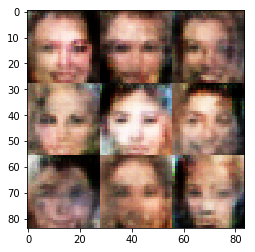

Epoch 1/1... Discriminator Loss: 1.8152... Generator Loss: 0.7797
Epoch 1/1... Discriminator Loss: 0.4816... Generator Loss: 2.7730
Epoch 1/1... Discriminator Loss: 1.0341... Generator Loss: 1.1539
Epoch 1/1... Discriminator Loss: 1.1942... Generator Loss: 3.1480
Epoch 1/1... Discriminator Loss: 1.1568... Generator Loss: 0.8484
Epoch 1/1... Discriminator Loss: 1.7744... Generator Loss: 0.6371
Epoch 1/1... Discriminator Loss: 1.3546... Generator Loss: 0.4879
Epoch 1/1... Discriminator Loss: 1.5347... Generator Loss: 0.3310
Epoch 1/1... Discriminator Loss: 1.1442... Generator Loss: 0.4631
Epoch 1/1... Discriminator Loss: 2.4643... Generator Loss: 0.2806


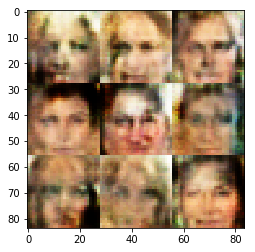

Epoch 1/1... Discriminator Loss: 1.2309... Generator Loss: 0.6036
Epoch 1/1... Discriminator Loss: 1.5719... Generator Loss: 1.2574
Epoch 1/1... Discriminator Loss: 2.0383... Generator Loss: 0.7191
Epoch 1/1... Discriminator Loss: 1.9371... Generator Loss: 0.8600
Epoch 1/1... Discriminator Loss: 0.7831... Generator Loss: 1.3891
Epoch 1/1... Discriminator Loss: 1.0487... Generator Loss: 0.7995
Epoch 1/1... Discriminator Loss: 1.0810... Generator Loss: 1.0087
Epoch 1/1... Discriminator Loss: 1.3613... Generator Loss: 1.1489
Epoch 1/1... Discriminator Loss: 0.6828... Generator Loss: 1.7258
Epoch 1/1... Discriminator Loss: 1.0120... Generator Loss: 1.2594


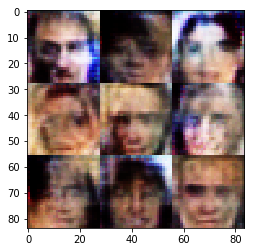

Epoch 1/1... Discriminator Loss: 2.6061... Generator Loss: 0.1228
Epoch 1/1... Discriminator Loss: 0.7869... Generator Loss: 1.3407
Epoch 1/1... Discriminator Loss: 0.9200... Generator Loss: 0.7385
Epoch 1/1... Discriminator Loss: 0.7091... Generator Loss: 1.4669
Epoch 1/1... Discriminator Loss: 2.4493... Generator Loss: 0.1367
Epoch 1/1... Discriminator Loss: 1.2345... Generator Loss: 0.7517
Epoch 1/1... Discriminator Loss: 2.4705... Generator Loss: 0.7150
Epoch 1/1... Discriminator Loss: 1.5228... Generator Loss: 0.9662
Epoch 1/1... Discriminator Loss: 1.1853... Generator Loss: 0.7818
Epoch 1/1... Discriminator Loss: 1.6994... Generator Loss: 0.4933


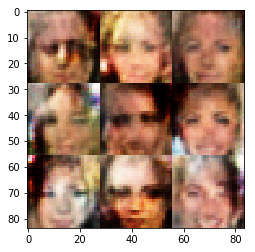

Epoch 1/1... Discriminator Loss: 1.3470... Generator Loss: 0.5788
Epoch 1/1... Discriminator Loss: 1.3545... Generator Loss: 0.4143
Epoch 1/1... Discriminator Loss: 1.0673... Generator Loss: 0.8672
Epoch 1/1... Discriminator Loss: 1.7193... Generator Loss: 0.4712
Epoch 1/1... Discriminator Loss: 0.9694... Generator Loss: 1.0259
Epoch 1/1... Discriminator Loss: 0.9837... Generator Loss: 1.0221
Epoch 1/1... Discriminator Loss: 1.9525... Generator Loss: 0.2405
Epoch 1/1... Discriminator Loss: 0.9671... Generator Loss: 0.4614
Epoch 1/1... Discriminator Loss: 1.6440... Generator Loss: 0.6509
Epoch 1/1... Discriminator Loss: 0.8315... Generator Loss: 1.3852


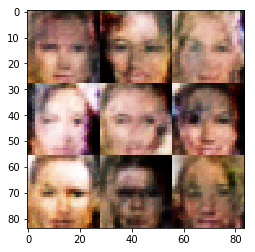

Epoch 1/1... Discriminator Loss: 1.7676... Generator Loss: 1.1010
Epoch 1/1... Discriminator Loss: 0.8056... Generator Loss: 1.3985
Epoch 1/1... Discriminator Loss: 1.0747... Generator Loss: 0.7053
Epoch 1/1... Discriminator Loss: 1.8180... Generator Loss: 1.1420
Epoch 1/1... Discriminator Loss: 1.1952... Generator Loss: 1.1351
Epoch 1/1... Discriminator Loss: 1.8903... Generator Loss: 0.6110
Epoch 1/1... Discriminator Loss: 1.7183... Generator Loss: 0.3328
Epoch 1/1... Discriminator Loss: 1.8003... Generator Loss: 0.4960
Epoch 1/1... Discriminator Loss: 1.8789... Generator Loss: 0.5718
Epoch 1/1... Discriminator Loss: 1.6052... Generator Loss: 0.5671


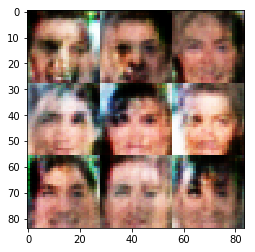

Epoch 1/1... Discriminator Loss: 1.2632... Generator Loss: 0.8109
Epoch 1/1... Discriminator Loss: 1.7783... Generator Loss: 0.6957
Epoch 1/1... Discriminator Loss: 0.9999... Generator Loss: 0.8148
Epoch 1/1... Discriminator Loss: 1.1796... Generator Loss: 0.6177
Epoch 1/1... Discriminator Loss: 2.5402... Generator Loss: 0.2292
Epoch 1/1... Discriminator Loss: 1.0979... Generator Loss: 0.8231
Epoch 1/1... Discriminator Loss: 2.4005... Generator Loss: 0.4183
Epoch 1/1... Discriminator Loss: 0.5799... Generator Loss: 2.6256
Epoch 1/1... Discriminator Loss: 1.9703... Generator Loss: 0.6227
Epoch 1/1... Discriminator Loss: 0.5116... Generator Loss: 2.9793


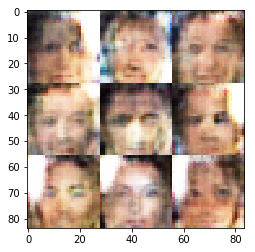

Epoch 1/1... Discriminator Loss: 0.8100... Generator Loss: 1.2279
Epoch 1/1... Discriminator Loss: 1.8216... Generator Loss: 0.2751
Epoch 1/1... Discriminator Loss: 0.3116... Generator Loss: 2.6748
Epoch 1/1... Discriminator Loss: 2.0376... Generator Loss: 0.3402
Epoch 1/1... Discriminator Loss: 0.9858... Generator Loss: 2.3925
Epoch 1/1... Discriminator Loss: 1.7815... Generator Loss: 0.5101
Epoch 1/1... Discriminator Loss: 0.5227... Generator Loss: 2.5288
Epoch 1/1... Discriminator Loss: 0.6632... Generator Loss: 1.0457
Epoch 1/1... Discriminator Loss: 1.8417... Generator Loss: 1.5393
Epoch 1/1... Discriminator Loss: 1.5818... Generator Loss: 2.1290


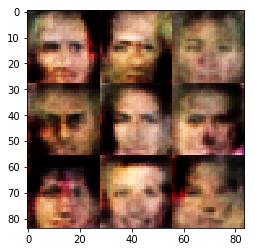

Epoch 1/1... Discriminator Loss: 0.6923... Generator Loss: 2.3173
Epoch 1/1... Discriminator Loss: 1.1776... Generator Loss: 1.1466
Epoch 1/1... Discriminator Loss: 1.6946... Generator Loss: 0.5094
Epoch 1/1... Discriminator Loss: 1.2590... Generator Loss: 0.6194
Epoch 1/1... Discriminator Loss: 0.9343... Generator Loss: 1.2284
Epoch 1/1... Discriminator Loss: 1.3292... Generator Loss: 1.0429
Epoch 1/1... Discriminator Loss: 1.5659... Generator Loss: 2.0177
Epoch 1/1... Discriminator Loss: 1.4469... Generator Loss: 0.8849
Epoch 1/1... Discriminator Loss: 1.4840... Generator Loss: 0.5526
Epoch 1/1... Discriminator Loss: 0.9374... Generator Loss: 1.6668


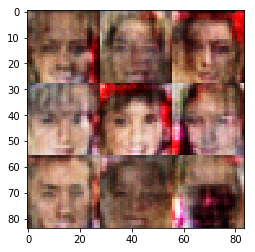

Epoch 1/1... Discriminator Loss: 1.1116... Generator Loss: 0.6111
Epoch 1/1... Discriminator Loss: 1.1339... Generator Loss: 1.8983
Epoch 1/1... Discriminator Loss: 1.5352... Generator Loss: 0.7375
Epoch 1/1... Discriminator Loss: 0.9519... Generator Loss: 1.4432
Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 0.6775
Epoch 1/1... Discriminator Loss: 1.2702... Generator Loss: 0.6970
Epoch 1/1... Discriminator Loss: 1.1907... Generator Loss: 0.8041
Epoch 1/1... Discriminator Loss: 1.4121... Generator Loss: 0.6997
Epoch 1/1... Discriminator Loss: 1.6933... Generator Loss: 0.4671
Epoch 1/1... Discriminator Loss: 1.6384... Generator Loss: 0.6319


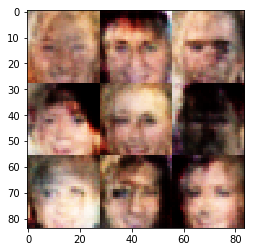

Epoch 1/1... Discriminator Loss: 1.4791... Generator Loss: 0.5225
Epoch 1/1... Discriminator Loss: 1.7869... Generator Loss: 0.6991
Epoch 1/1... Discriminator Loss: 1.4965... Generator Loss: 0.4705
Epoch 1/1... Discriminator Loss: 1.4086... Generator Loss: 0.8477
Epoch 1/1... Discriminator Loss: 2.2654... Generator Loss: 0.5535
Epoch 1/1... Discriminator Loss: 1.5051... Generator Loss: 0.5064
Epoch 1/1... Discriminator Loss: 1.4398... Generator Loss: 0.6522
Epoch 1/1... Discriminator Loss: 1.9562... Generator Loss: 0.3077
Epoch 1/1... Discriminator Loss: 0.9377... Generator Loss: 1.3194
Epoch 1/1... Discriminator Loss: 1.4649... Generator Loss: 0.5153


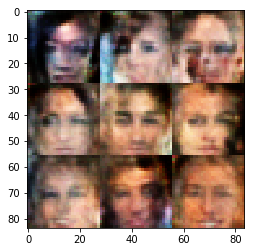

Epoch 1/1... Discriminator Loss: 1.8226... Generator Loss: 1.4715
Epoch 1/1... Discriminator Loss: 1.7042... Generator Loss: 0.9689
Epoch 1/1... Discriminator Loss: 1.9605... Generator Loss: 0.2188
Epoch 1/1... Discriminator Loss: 1.2887... Generator Loss: 0.4979
Epoch 1/1... Discriminator Loss: 1.7777... Generator Loss: 0.3654
Epoch 1/1... Discriminator Loss: 0.6420... Generator Loss: 2.2978
Epoch 1/1... Discriminator Loss: 1.8315... Generator Loss: 0.6819
Epoch 1/1... Discriminator Loss: 0.6767... Generator Loss: 1.2374
Epoch 1/1... Discriminator Loss: 0.9868... Generator Loss: 1.5392
Epoch 1/1... Discriminator Loss: 2.1020... Generator Loss: 0.9307


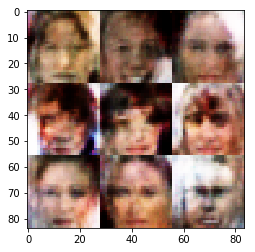

Epoch 1/1... Discriminator Loss: 1.8293... Generator Loss: 0.4711
Epoch 1/1... Discriminator Loss: 1.5486... Generator Loss: 0.6791
Epoch 1/1... Discriminator Loss: 0.9446... Generator Loss: 1.4581
Epoch 1/1... Discriminator Loss: 1.4497... Generator Loss: 0.6968
Epoch 1/1... Discriminator Loss: 0.7271... Generator Loss: 1.4764
Epoch 1/1... Discriminator Loss: 1.6273... Generator Loss: 1.0526
Epoch 1/1... Discriminator Loss: 1.0869... Generator Loss: 1.0949
Epoch 1/1... Discriminator Loss: 2.4141... Generator Loss: 0.3574
Epoch 1/1... Discriminator Loss: 1.5775... Generator Loss: 0.9035
Epoch 1/1... Discriminator Loss: 2.2101... Generator Loss: 1.5057


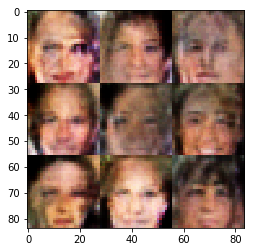

Epoch 1/1... Discriminator Loss: 0.5258... Generator Loss: 5.0178
Epoch 1/1... Discriminator Loss: 1.4451... Generator Loss: 0.8299
Epoch 1/1... Discriminator Loss: 2.2920... Generator Loss: 0.3903
Epoch 1/1... Discriminator Loss: 1.3590... Generator Loss: 0.4173
Epoch 1/1... Discriminator Loss: 1.8949... Generator Loss: 0.6442
Epoch 1/1... Discriminator Loss: 1.7419... Generator Loss: 0.3494
Epoch 1/1... Discriminator Loss: 1.0140... Generator Loss: 1.6213
Epoch 1/1... Discriminator Loss: 1.2650... Generator Loss: 0.6988
Epoch 1/1... Discriminator Loss: 1.6021... Generator Loss: 0.8079
Epoch 1/1... Discriminator Loss: 1.5197... Generator Loss: 0.2891


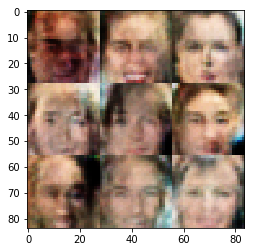

Epoch 1/1... Discriminator Loss: 2.0241... Generator Loss: 0.5887
Epoch 1/1... Discriminator Loss: 1.6371... Generator Loss: 0.7333
Epoch 1/1... Discriminator Loss: 1.3471... Generator Loss: 1.3812
Epoch 1/1... Discriminator Loss: 2.2319... Generator Loss: 0.2660
Epoch 1/1... Discriminator Loss: 2.1320... Generator Loss: 0.5027
Epoch 1/1... Discriminator Loss: 1.7518... Generator Loss: 0.3362
Epoch 1/1... Discriminator Loss: 1.1102... Generator Loss: 0.5459
Epoch 1/1... Discriminator Loss: 1.8425... Generator Loss: 0.6169
Epoch 1/1... Discriminator Loss: 1.4217... Generator Loss: 1.3752
Epoch 1/1... Discriminator Loss: 2.1911... Generator Loss: 0.5998


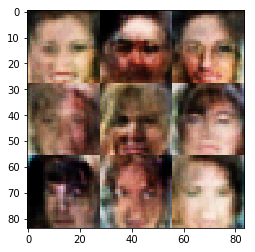

Epoch 1/1... Discriminator Loss: 1.6312... Generator Loss: 0.3306
Epoch 1/1... Discriminator Loss: 1.7347... Generator Loss: 0.7780
Epoch 1/1... Discriminator Loss: 1.8778... Generator Loss: 0.3393
Epoch 1/1... Discriminator Loss: 1.3677... Generator Loss: 0.4062
Epoch 1/1... Discriminator Loss: 1.2100... Generator Loss: 0.5775
Epoch 1/1... Discriminator Loss: 2.0295... Generator Loss: 0.8062
Epoch 1/1... Discriminator Loss: 0.7857... Generator Loss: 0.8739
Epoch 1/1... Discriminator Loss: 1.9805... Generator Loss: 0.4530
Epoch 1/1... Discriminator Loss: 1.2072... Generator Loss: 0.6380
Epoch 1/1... Discriminator Loss: 2.2213... Generator Loss: 0.2987


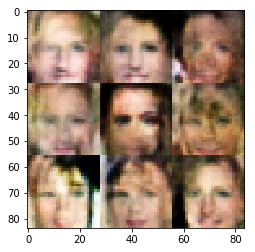

Epoch 1/1... Discriminator Loss: 2.0929... Generator Loss: 0.8064
Epoch 1/1... Discriminator Loss: 1.0554... Generator Loss: 0.5430
Epoch 1/1... Discriminator Loss: 1.0785... Generator Loss: 1.3820
Epoch 1/1... Discriminator Loss: 1.3435... Generator Loss: 0.4837
Epoch 1/1... Discriminator Loss: 1.1261... Generator Loss: 0.6574
Epoch 1/1... Discriminator Loss: 1.1975... Generator Loss: 1.8418
Epoch 1/1... Discriminator Loss: 1.5243... Generator Loss: 0.3135
Epoch 1/1... Discriminator Loss: 1.0208... Generator Loss: 0.9466
Epoch 1/1... Discriminator Loss: 1.5510... Generator Loss: 0.7628
Epoch 1/1... Discriminator Loss: 1.2758... Generator Loss: 0.4897


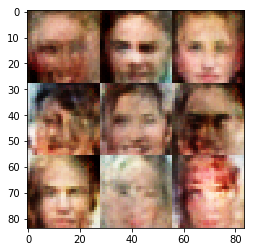

Epoch 1/1... Discriminator Loss: 0.8548... Generator Loss: 1.3966
Epoch 1/1... Discriminator Loss: 0.9531... Generator Loss: 1.7621
Epoch 1/1... Discriminator Loss: 1.1547... Generator Loss: 0.5899
Epoch 1/1... Discriminator Loss: 0.7757... Generator Loss: 2.6469
Epoch 1/1... Discriminator Loss: 2.9602... Generator Loss: 0.2145
Epoch 1/1... Discriminator Loss: 1.3110... Generator Loss: 0.7506
Epoch 1/1... Discriminator Loss: 2.1537... Generator Loss: 0.3116
Epoch 1/1... Discriminator Loss: 2.1278... Generator Loss: 0.5208
Epoch 1/1... Discriminator Loss: 1.4597... Generator Loss: 0.3202
Epoch 1/1... Discriminator Loss: 1.5110... Generator Loss: 0.4038


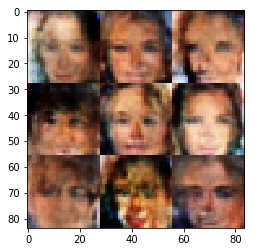

Epoch 1/1... Discriminator Loss: 1.1917... Generator Loss: 0.8789
Epoch 1/1... Discriminator Loss: 1.3986... Generator Loss: 0.6630
Epoch 1/1... Discriminator Loss: 1.3857... Generator Loss: 1.3259
Epoch 1/1... Discriminator Loss: 1.4591... Generator Loss: 0.9231
Epoch 1/1... Discriminator Loss: 1.3366... Generator Loss: 0.7176
Epoch 1/1... Discriminator Loss: 0.9897... Generator Loss: 1.1789
Epoch 1/1... Discriminator Loss: 1.2027... Generator Loss: 1.6271
Epoch 1/1... Discriminator Loss: 1.8859... Generator Loss: 0.5519
Epoch 1/1... Discriminator Loss: 1.9719... Generator Loss: 0.5189
Epoch 1/1... Discriminator Loss: 1.6387... Generator Loss: 0.6152


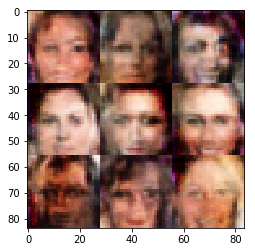

Epoch 1/1... Discriminator Loss: 2.2289... Generator Loss: 1.4394
Epoch 1/1... Discriminator Loss: 3.0862... Generator Loss: 0.1938
Epoch 1/1... Discriminator Loss: 2.1253... Generator Loss: 0.4717
Epoch 1/1... Discriminator Loss: 1.1147... Generator Loss: 0.4243
Epoch 1/1... Discriminator Loss: 1.4958... Generator Loss: 0.6250
Epoch 1/1... Discriminator Loss: 1.0258... Generator Loss: 0.6144
Epoch 1/1... Discriminator Loss: 1.4780... Generator Loss: 1.1547
Epoch 1/1... Discriminator Loss: 2.0688... Generator Loss: 0.5164
Epoch 1/1... Discriminator Loss: 1.2320... Generator Loss: 0.8650
Epoch 1/1... Discriminator Loss: 1.2054... Generator Loss: 0.6579


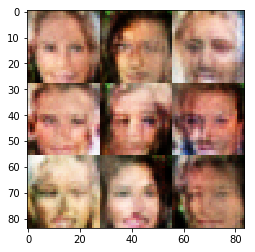

Epoch 1/1... Discriminator Loss: 1.4873... Generator Loss: 0.8926
Epoch 1/1... Discriminator Loss: 1.7653... Generator Loss: 0.7244
Epoch 1/1... Discriminator Loss: 0.8587... Generator Loss: 1.1915
Epoch 1/1... Discriminator Loss: 2.5571... Generator Loss: 0.3639
Epoch 1/1... Discriminator Loss: 1.3537... Generator Loss: 0.7150
Epoch 1/1... Discriminator Loss: 0.9725... Generator Loss: 1.0240
Epoch 1/1... Discriminator Loss: 2.0398... Generator Loss: 0.1452
Epoch 1/1... Discriminator Loss: 1.4478... Generator Loss: 1.1994
Epoch 1/1... Discriminator Loss: 1.8973... Generator Loss: 0.6661
Epoch 1/1... Discriminator Loss: 1.8478... Generator Loss: 0.6059


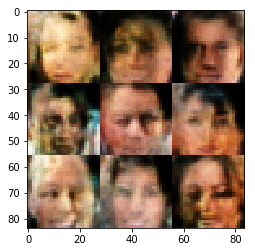

Epoch 1/1... Discriminator Loss: 1.5733... Generator Loss: 0.4886
Epoch 1/1... Discriminator Loss: 1.5700... Generator Loss: 0.4377
Epoch 1/1... Discriminator Loss: 1.1165... Generator Loss: 1.5391
Epoch 1/1... Discriminator Loss: 1.0165... Generator Loss: 1.6253
Epoch 1/1... Discriminator Loss: 1.4524... Generator Loss: 0.5371
Epoch 1/1... Discriminator Loss: 1.6931... Generator Loss: 0.6846
Epoch 1/1... Discriminator Loss: 1.3759... Generator Loss: 0.8053
Epoch 1/1... Discriminator Loss: 0.9535... Generator Loss: 2.6480
Epoch 1/1... Discriminator Loss: 1.2949... Generator Loss: 0.8620
Epoch 1/1... Discriminator Loss: 1.4299... Generator Loss: 0.7587


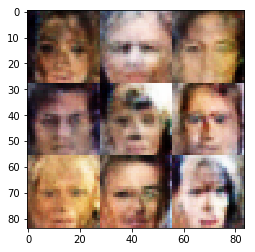

Epoch 1/1... Discriminator Loss: 1.2919... Generator Loss: 0.8610
Epoch 1/1... Discriminator Loss: 1.3556... Generator Loss: 0.5462
Epoch 1/1... Discriminator Loss: 1.0777... Generator Loss: 0.8662
Epoch 1/1... Discriminator Loss: 1.6974... Generator Loss: 0.7368
Epoch 1/1... Discriminator Loss: 1.3454... Generator Loss: 0.9795
Epoch 1/1... Discriminator Loss: 2.2046... Generator Loss: 0.3918
Epoch 1/1... Discriminator Loss: 1.6074... Generator Loss: 0.6195
Epoch 1/1... Discriminator Loss: 1.3280... Generator Loss: 0.4731
Epoch 1/1... Discriminator Loss: 1.3007... Generator Loss: 0.9661
Epoch 1/1... Discriminator Loss: 1.6519... Generator Loss: 0.8480


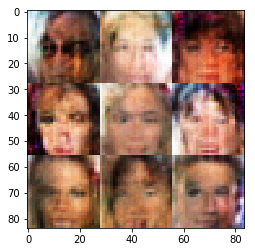

Epoch 1/1... Discriminator Loss: 2.0787... Generator Loss: 0.3939
Epoch 1/1... Discriminator Loss: 1.7956... Generator Loss: 0.3861
Epoch 1/1... Discriminator Loss: 1.5987... Generator Loss: 1.4599
Epoch 1/1... Discriminator Loss: 2.1443... Generator Loss: 0.3350
Epoch 1/1... Discriminator Loss: 0.9515... Generator Loss: 1.9971
Epoch 1/1... Discriminator Loss: 0.9823... Generator Loss: 1.2589
Epoch 1/1... Discriminator Loss: 1.3819... Generator Loss: 0.6565
Epoch 1/1... Discriminator Loss: 1.5640... Generator Loss: 0.7476
Epoch 1/1... Discriminator Loss: 1.7593... Generator Loss: 0.7029
Epoch 1/1... Discriminator Loss: 1.4010... Generator Loss: 0.8095


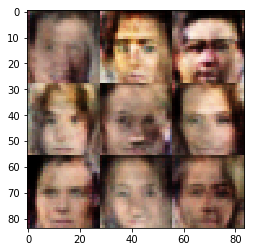

Epoch 1/1... Discriminator Loss: 1.1666... Generator Loss: 0.4864
Epoch 1/1... Discriminator Loss: 1.6685... Generator Loss: 0.8076
Epoch 1/1... Discriminator Loss: 1.6462... Generator Loss: 0.6906
Epoch 1/1... Discriminator Loss: 1.4330... Generator Loss: 0.6256
Epoch 1/1... Discriminator Loss: 1.8583... Generator Loss: 0.6922
Epoch 1/1... Discriminator Loss: 1.6015... Generator Loss: 0.5339
Epoch 1/1... Discriminator Loss: 0.9664... Generator Loss: 1.3020
Epoch 1/1... Discriminator Loss: 1.3803... Generator Loss: 1.2723
Epoch 1/1... Discriminator Loss: 1.7069... Generator Loss: 0.5501
Epoch 1/1... Discriminator Loss: 1.3263... Generator Loss: 0.6042


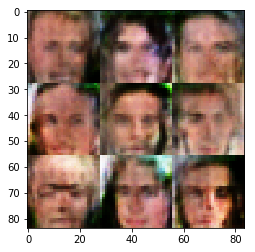

Epoch 1/1... Discriminator Loss: 2.1723... Generator Loss: 0.5339
Epoch 1/1... Discriminator Loss: 0.9338... Generator Loss: 2.0575
Epoch 1/1... Discriminator Loss: 1.2463... Generator Loss: 0.8925
Epoch 1/1... Discriminator Loss: 1.3964... Generator Loss: 1.1640
Epoch 1/1... Discriminator Loss: 1.9347... Generator Loss: 0.2592
Epoch 1/1... Discriminator Loss: 1.4895... Generator Loss: 0.9602
Epoch 1/1... Discriminator Loss: 1.2340... Generator Loss: 0.4485
Epoch 1/1... Discriminator Loss: 2.1392... Generator Loss: 0.6928
Epoch 1/1... Discriminator Loss: 1.0680... Generator Loss: 0.7841
Epoch 1/1... Discriminator Loss: 1.6249... Generator Loss: 0.8270


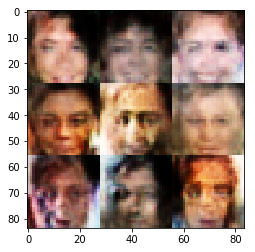

Epoch 1/1... Discriminator Loss: 1.4021... Generator Loss: 1.4021
Epoch 1/1... Discriminator Loss: 2.1248... Generator Loss: 0.7508
Epoch 1/1... Discriminator Loss: 1.3221... Generator Loss: 0.5584
Epoch 1/1... Discriminator Loss: 1.0599... Generator Loss: 0.8656
Epoch 1/1... Discriminator Loss: 1.8440... Generator Loss: 0.3393
Epoch 1/1... Discriminator Loss: 1.5234... Generator Loss: 0.7499
Epoch 1/1... Discriminator Loss: 2.0691... Generator Loss: 0.2930
Epoch 1/1... Discriminator Loss: 2.3755... Generator Loss: 0.5027
Epoch 1/1... Discriminator Loss: 1.4817... Generator Loss: 0.8287
Epoch 1/1... Discriminator Loss: 1.2376... Generator Loss: 0.4408


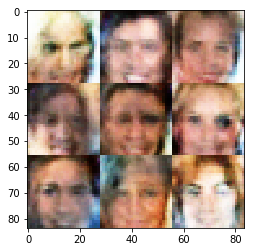

Epoch 1/1... Discriminator Loss: 2.3173... Generator Loss: 0.2432
Epoch 1/1... Discriminator Loss: 1.2538... Generator Loss: 1.5268
Epoch 1/1... Discriminator Loss: 1.8228... Generator Loss: 0.3826
Epoch 1/1... Discriminator Loss: 1.3967... Generator Loss: 1.0074
Epoch 1/1... Discriminator Loss: 1.7612... Generator Loss: 0.7529
Epoch 1/1... Discriminator Loss: 1.4181... Generator Loss: 0.7328
Epoch 1/1... Discriminator Loss: 1.3790... Generator Loss: 0.6871
Epoch 1/1... Discriminator Loss: 0.8299... Generator Loss: 1.3091
Epoch 1/1... Discriminator Loss: 1.5367... Generator Loss: 0.9388
Epoch 1/1... Discriminator Loss: 1.6038... Generator Loss: 1.6037


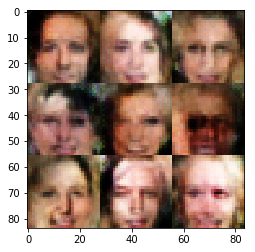

Epoch 1/1... Discriminator Loss: 1.9246... Generator Loss: 0.3585
Epoch 1/1... Discriminator Loss: 1.2436... Generator Loss: 1.8128
Epoch 1/1... Discriminator Loss: 1.6070... Generator Loss: 1.1859
Epoch 1/1... Discriminator Loss: 1.7057... Generator Loss: 0.6810
Epoch 1/1... Discriminator Loss: 0.8579... Generator Loss: 2.2363
Epoch 1/1... Discriminator Loss: 1.9873... Generator Loss: 0.2401
Epoch 1/1... Discriminator Loss: 1.5034... Generator Loss: 0.3323
Epoch 1/1... Discriminator Loss: 2.3723... Generator Loss: 0.5833
Epoch 1/1... Discriminator Loss: 1.5065... Generator Loss: 0.4254
Epoch 1/1... Discriminator Loss: 1.8271... Generator Loss: 0.3374


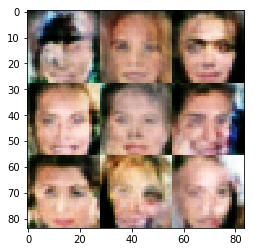

Epoch 1/1... Discriminator Loss: 0.8796... Generator Loss: 1.5701
Epoch 1/1... Discriminator Loss: 2.4585... Generator Loss: 0.3554
Epoch 1/1... Discriminator Loss: 2.0211... Generator Loss: 0.5759
Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 0.9666
Epoch 1/1... Discriminator Loss: 1.3345... Generator Loss: 1.0251
Epoch 1/1... Discriminator Loss: 1.2819... Generator Loss: 0.5494
Epoch 1/1... Discriminator Loss: 1.4318... Generator Loss: 0.4000
Epoch 1/1... Discriminator Loss: 1.9494... Generator Loss: 0.4960
Epoch 1/1... Discriminator Loss: 1.5152... Generator Loss: 0.9410
Epoch 1/1... Discriminator Loss: 1.4245... Generator Loss: 0.4260


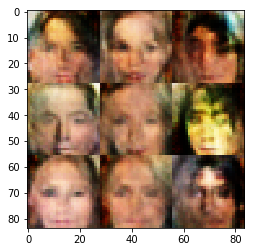

Epoch 1/1... Discriminator Loss: 0.9990... Generator Loss: 1.1976
Epoch 1/1... Discriminator Loss: 1.5162... Generator Loss: 0.5180
Epoch 1/1... Discriminator Loss: 1.1496... Generator Loss: 0.7108
Epoch 1/1... Discriminator Loss: 1.5712... Generator Loss: 0.5374
Epoch 1/1... Discriminator Loss: 1.7603... Generator Loss: 0.5308
Epoch 1/1... Discriminator Loss: 1.5100... Generator Loss: 0.5154
Epoch 1/1... Discriminator Loss: 1.4458... Generator Loss: 0.6675
Epoch 1/1... Discriminator Loss: 0.8645... Generator Loss: 1.4347
Epoch 1/1... Discriminator Loss: 0.8106... Generator Loss: 1.0574
Epoch 1/1... Discriminator Loss: 1.9761... Generator Loss: 0.5853


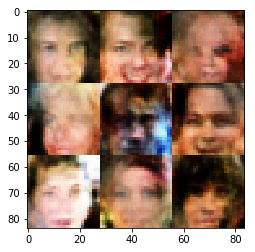

Epoch 1/1... Discriminator Loss: 1.7116... Generator Loss: 0.5097
Epoch 1/1... Discriminator Loss: 1.6492... Generator Loss: 0.5444
Epoch 1/1... Discriminator Loss: 1.2515... Generator Loss: 0.8997
Epoch 1/1... Discriminator Loss: 2.1482... Generator Loss: 0.6256
Epoch 1/1... Discriminator Loss: 1.1378... Generator Loss: 1.0643
Epoch 1/1... Discriminator Loss: 1.1749... Generator Loss: 0.6995
Epoch 1/1... Discriminator Loss: 1.3126... Generator Loss: 1.2303
Epoch 1/1... Discriminator Loss: 0.7787... Generator Loss: 1.4452
Epoch 1/1... Discriminator Loss: 1.1981... Generator Loss: 1.2057
Epoch 1/1... Discriminator Loss: 0.8869... Generator Loss: 1.0404


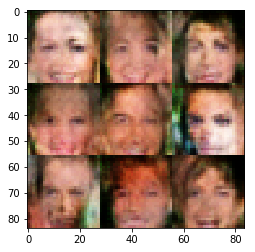

Epoch 1/1... Discriminator Loss: 1.5008... Generator Loss: 0.5086
Epoch 1/1... Discriminator Loss: 1.8814... Generator Loss: 0.4030
Epoch 1/1... Discriminator Loss: 1.4216... Generator Loss: 0.9349
Epoch 1/1... Discriminator Loss: 1.6604... Generator Loss: 0.9209
Epoch 1/1... Discriminator Loss: 1.1722... Generator Loss: 0.9487
Epoch 1/1... Discriminator Loss: 0.9623... Generator Loss: 0.8572
Epoch 1/1... Discriminator Loss: 0.8162... Generator Loss: 1.1621
Epoch 1/1... Discriminator Loss: 1.6661... Generator Loss: 0.7475
Epoch 1/1... Discriminator Loss: 1.9490... Generator Loss: 1.1423
Epoch 1/1... Discriminator Loss: 3.0911... Generator Loss: 0.5081


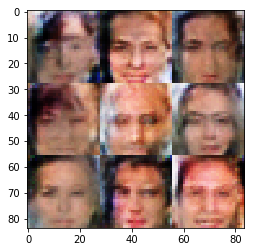

Epoch 1/1... Discriminator Loss: 0.8306... Generator Loss: 1.0351
Epoch 1/1... Discriminator Loss: 1.2701... Generator Loss: 0.5508
Epoch 1/1... Discriminator Loss: 1.0248... Generator Loss: 0.6256
Epoch 1/1... Discriminator Loss: 1.6619... Generator Loss: 0.4177
Epoch 1/1... Discriminator Loss: 1.2864... Generator Loss: 1.8255
Epoch 1/1... Discriminator Loss: 1.1957... Generator Loss: 0.9714
Epoch 1/1... Discriminator Loss: 1.6868... Generator Loss: 1.1301
Epoch 1/1... Discriminator Loss: 1.4571... Generator Loss: 0.5518
Epoch 1/1... Discriminator Loss: 0.7498... Generator Loss: 0.9931
Epoch 1/1... Discriminator Loss: 1.2645... Generator Loss: 1.7750


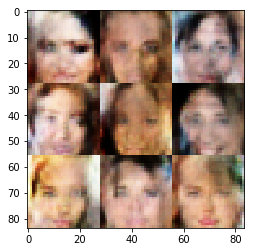

Epoch 1/1... Discriminator Loss: 1.2743... Generator Loss: 1.6631
Epoch 1/1... Discriminator Loss: 1.0323... Generator Loss: 1.0065
Epoch 1/1... Discriminator Loss: 1.3540... Generator Loss: 0.3152
Epoch 1/1... Discriminator Loss: 0.9498... Generator Loss: 0.4944
Epoch 1/1... Discriminator Loss: 1.0939... Generator Loss: 1.3081
Epoch 1/1... Discriminator Loss: 1.5788... Generator Loss: 0.4166
Epoch 1/1... Discriminator Loss: 1.7489... Generator Loss: 0.2881
Epoch 1/1... Discriminator Loss: 2.0983... Generator Loss: 0.4406
Epoch 1/1... Discriminator Loss: 1.2902... Generator Loss: 0.7972
Epoch 1/1... Discriminator Loss: 1.2142... Generator Loss: 1.3192


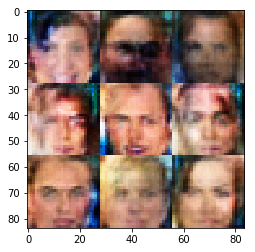

Epoch 1/1... Discriminator Loss: 1.2389... Generator Loss: 0.4837
Epoch 1/1... Discriminator Loss: 1.5231... Generator Loss: 0.9673
Epoch 1/1... Discriminator Loss: 1.5162... Generator Loss: 0.3170
Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 0.9681
Epoch 1/1... Discriminator Loss: 2.1510... Generator Loss: 0.5119
Epoch 1/1... Discriminator Loss: 1.8298... Generator Loss: 0.7567
Epoch 1/1... Discriminator Loss: 1.0075... Generator Loss: 0.7767
Epoch 1/1... Discriminator Loss: 1.8323... Generator Loss: 0.7254
Epoch 1/1... Discriminator Loss: 1.4572... Generator Loss: 1.8980
Epoch 1/1... Discriminator Loss: 1.2785... Generator Loss: 1.4109


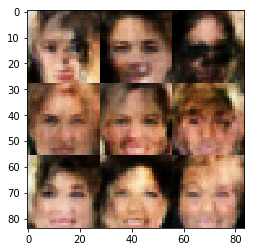

Epoch 1/1... Discriminator Loss: 1.0032... Generator Loss: 0.6275
Epoch 1/1... Discriminator Loss: 1.0440... Generator Loss: 2.0139
Epoch 1/1... Discriminator Loss: 1.0276... Generator Loss: 1.1887
Epoch 1/1... Discriminator Loss: 1.3130... Generator Loss: 0.6263
Epoch 1/1... Discriminator Loss: 2.1031... Generator Loss: 0.2497
Epoch 1/1... Discriminator Loss: 1.7607... Generator Loss: 0.7209
Epoch 1/1... Discriminator Loss: 1.3457... Generator Loss: 0.9612
Epoch 1/1... Discriminator Loss: 1.5714... Generator Loss: 0.3978
Epoch 1/1... Discriminator Loss: 0.9524... Generator Loss: 0.7980
Epoch 1/1... Discriminator Loss: 1.7101... Generator Loss: 0.6640


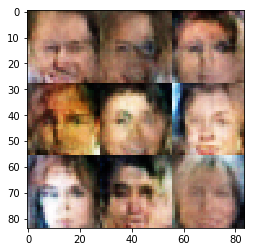

Epoch 1/1... Discriminator Loss: 1.8820... Generator Loss: 0.2663
Epoch 1/1... Discriminator Loss: 1.0508... Generator Loss: 1.0420
Epoch 1/1... Discriminator Loss: 1.9481... Generator Loss: 0.3317
Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 0.8318
Epoch 1/1... Discriminator Loss: 1.5557... Generator Loss: 0.5033
Epoch 1/1... Discriminator Loss: 1.4692... Generator Loss: 0.9150
Epoch 1/1... Discriminator Loss: 1.5572... Generator Loss: 0.4452
Epoch 1/1... Discriminator Loss: 1.4654... Generator Loss: 0.5209
Epoch 1/1... Discriminator Loss: 1.9711... Generator Loss: 0.3977
Epoch 1/1... Discriminator Loss: 1.3633... Generator Loss: 0.6670


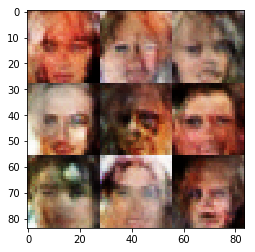

Epoch 1/1... Discriminator Loss: 1.3222... Generator Loss: 0.8648
Epoch 1/1... Discriminator Loss: 2.3280... Generator Loss: 0.9702
Epoch 1/1... Discriminator Loss: 1.2127... Generator Loss: 1.5535
Epoch 1/1... Discriminator Loss: 1.3533... Generator Loss: 0.9787
Epoch 1/1... Discriminator Loss: 1.0520... Generator Loss: 0.8730
Epoch 1/1... Discriminator Loss: 1.3378... Generator Loss: 0.3294
Epoch 1/1... Discriminator Loss: 1.3668... Generator Loss: 0.5315
Epoch 1/1... Discriminator Loss: 1.6926... Generator Loss: 0.7950
Epoch 1/1... Discriminator Loss: 1.8083... Generator Loss: 0.4864
Epoch 1/1... Discriminator Loss: 1.6271... Generator Loss: 0.5011


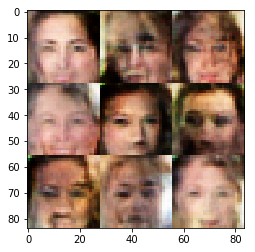

Epoch 1/1... Discriminator Loss: 1.3292... Generator Loss: 0.9042
Epoch 1/1... Discriminator Loss: 1.2019... Generator Loss: 0.6706
Epoch 1/1... Discriminator Loss: 2.2998... Generator Loss: 0.1548
Epoch 1/1... Discriminator Loss: 1.8966... Generator Loss: 0.4091
Epoch 1/1... Discriminator Loss: 1.7826... Generator Loss: 0.6699
Epoch 1/1... Discriminator Loss: 2.4167... Generator Loss: 0.7469
Epoch 1/1... Discriminator Loss: 2.1490... Generator Loss: 0.2809
Epoch 1/1... Discriminator Loss: 1.8679... Generator Loss: 0.3432
Epoch 1/1... Discriminator Loss: 1.3359... Generator Loss: 1.2717
Epoch 1/1... Discriminator Loss: 1.3722... Generator Loss: 0.8038


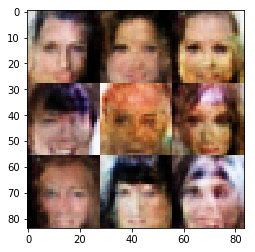

Epoch 1/1... Discriminator Loss: 1.3147... Generator Loss: 0.9649
Epoch 1/1... Discriminator Loss: 0.9681... Generator Loss: 1.6911
Epoch 1/1... Discriminator Loss: 1.3649... Generator Loss: 0.7031
Epoch 1/1... Discriminator Loss: 1.1567... Generator Loss: 1.2533
Epoch 1/1... Discriminator Loss: 1.4341... Generator Loss: 1.9836
Epoch 1/1... Discriminator Loss: 1.1266... Generator Loss: 1.3850
Epoch 1/1... Discriminator Loss: 1.7698... Generator Loss: 1.6163
Epoch 1/1... Discriminator Loss: 2.4632... Generator Loss: 0.4094
Epoch 1/1... Discriminator Loss: 1.8153... Generator Loss: 0.7314
Epoch 1/1... Discriminator Loss: 1.3756... Generator Loss: 0.9647


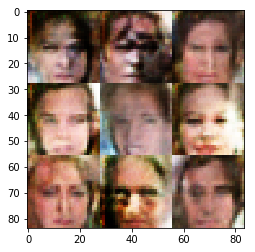

Epoch 1/1... Discriminator Loss: 1.3147... Generator Loss: 1.1059
Epoch 1/1... Discriminator Loss: 1.0787... Generator Loss: 0.8439
Epoch 1/1... Discriminator Loss: 1.8788... Generator Loss: 0.4505
Epoch 1/1... Discriminator Loss: 0.9682... Generator Loss: 0.8398
Epoch 1/1... Discriminator Loss: 1.1233... Generator Loss: 0.7862
Epoch 1/1... Discriminator Loss: 1.6936... Generator Loss: 0.4892
Epoch 1/1... Discriminator Loss: 1.2993... Generator Loss: 0.5642
Epoch 1/1... Discriminator Loss: 2.0503... Generator Loss: 0.6059
Epoch 1/1... Discriminator Loss: 0.8269... Generator Loss: 0.7168
Epoch 1/1... Discriminator Loss: 1.2380... Generator Loss: 1.3618


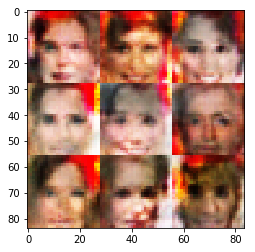

Epoch 1/1... Discriminator Loss: 1.3615... Generator Loss: 1.4588
Epoch 1/1... Discriminator Loss: 1.6961... Generator Loss: 0.3410
Epoch 1/1... Discriminator Loss: 2.1685... Generator Loss: 0.2646
Epoch 1/1... Discriminator Loss: 1.0797... Generator Loss: 0.6405
Epoch 1/1... Discriminator Loss: 1.3742... Generator Loss: 0.7605
Epoch 1/1... Discriminator Loss: 1.8385... Generator Loss: 0.5892
Epoch 1/1... Discriminator Loss: 2.7818... Generator Loss: 0.2128
Epoch 1/1... Discriminator Loss: 1.8425... Generator Loss: 0.7270
Epoch 1/1... Discriminator Loss: 2.8310... Generator Loss: 0.3484
Epoch 1/1... Discriminator Loss: 1.8438... Generator Loss: 0.6126


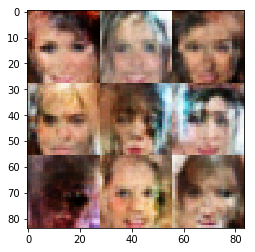

Epoch 1/1... Discriminator Loss: 1.0325... Generator Loss: 1.1544
Epoch 1/1... Discriminator Loss: 0.7304... Generator Loss: 1.4103
Epoch 1/1... Discriminator Loss: 1.4159... Generator Loss: 0.7473
Epoch 1/1... Discriminator Loss: 1.5160... Generator Loss: 1.1181
Epoch 1/1... Discriminator Loss: 1.6614... Generator Loss: 0.4128
Epoch 1/1... Discriminator Loss: 1.1448... Generator Loss: 0.5307
Epoch 1/1... Discriminator Loss: 1.4572... Generator Loss: 1.2749
Epoch 1/1... Discriminator Loss: 1.4157... Generator Loss: 0.5953
Epoch 1/1... Discriminator Loss: 1.9460... Generator Loss: 0.8365
Epoch 1/1... Discriminator Loss: 1.6579... Generator Loss: 0.3107


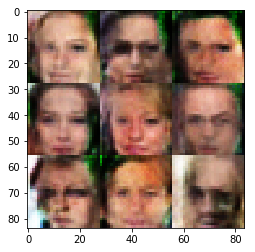

Epoch 1/1... Discriminator Loss: 1.7080... Generator Loss: 0.7143
Epoch 1/1... Discriminator Loss: 1.3071... Generator Loss: 0.3515
Epoch 1/1... Discriminator Loss: 2.4730... Generator Loss: 0.2371
Epoch 1/1... Discriminator Loss: 1.3846... Generator Loss: 0.5921
Epoch 1/1... Discriminator Loss: 1.1649... Generator Loss: 1.0201
Epoch 1/1... Discriminator Loss: 0.9778... Generator Loss: 0.9155
Epoch 1/1... Discriminator Loss: 1.8308... Generator Loss: 1.0977
Epoch 1/1... Discriminator Loss: 2.3068... Generator Loss: 0.2877
Epoch 1/1... Discriminator Loss: 1.6381... Generator Loss: 1.0748
Epoch 1/1... Discriminator Loss: 1.2347... Generator Loss: 0.8460


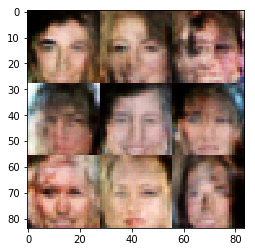

Epoch 1/1... Discriminator Loss: 1.4792... Generator Loss: 0.2888
Epoch 1/1... Discriminator Loss: 1.5918... Generator Loss: 0.6792
Epoch 1/1... Discriminator Loss: 2.1913... Generator Loss: 0.3178
Epoch 1/1... Discriminator Loss: 1.6606... Generator Loss: 1.0902
Epoch 1/1... Discriminator Loss: 1.6980... Generator Loss: 1.0289
Epoch 1/1... Discriminator Loss: 0.7324... Generator Loss: 1.0915
Epoch 1/1... Discriminator Loss: 1.0182... Generator Loss: 1.7607
Epoch 1/1... Discriminator Loss: 1.5535... Generator Loss: 1.4608
Epoch 1/1... Discriminator Loss: 1.1910... Generator Loss: 1.0209
Epoch 1/1... Discriminator Loss: 2.2268... Generator Loss: 0.1973


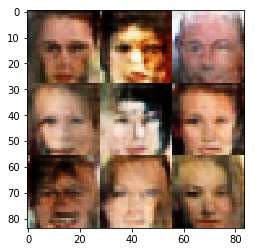

Epoch 1/1... Discriminator Loss: 0.9550... Generator Loss: 0.6236
Epoch 1/1... Discriminator Loss: 1.5080... Generator Loss: 0.6486
Epoch 1/1... Discriminator Loss: 0.9443... Generator Loss: 1.1280
Epoch 1/1... Discriminator Loss: 1.1823... Generator Loss: 0.9867
Epoch 1/1... Discriminator Loss: 1.3770... Generator Loss: 0.9751
Epoch 1/1... Discriminator Loss: 0.6798... Generator Loss: 1.0464
Epoch 1/1... Discriminator Loss: 1.7419... Generator Loss: 0.2804
Epoch 1/1... Discriminator Loss: 2.3590... Generator Loss: 0.3053
Epoch 1/1... Discriminator Loss: 1.7816... Generator Loss: 1.3937
Epoch 1/1... Discriminator Loss: 1.5087... Generator Loss: 1.1843


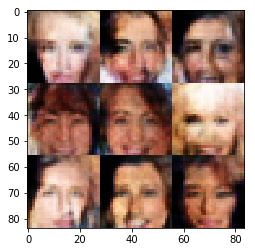

Epoch 1/1... Discriminator Loss: 1.1433... Generator Loss: 0.6772
Epoch 1/1... Discriminator Loss: 2.1155... Generator Loss: 0.3153
Epoch 1/1... Discriminator Loss: 1.2704... Generator Loss: 0.7879
Epoch 1/1... Discriminator Loss: 1.3925... Generator Loss: 0.5959
Epoch 1/1... Discriminator Loss: 1.7474... Generator Loss: 0.2810
Epoch 1/1... Discriminator Loss: 2.5438... Generator Loss: 0.3964
Epoch 1/1... Discriminator Loss: 1.9703... Generator Loss: 0.7114
Epoch 1/1... Discriminator Loss: 0.9080... Generator Loss: 1.3723
Epoch 1/1... Discriminator Loss: 1.4573... Generator Loss: 0.5891
Epoch 1/1... Discriminator Loss: 1.0444... Generator Loss: 0.7492


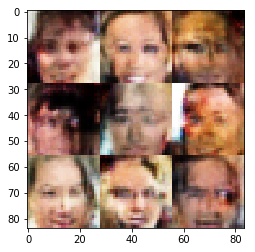

Epoch 1/1... Discriminator Loss: 0.9590... Generator Loss: 0.8481
Epoch 1/1... Discriminator Loss: 0.9913... Generator Loss: 1.1632
Epoch 1/1... Discriminator Loss: 1.2905... Generator Loss: 1.0705
Epoch 1/1... Discriminator Loss: 1.4392... Generator Loss: 0.1811
Epoch 1/1... Discriminator Loss: 1.7805... Generator Loss: 0.4491
Epoch 1/1... Discriminator Loss: 1.0542... Generator Loss: 0.7862
Epoch 1/1... Discriminator Loss: 1.1731... Generator Loss: 0.4229
Epoch 1/1... Discriminator Loss: 1.8330... Generator Loss: 0.5020
Epoch 1/1... Discriminator Loss: 1.4902... Generator Loss: 0.6084
Epoch 1/1... Discriminator Loss: 1.4923... Generator Loss: 0.7411


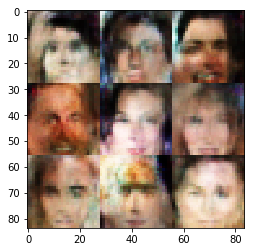

Epoch 1/1... Discriminator Loss: 0.7787... Generator Loss: 1.6784
Epoch 1/1... Discriminator Loss: 1.4686... Generator Loss: 0.5394
Epoch 1/1... Discriminator Loss: 1.4800... Generator Loss: 1.0141
Epoch 1/1... Discriminator Loss: 0.6210... Generator Loss: 1.4814
Epoch 1/1... Discriminator Loss: 1.6805... Generator Loss: 0.3186
Epoch 1/1... Discriminator Loss: 1.6365... Generator Loss: 0.4126
Epoch 1/1... Discriminator Loss: 0.9570... Generator Loss: 1.4047
Epoch 1/1... Discriminator Loss: 1.8978... Generator Loss: 1.0857
Epoch 1/1... Discriminator Loss: 1.3195... Generator Loss: 0.5272
Epoch 1/1... Discriminator Loss: 1.5474... Generator Loss: 0.7856


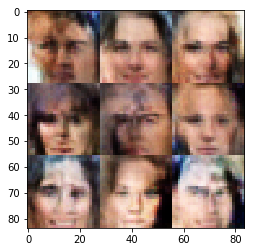

Epoch 1/1... Discriminator Loss: 1.6712... Generator Loss: 1.0747
Epoch 1/1... Discriminator Loss: 1.3154... Generator Loss: 1.2874
Epoch 1/1... Discriminator Loss: 1.3700... Generator Loss: 0.4011
Epoch 1/1... Discriminator Loss: 1.3025... Generator Loss: 0.7418
Epoch 1/1... Discriminator Loss: 1.3458... Generator Loss: 0.4389
Epoch 1/1... Discriminator Loss: 1.7156... Generator Loss: 0.5553
Epoch 1/1... Discriminator Loss: 1.1090... Generator Loss: 0.6098
Epoch 1/1... Discriminator Loss: 1.3219... Generator Loss: 1.3246
Epoch 1/1... Discriminator Loss: 1.8783... Generator Loss: 0.3118
Epoch 1/1... Discriminator Loss: 1.1856... Generator Loss: 0.9593


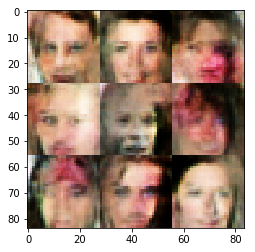

Epoch 1/1... Discriminator Loss: 0.8099... Generator Loss: 1.2557
Epoch 1/1... Discriminator Loss: 1.9576... Generator Loss: 0.2979
Epoch 1/1... Discriminator Loss: 1.5013... Generator Loss: 1.1386
Epoch 1/1... Discriminator Loss: 1.6933... Generator Loss: 0.4390
Epoch 1/1... Discriminator Loss: 1.1599... Generator Loss: 0.8080
Epoch 1/1... Discriminator Loss: 2.0434... Generator Loss: 0.8229
Epoch 1/1... Discriminator Loss: 1.3449... Generator Loss: 1.0965
Epoch 1/1... Discriminator Loss: 0.8229... Generator Loss: 0.7027
Epoch 1/1... Discriminator Loss: 0.8957... Generator Loss: 1.3713
Epoch 1/1... Discriminator Loss: 1.7746... Generator Loss: 0.9192


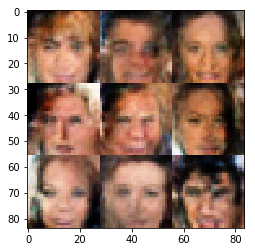

Epoch 1/1... Discriminator Loss: 1.5371... Generator Loss: 0.3770
Epoch 1/1... Discriminator Loss: 1.3531... Generator Loss: 0.7114
Epoch 1/1... Discriminator Loss: 0.7944... Generator Loss: 0.8180
Epoch 1/1... Discriminator Loss: 1.1172... Generator Loss: 1.1007
Epoch 1/1... Discriminator Loss: 0.9852... Generator Loss: 1.0919
Epoch 1/1... Discriminator Loss: 1.1123... Generator Loss: 1.1204
Epoch 1/1... Discriminator Loss: 1.1255... Generator Loss: 0.6954
Epoch 1/1... Discriminator Loss: 1.5482... Generator Loss: 0.3723
Epoch 1/1... Discriminator Loss: 1.1352... Generator Loss: 0.5453
Epoch 1/1... Discriminator Loss: 1.8072... Generator Loss: 0.4124


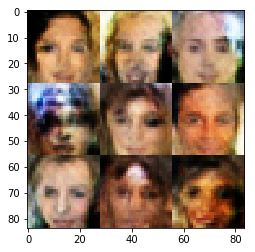

Epoch 1/1... Discriminator Loss: 1.1989... Generator Loss: 0.6530
Epoch 1/1... Discriminator Loss: 1.1501... Generator Loss: 1.3603
Epoch 1/1... Discriminator Loss: 2.0306... Generator Loss: 2.4036
Epoch 1/1... Discriminator Loss: 1.4850... Generator Loss: 1.1374
Epoch 1/1... Discriminator Loss: 1.7247... Generator Loss: 1.0090
Epoch 1/1... Discriminator Loss: 1.7511... Generator Loss: 1.2982
Epoch 1/1... Discriminator Loss: 0.5820... Generator Loss: 2.0382
Epoch 1/1... Discriminator Loss: 1.9267... Generator Loss: 1.2137
Epoch 1/1... Discriminator Loss: 1.5675... Generator Loss: 0.3477
Epoch 1/1... Discriminator Loss: 1.1103... Generator Loss: 1.1234


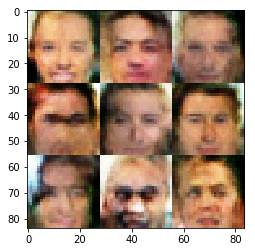

Epoch 1/1... Discriminator Loss: 2.1008... Generator Loss: 0.3694
Epoch 1/1... Discriminator Loss: 1.4467... Generator Loss: 0.5678
Epoch 1/1... Discriminator Loss: 1.7162... Generator Loss: 1.0496
Epoch 1/1... Discriminator Loss: 1.0043... Generator Loss: 1.7917
Epoch 1/1... Discriminator Loss: 0.9327... Generator Loss: 1.9952
Epoch 1/1... Discriminator Loss: 1.1957... Generator Loss: 0.9170
Epoch 1/1... Discriminator Loss: 0.8474... Generator Loss: 1.6079
Epoch 1/1... Discriminator Loss: 1.7308... Generator Loss: 0.6113
Epoch 1/1... Discriminator Loss: 0.8555... Generator Loss: 1.0099
Epoch 1/1... Discriminator Loss: 1.6161... Generator Loss: 0.5351


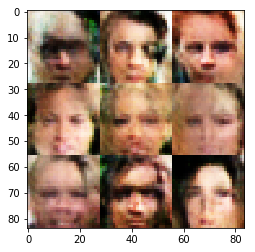

Epoch 1/1... Discriminator Loss: 1.6364... Generator Loss: 0.3241
Epoch 1/1... Discriminator Loss: 1.2034... Generator Loss: 1.1573
Epoch 1/1... Discriminator Loss: 1.3998... Generator Loss: 0.7513
Epoch 1/1... Discriminator Loss: 1.4862... Generator Loss: 0.6169
Epoch 1/1... Discriminator Loss: 0.8373... Generator Loss: 2.4519
Epoch 1/1... Discriminator Loss: 2.9143... Generator Loss: 0.2693
Epoch 1/1... Discriminator Loss: 1.2307... Generator Loss: 0.8268
Epoch 1/1... Discriminator Loss: 0.8181... Generator Loss: 1.4254
Epoch 1/1... Discriminator Loss: 0.9418... Generator Loss: 1.5988
Epoch 1/1... Discriminator Loss: 0.9790... Generator Loss: 1.0959


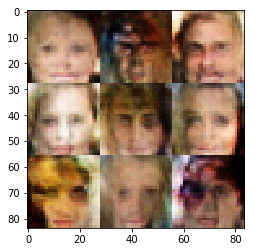

Epoch 1/1... Discriminator Loss: 0.8833... Generator Loss: 1.6798
Epoch 1/1... Discriminator Loss: 1.8410... Generator Loss: 0.3834
Epoch 1/1... Discriminator Loss: 1.2613... Generator Loss: 0.6702
Epoch 1/1... Discriminator Loss: 1.8491... Generator Loss: 0.7230
Epoch 1/1... Discriminator Loss: 1.9325... Generator Loss: 0.7911
Epoch 1/1... Discriminator Loss: 0.8862... Generator Loss: 0.9002
Epoch 1/1... Discriminator Loss: 0.7493... Generator Loss: 1.1416
Epoch 1/1... Discriminator Loss: 1.6892... Generator Loss: 0.7675
Epoch 1/1... Discriminator Loss: 0.8451... Generator Loss: 0.8003
Epoch 1/1... Discriminator Loss: 1.2164... Generator Loss: 1.1316


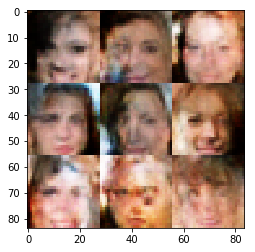

Epoch 1/1... Discriminator Loss: 1.6384... Generator Loss: 0.7265
Epoch 1/1... Discriminator Loss: 1.3871... Generator Loss: 0.8780
Epoch 1/1... Discriminator Loss: 0.7331... Generator Loss: 0.9080
Epoch 1/1... Discriminator Loss: 1.3344... Generator Loss: 1.0917
Epoch 1/1... Discriminator Loss: 1.7207... Generator Loss: 0.4981
Epoch 1/1... Discriminator Loss: 1.6913... Generator Loss: 0.4728
Epoch 1/1... Discriminator Loss: 1.5882... Generator Loss: 0.5455
Epoch 1/1... Discriminator Loss: 2.3976... Generator Loss: 0.7154
Epoch 1/1... Discriminator Loss: 1.4088... Generator Loss: 0.9679
Epoch 1/1... Discriminator Loss: 1.3810... Generator Loss: 0.8194


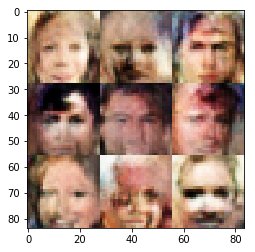

Epoch 1/1... Discriminator Loss: 1.2787... Generator Loss: 0.7094
Epoch 1/1... Discriminator Loss: 1.6737... Generator Loss: 0.2408
Epoch 1/1... Discriminator Loss: 1.3794... Generator Loss: 1.3745
Epoch 1/1... Discriminator Loss: 2.2238... Generator Loss: 0.1738
Epoch 1/1... Discriminator Loss: 0.8969... Generator Loss: 1.7435
Epoch 1/1... Discriminator Loss: 1.0744... Generator Loss: 0.5731
Epoch 1/1... Discriminator Loss: 0.8562... Generator Loss: 1.0942
Epoch 1/1... Discriminator Loss: 2.1407... Generator Loss: 0.3269
Epoch 1/1... Discriminator Loss: 0.7082... Generator Loss: 1.2199
Epoch 1/1... Discriminator Loss: 1.9000... Generator Loss: 0.5017


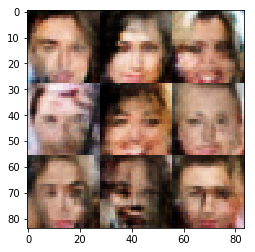

Epoch 1/1... Discriminator Loss: 0.8702... Generator Loss: 1.4423
Epoch 1/1... Discriminator Loss: 1.8537... Generator Loss: 0.3870
Epoch 1/1... Discriminator Loss: 1.1075... Generator Loss: 0.8501
Epoch 1/1... Discriminator Loss: 1.4525... Generator Loss: 1.9916
Epoch 1/1... Discriminator Loss: 1.9965... Generator Loss: 0.6689
Epoch 1/1... Discriminator Loss: 0.8758... Generator Loss: 1.1289
Epoch 1/1... Discriminator Loss: 1.3099... Generator Loss: 1.4611
Epoch 1/1... Discriminator Loss: 1.0012... Generator Loss: 2.4340
Epoch 1/1... Discriminator Loss: 1.3016... Generator Loss: 0.9957
Epoch 1/1... Discriminator Loss: 1.1029... Generator Loss: 1.3274


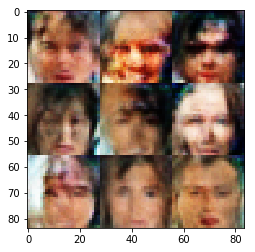

Epoch 1/1... Discriminator Loss: 1.2733... Generator Loss: 0.6389
Epoch 1/1... Discriminator Loss: 1.2200... Generator Loss: 0.6944
Epoch 1/1... Discriminator Loss: 1.7263... Generator Loss: 0.8069
Epoch 1/1... Discriminator Loss: 1.2323... Generator Loss: 0.8325
Epoch 1/1... Discriminator Loss: 1.2071... Generator Loss: 1.1229
Epoch 1/1... Discriminator Loss: 1.5350... Generator Loss: 0.4345
Epoch 1/1... Discriminator Loss: 2.1940... Generator Loss: 0.2359
Epoch 1/1... Discriminator Loss: 1.1157... Generator Loss: 1.2367
Epoch 1/1... Discriminator Loss: 1.7594... Generator Loss: 0.4156
Epoch 1/1... Discriminator Loss: 1.6301... Generator Loss: 0.6379


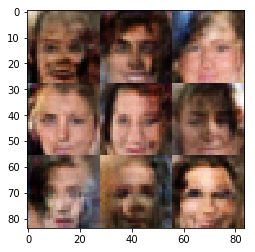

Epoch 1/1... Discriminator Loss: 2.2455... Generator Loss: 0.5101
Epoch 1/1... Discriminator Loss: 1.5715... Generator Loss: 0.4907
Epoch 1/1... Discriminator Loss: 1.9601... Generator Loss: 0.3967
Epoch 1/1... Discriminator Loss: 0.9951... Generator Loss: 0.9902
Epoch 1/1... Discriminator Loss: 2.1195... Generator Loss: 0.9804
Epoch 1/1... Discriminator Loss: 1.3079... Generator Loss: 0.3790
Epoch 1/1... Discriminator Loss: 1.0013... Generator Loss: 0.7860
Epoch 1/1... Discriminator Loss: 1.1555... Generator Loss: 1.0006
Epoch 1/1... Discriminator Loss: 1.1647... Generator Loss: 1.2310
Epoch 1/1... Discriminator Loss: 2.8204... Generator Loss: 0.4286


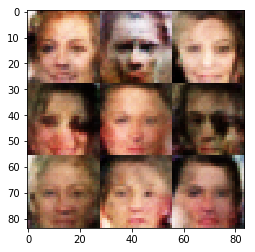

Epoch 1/1... Discriminator Loss: 1.3256... Generator Loss: 1.3985
Epoch 1/1... Discriminator Loss: 1.4591... Generator Loss: 0.7734
Epoch 1/1... Discriminator Loss: 1.4241... Generator Loss: 0.5121
Epoch 1/1... Discriminator Loss: 0.7146... Generator Loss: 1.4245
Epoch 1/1... Discriminator Loss: 1.6153... Generator Loss: 0.5843
Epoch 1/1... Discriminator Loss: 2.0624... Generator Loss: 0.7027
Epoch 1/1... Discriminator Loss: 0.9192... Generator Loss: 1.3623
Epoch 1/1... Discriminator Loss: 0.5563... Generator Loss: 1.2669
Epoch 1/1... Discriminator Loss: 1.1711... Generator Loss: 1.2804
Epoch 1/1... Discriminator Loss: 0.9088... Generator Loss: 1.3333


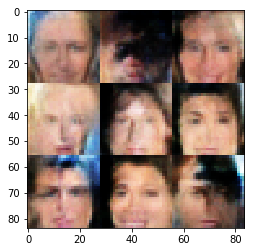

Epoch 1/1... Discriminator Loss: 1.1065... Generator Loss: 0.9765
Epoch 1/1... Discriminator Loss: 1.3428... Generator Loss: 1.2056
Epoch 1/1... Discriminator Loss: 1.5151... Generator Loss: 0.6786
Epoch 1/1... Discriminator Loss: 1.6829... Generator Loss: 0.6629
Epoch 1/1... Discriminator Loss: 1.9826... Generator Loss: 0.8245
Epoch 1/1... Discriminator Loss: 0.9675... Generator Loss: 1.0152
Epoch 1/1... Discriminator Loss: 2.1180... Generator Loss: 0.9693
Epoch 1/1... Discriminator Loss: 1.4721... Generator Loss: 0.4933
Epoch 1/1... Discriminator Loss: 1.5948... Generator Loss: 0.3071
Epoch 1/1... Discriminator Loss: 1.2580... Generator Loss: 0.8030


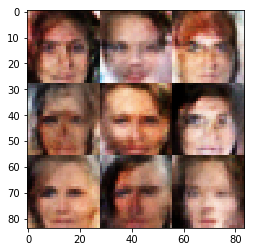

Epoch 1/1... Discriminator Loss: 1.5799... Generator Loss: 0.6766
Epoch 1/1... Discriminator Loss: 1.4894... Generator Loss: 1.0278
Epoch 1/1... Discriminator Loss: 1.3237... Generator Loss: 0.7312
Epoch 1/1... Discriminator Loss: 1.5962... Generator Loss: 0.5920
Epoch 1/1... Discriminator Loss: 2.1257... Generator Loss: 0.2204
Epoch 1/1... Discriminator Loss: 1.3987... Generator Loss: 0.8372
Epoch 1/1... Discriminator Loss: 1.2745... Generator Loss: 0.9387
Epoch 1/1... Discriminator Loss: 1.6409... Generator Loss: 1.0145
Epoch 1/1... Discriminator Loss: 2.0069... Generator Loss: 0.5113
Epoch 1/1... Discriminator Loss: 1.6513... Generator Loss: 0.6025


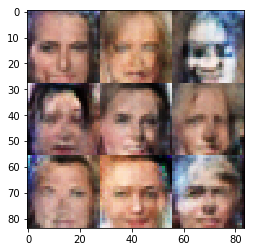

Epoch 1/1... Discriminator Loss: 2.0001... Generator Loss: 0.8327
Epoch 1/1... Discriminator Loss: 1.2132... Generator Loss: 1.1026
Epoch 1/1... Discriminator Loss: 1.1733... Generator Loss: 0.9860
Epoch 1/1... Discriminator Loss: 1.5843... Generator Loss: 1.4055
Epoch 1/1... Discriminator Loss: 1.8422... Generator Loss: 0.2211
Epoch 1/1... Discriminator Loss: 1.1923... Generator Loss: 1.4597
Epoch 1/1... Discriminator Loss: 1.5727... Generator Loss: 0.6007
Epoch 1/1... Discriminator Loss: 1.6042... Generator Loss: 1.4187
Epoch 1/1... Discriminator Loss: 0.9361... Generator Loss: 1.3239
Epoch 1/1... Discriminator Loss: 0.7216... Generator Loss: 0.8729


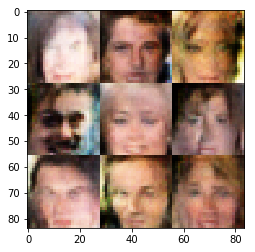

Epoch 1/1... Discriminator Loss: 1.3573... Generator Loss: 1.1331
Epoch 1/1... Discriminator Loss: 1.7448... Generator Loss: 1.1745
Epoch 1/1... Discriminator Loss: 1.2306... Generator Loss: 1.3328
Epoch 1/1... Discriminator Loss: 1.1961... Generator Loss: 0.8222
Epoch 1/1... Discriminator Loss: 1.0901... Generator Loss: 0.8821
Epoch 1/1... Discriminator Loss: 1.4896... Generator Loss: 0.4593
Epoch 1/1... Discriminator Loss: 1.1141... Generator Loss: 0.7351
Epoch 1/1... Discriminator Loss: 0.8775... Generator Loss: 1.3421
Epoch 1/1... Discriminator Loss: 1.7983... Generator Loss: 0.7161
Epoch 1/1... Discriminator Loss: 1.1796... Generator Loss: 0.8626


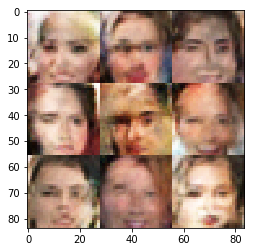

Epoch 1/1... Discriminator Loss: 1.9125... Generator Loss: 0.4958
Epoch 1/1... Discriminator Loss: 1.5951... Generator Loss: 0.9072
Epoch 1/1... Discriminator Loss: 2.1119... Generator Loss: 0.4309
Epoch 1/1... Discriminator Loss: 0.6694... Generator Loss: 0.7616
Epoch 1/1... Discriminator Loss: 1.8790... Generator Loss: 0.3707
Epoch 1/1... Discriminator Loss: 1.1956... Generator Loss: 0.8999
Epoch 1/1... Discriminator Loss: 1.3401... Generator Loss: 1.4037
Epoch 1/1... Discriminator Loss: 2.1632... Generator Loss: 0.5803
Epoch 1/1... Discriminator Loss: 1.6239... Generator Loss: 0.3956
Epoch 1/1... Discriminator Loss: 1.3713... Generator Loss: 0.3240


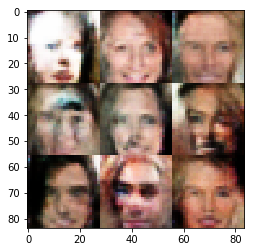

Epoch 1/1... Discriminator Loss: 1.2300... Generator Loss: 0.9875
Epoch 1/1... Discriminator Loss: 1.3683... Generator Loss: 0.9356
Epoch 1/1... Discriminator Loss: 1.1644... Generator Loss: 1.4351
Epoch 1/1... Discriminator Loss: 2.0042... Generator Loss: 0.5911
Epoch 1/1... Discriminator Loss: 1.3345... Generator Loss: 0.9657
Epoch 1/1... Discriminator Loss: 1.7709... Generator Loss: 0.7471
Epoch 1/1... Discriminator Loss: 0.8073... Generator Loss: 1.3240
Epoch 1/1... Discriminator Loss: 1.5517... Generator Loss: 0.5552
Epoch 1/1... Discriminator Loss: 1.0428... Generator Loss: 0.6141
Epoch 1/1... Discriminator Loss: 0.9754... Generator Loss: 2.7442


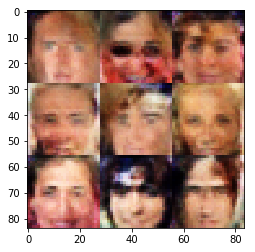

Epoch 1/1... Discriminator Loss: 2.2410... Generator Loss: 0.2566
Epoch 1/1... Discriminator Loss: 2.0587... Generator Loss: 0.5655
Epoch 1/1... Discriminator Loss: 1.9176... Generator Loss: 1.1118
Epoch 1/1... Discriminator Loss: 0.9980... Generator Loss: 1.2367
Epoch 1/1... Discriminator Loss: 0.8035... Generator Loss: 1.5129
Epoch 1/1... Discriminator Loss: 0.8799... Generator Loss: 1.1052
Epoch 1/1... Discriminator Loss: 1.0912... Generator Loss: 0.4576
Epoch 1/1... Discriminator Loss: 1.0992... Generator Loss: 1.5245
Epoch 1/1... Discriminator Loss: 0.7001... Generator Loss: 0.9317
Epoch 1/1... Discriminator Loss: 1.7458... Generator Loss: 0.4503


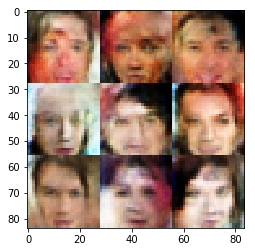

Epoch 1/1... Discriminator Loss: 1.5030... Generator Loss: 0.5586
Epoch 1/1... Discriminator Loss: 1.1805... Generator Loss: 0.7630
Epoch 1/1... Discriminator Loss: 1.2110... Generator Loss: 0.7039
Epoch 1/1... Discriminator Loss: 0.8325... Generator Loss: 1.4697
Epoch 1/1... Discriminator Loss: 1.6955... Generator Loss: 0.7758
Epoch 1/1... Discriminator Loss: 1.1863... Generator Loss: 0.9424
Epoch 1/1... Discriminator Loss: 0.7295... Generator Loss: 0.8279
Epoch 1/1... Discriminator Loss: 1.8632... Generator Loss: 0.8334
Epoch 1/1... Discriminator Loss: 1.2004... Generator Loss: 1.0165
Epoch 1/1... Discriminator Loss: 1.2246... Generator Loss: 0.6211


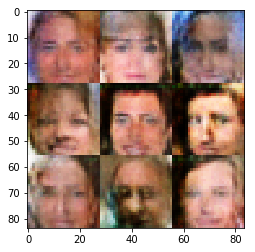

Epoch 1/1... Discriminator Loss: 1.1015... Generator Loss: 1.0939
Epoch 1/1... Discriminator Loss: 1.5124... Generator Loss: 0.6774
Epoch 1/1... Discriminator Loss: 0.9952... Generator Loss: 1.3963
Epoch 1/1... Discriminator Loss: 1.2455... Generator Loss: 0.9076
Epoch 1/1... Discriminator Loss: 2.1015... Generator Loss: 0.6202
Epoch 1/1... Discriminator Loss: 1.8998... Generator Loss: 0.7748
Epoch 1/1... Discriminator Loss: 1.1609... Generator Loss: 0.6808
Epoch 1/1... Discriminator Loss: 1.3521... Generator Loss: 1.0096
Epoch 1/1... Discriminator Loss: 1.7126... Generator Loss: 1.4298
Epoch 1/1... Discriminator Loss: 1.5403... Generator Loss: 0.5444


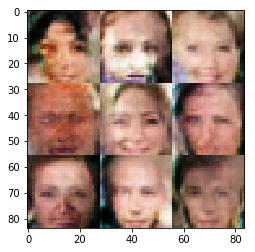

Epoch 1/1... Discriminator Loss: 1.5090... Generator Loss: 0.5465
Epoch 1/1... Discriminator Loss: 0.8995... Generator Loss: 0.7639
Epoch 1/1... Discriminator Loss: 1.9325... Generator Loss: 0.8031
Epoch 1/1... Discriminator Loss: 1.5037... Generator Loss: 0.9007
Epoch 1/1... Discriminator Loss: 0.8885... Generator Loss: 1.3909
Epoch 1/1... Discriminator Loss: 1.7797... Generator Loss: 0.7644
Epoch 1/1... Discriminator Loss: 1.5320... Generator Loss: 1.2917
Epoch 1/1... Discriminator Loss: 1.0959... Generator Loss: 0.6193
Epoch 1/1... Discriminator Loss: 1.5806... Generator Loss: 0.9377
Epoch 1/1... Discriminator Loss: 1.0688... Generator Loss: 1.5050


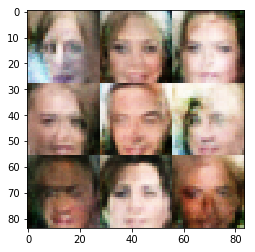

Epoch 1/1... Discriminator Loss: 1.0355... Generator Loss: 0.9235
Epoch 1/1... Discriminator Loss: 1.0444... Generator Loss: 1.3588
Epoch 1/1... Discriminator Loss: 1.5108... Generator Loss: 0.8889
Epoch 1/1... Discriminator Loss: 1.3847... Generator Loss: 0.4732
Epoch 1/1... Discriminator Loss: 1.5950... Generator Loss: 0.5231
Epoch 1/1... Discriminator Loss: 2.4071... Generator Loss: 0.3335
Epoch 1/1... Discriminator Loss: 1.1504... Generator Loss: 1.0697
Epoch 1/1... Discriminator Loss: 1.7304... Generator Loss: 0.4391
Epoch 1/1... Discriminator Loss: 1.1980... Generator Loss: 0.6853
Epoch 1/1... Discriminator Loss: 1.4519... Generator Loss: 0.7178


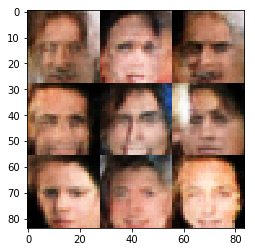

Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 0.3893
Epoch 1/1... Discriminator Loss: 1.3352... Generator Loss: 0.5113
Epoch 1/1... Discriminator Loss: 1.7254... Generator Loss: 0.8893
Epoch 1/1... Discriminator Loss: 0.7939... Generator Loss: 1.8063
Epoch 1/1... Discriminator Loss: 1.6211... Generator Loss: 1.1053
Epoch 1/1... Discriminator Loss: 1.1833... Generator Loss: 1.0863
Epoch 1/1... Discriminator Loss: 1.8562... Generator Loss: 0.6346
Epoch 1/1... Discriminator Loss: 1.6781... Generator Loss: 0.8901
Epoch 1/1... Discriminator Loss: 2.7255... Generator Loss: 0.2618
Epoch 1/1... Discriminator Loss: 2.0599... Generator Loss: 0.4628


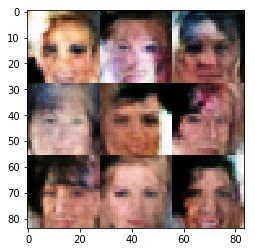

Epoch 1/1... Discriminator Loss: 1.0038... Generator Loss: 0.9062
Epoch 1/1... Discriminator Loss: 1.6142... Generator Loss: 0.4734
Epoch 1/1... Discriminator Loss: 1.7912... Generator Loss: 0.7091
Epoch 1/1... Discriminator Loss: 1.0628... Generator Loss: 1.1435
Epoch 1/1... Discriminator Loss: 1.9722... Generator Loss: 0.1752
Epoch 1/1... Discriminator Loss: 1.3481... Generator Loss: 0.5491
Epoch 1/1... Discriminator Loss: 1.2908... Generator Loss: 1.0229
Epoch 1/1... Discriminator Loss: 1.3594... Generator Loss: 0.5138
Epoch 1/1... Discriminator Loss: 1.0912... Generator Loss: 1.1748
Epoch 1/1... Discriminator Loss: 0.8061... Generator Loss: 1.3838


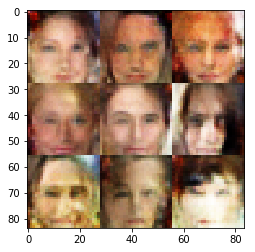

Epoch 1/1... Discriminator Loss: 1.4713... Generator Loss: 0.8194
Epoch 1/1... Discriminator Loss: 0.7129... Generator Loss: 1.8982
Epoch 1/1... Discriminator Loss: 1.9235... Generator Loss: 0.7677
Epoch 1/1... Discriminator Loss: 1.7688... Generator Loss: 1.1187
Epoch 1/1... Discriminator Loss: 1.4868... Generator Loss: 0.7582
Epoch 1/1... Discriminator Loss: 1.3955... Generator Loss: 0.6988
Epoch 1/1... Discriminator Loss: 1.1780... Generator Loss: 0.8028
Epoch 1/1... Discriminator Loss: 1.2981... Generator Loss: 1.2831
Epoch 1/1... Discriminator Loss: 1.2687... Generator Loss: 1.8930
Epoch 1/1... Discriminator Loss: 1.3748... Generator Loss: 1.5353


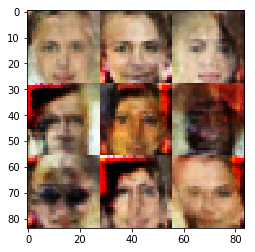

Epoch 1/1... Discriminator Loss: 0.9338... Generator Loss: 1.2900
Epoch 1/1... Discriminator Loss: 0.9215... Generator Loss: 1.4728
Epoch 1/1... Discriminator Loss: 2.0054... Generator Loss: 1.0448
Epoch 1/1... Discriminator Loss: 1.1880... Generator Loss: 1.1595
Epoch 1/1... Discriminator Loss: 0.8478... Generator Loss: 1.5994
Epoch 1/1... Discriminator Loss: 2.4944... Generator Loss: 0.2082
Epoch 1/1... Discriminator Loss: 1.2806... Generator Loss: 1.1039
Epoch 1/1... Discriminator Loss: 1.5719... Generator Loss: 1.2717
Epoch 1/1... Discriminator Loss: 0.9046... Generator Loss: 1.2046
Epoch 1/1... Discriminator Loss: 1.3409... Generator Loss: 0.8412


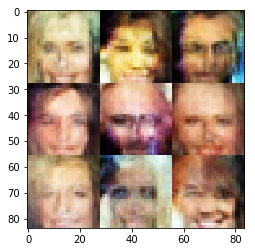

Epoch 1/1... Discriminator Loss: 0.9140... Generator Loss: 1.1362
Epoch 1/1... Discriminator Loss: 1.4880... Generator Loss: 1.1953
Epoch 1/1... Discriminator Loss: 1.0396... Generator Loss: 1.4896
Epoch 1/1... Discriminator Loss: 2.6081... Generator Loss: 0.5995
Epoch 1/1... Discriminator Loss: 1.7806... Generator Loss: 0.9671
Epoch 1/1... Discriminator Loss: 1.7588... Generator Loss: 0.3516
Epoch 1/1... Discriminator Loss: 1.2475... Generator Loss: 0.8303
Epoch 1/1... Discriminator Loss: 0.9804... Generator Loss: 1.0721
Epoch 1/1... Discriminator Loss: 0.8521... Generator Loss: 1.3457
Epoch 1/1... Discriminator Loss: 1.4254... Generator Loss: 1.0849


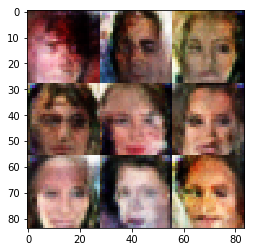

Epoch 1/1... Discriminator Loss: 0.5566... Generator Loss: 1.4620
Epoch 1/1... Discriminator Loss: 1.4547... Generator Loss: 0.8789
Epoch 1/1... Discriminator Loss: 2.3004... Generator Loss: 0.4968
Epoch 1/1... Discriminator Loss: 1.1550... Generator Loss: 0.9112
Epoch 1/1... Discriminator Loss: 0.4908... Generator Loss: 1.1233
Epoch 1/1... Discriminator Loss: 2.1899... Generator Loss: 1.1750
Epoch 1/1... Discriminator Loss: 1.9059... Generator Loss: 0.5358
Epoch 1/1... Discriminator Loss: 1.5372... Generator Loss: 0.7261
Epoch 1/1... Discriminator Loss: 1.5258... Generator Loss: 1.4429
Epoch 1/1... Discriminator Loss: 2.1276... Generator Loss: 0.7955


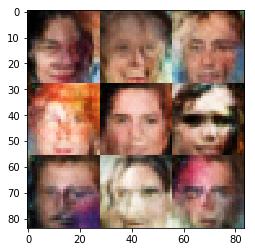

Epoch 1/1... Discriminator Loss: 1.2731... Generator Loss: 1.4409
Epoch 1/1... Discriminator Loss: 1.0706... Generator Loss: 1.4615
Epoch 1/1... Discriminator Loss: 1.9937... Generator Loss: 0.3578
Epoch 1/1... Discriminator Loss: 0.9143... Generator Loss: 1.0934
Epoch 1/1... Discriminator Loss: 1.5512... Generator Loss: 1.4939
Epoch 1/1... Discriminator Loss: 1.6520... Generator Loss: 0.3005
Epoch 1/1... Discriminator Loss: 1.0543... Generator Loss: 1.0549
Epoch 1/1... Discriminator Loss: 1.8766... Generator Loss: 0.5959
Epoch 1/1... Discriminator Loss: 1.0252... Generator Loss: 1.1229
Epoch 1/1... Discriminator Loss: 0.7263... Generator Loss: 1.8777


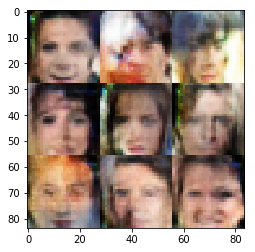

Epoch 1/1... Discriminator Loss: 1.6955... Generator Loss: 1.0229
Epoch 1/1... Discriminator Loss: 1.7343... Generator Loss: 0.5903
Epoch 1/1... Discriminator Loss: 1.4315... Generator Loss: 1.0016
Epoch 1/1... Discriminator Loss: 1.4265... Generator Loss: 0.4305
Epoch 1/1... Discriminator Loss: 1.7790... Generator Loss: 0.4762
Epoch 1/1... Discriminator Loss: 1.2628... Generator Loss: 0.9729
Epoch 1/1... Discriminator Loss: 1.3085... Generator Loss: 1.1546
Epoch 1/1... Discriminator Loss: 1.3517... Generator Loss: 0.5210
Epoch 1/1... Discriminator Loss: 1.0698... Generator Loss: 1.2057
Epoch 1/1... Discriminator Loss: 0.6593... Generator Loss: 1.6530


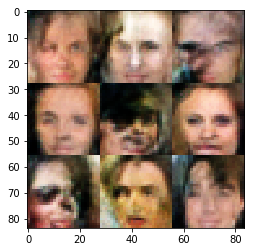

Epoch 1/1... Discriminator Loss: 1.0941... Generator Loss: 0.9771
Epoch 1/1... Discriminator Loss: 1.3355... Generator Loss: 0.6319
Epoch 1/1... Discriminator Loss: 1.8676... Generator Loss: 0.4605
Epoch 1/1... Discriminator Loss: 1.1707... Generator Loss: 1.0939
Epoch 1/1... Discriminator Loss: 1.7079... Generator Loss: 0.7375
Epoch 1/1... Discriminator Loss: 1.5387... Generator Loss: 0.8771
Epoch 1/1... Discriminator Loss: 1.0768... Generator Loss: 0.7983
Epoch 1/1... Discriminator Loss: 0.6221... Generator Loss: 1.1238
Epoch 1/1... Discriminator Loss: 1.2977... Generator Loss: 1.1768
Epoch 1/1... Discriminator Loss: 0.7864... Generator Loss: 0.7841


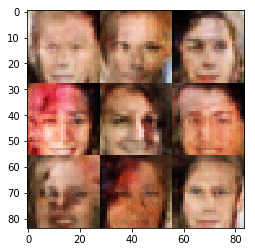

Epoch 1/1... Discriminator Loss: 1.1563... Generator Loss: 0.9787
Epoch 1/1... Discriminator Loss: 2.1492... Generator Loss: 0.6251
Epoch 1/1... Discriminator Loss: 0.7819... Generator Loss: 1.0436
Epoch 1/1... Discriminator Loss: 1.0837... Generator Loss: 0.8494
Epoch 1/1... Discriminator Loss: 1.0487... Generator Loss: 1.2682
Epoch 1/1... Discriminator Loss: 1.6192... Generator Loss: 0.5846
Epoch 1/1... Discriminator Loss: 0.9193... Generator Loss: 1.2354
Epoch 1/1... Discriminator Loss: 1.0446... Generator Loss: 1.8321
Epoch 1/1... Discriminator Loss: 0.8178... Generator Loss: 0.8293
Epoch 1/1... Discriminator Loss: 0.9189... Generator Loss: 1.4201


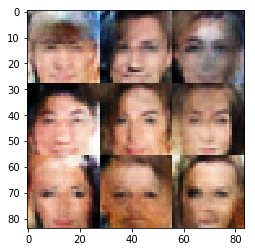

Epoch 1/1... Discriminator Loss: 1.6402... Generator Loss: 1.5993
Epoch 1/1... Discriminator Loss: 1.1141... Generator Loss: 0.8473
Epoch 1/1... Discriminator Loss: 1.3805... Generator Loss: 0.5369
Epoch 1/1... Discriminator Loss: 1.2478... Generator Loss: 0.9358
Epoch 1/1... Discriminator Loss: 1.9377... Generator Loss: 0.7298
Epoch 1/1... Discriminator Loss: 1.7338... Generator Loss: 0.4317
Epoch 1/1... Discriminator Loss: 1.3424... Generator Loss: 0.8366
Epoch 1/1... Discriminator Loss: 1.2455... Generator Loss: 0.6946
Epoch 1/1... Discriminator Loss: 1.1750... Generator Loss: 1.1941
Epoch 1/1... Discriminator Loss: 1.0609... Generator Loss: 0.6311


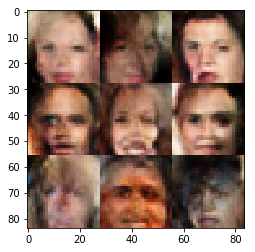

Epoch 1/1... Discriminator Loss: 1.1011... Generator Loss: 1.5107
Epoch 1/1... Discriminator Loss: 1.0597... Generator Loss: 0.5621
Epoch 1/1... Discriminator Loss: 1.0449... Generator Loss: 0.9054
Epoch 1/1... Discriminator Loss: 1.0882... Generator Loss: 0.5171
Epoch 1/1... Discriminator Loss: 1.4362... Generator Loss: 0.8259
Epoch 1/1... Discriminator Loss: 1.9464... Generator Loss: 0.4601
Epoch 1/1... Discriminator Loss: 1.4821... Generator Loss: 0.5958
Epoch 1/1... Discriminator Loss: 1.7712... Generator Loss: 0.8719
Epoch 1/1... Discriminator Loss: 1.5664... Generator Loss: 0.9610
Epoch 1/1... Discriminator Loss: 1.1996... Generator Loss: 0.5702


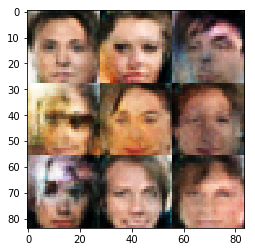

Epoch 1/1... Discriminator Loss: 1.7131... Generator Loss: 0.7964
Epoch 1/1... Discriminator Loss: 1.0835... Generator Loss: 1.6712
Epoch 1/1... Discriminator Loss: 0.4731... Generator Loss: 1.4946
Epoch 1/1... Discriminator Loss: 0.9269... Generator Loss: 1.2093
Epoch 1/1... Discriminator Loss: 1.0959... Generator Loss: 1.0551
Epoch 1/1... Discriminator Loss: 1.2695... Generator Loss: 1.6575
Epoch 1/1... Discriminator Loss: 0.6253... Generator Loss: 1.3597
Epoch 1/1... Discriminator Loss: 1.9484... Generator Loss: 1.9510
Epoch 1/1... Discriminator Loss: 0.8365... Generator Loss: 0.9074
Epoch 1/1... Discriminator Loss: 1.8407... Generator Loss: 0.3645


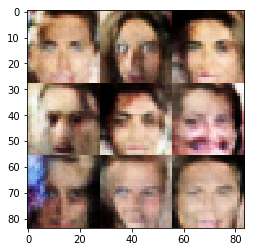

Epoch 1/1... Discriminator Loss: 2.2634... Generator Loss: 0.8224
Epoch 1/1... Discriminator Loss: 1.6729... Generator Loss: 0.5772
Epoch 1/1... Discriminator Loss: 1.2310... Generator Loss: 0.8562
Epoch 1/1... Discriminator Loss: 0.9594... Generator Loss: 1.3898
Epoch 1/1... Discriminator Loss: 0.9737... Generator Loss: 1.0086
Epoch 1/1... Discriminator Loss: 1.6000... Generator Loss: 1.4447
Epoch 1/1... Discriminator Loss: 1.7086... Generator Loss: 1.2465
Epoch 1/1... Discriminator Loss: 1.0349... Generator Loss: 1.2255
Epoch 1/1... Discriminator Loss: 0.8426... Generator Loss: 0.7040
Epoch 1/1... Discriminator Loss: 1.2307... Generator Loss: 1.1967


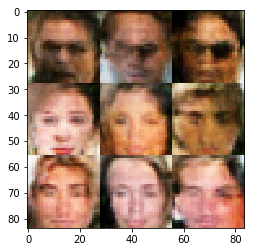

Epoch 1/1... Discriminator Loss: 1.7890... Generator Loss: 1.0450
Epoch 1/1... Discriminator Loss: 1.5904... Generator Loss: 0.9739
Epoch 1/1... Discriminator Loss: 1.2593... Generator Loss: 1.3977
Epoch 1/1... Discriminator Loss: 0.9579... Generator Loss: 0.9731
Epoch 1/1... Discriminator Loss: 1.6016... Generator Loss: 0.5693
Epoch 1/1... Discriminator Loss: 1.1693... Generator Loss: 0.9168
Epoch 1/1... Discriminator Loss: 1.1842... Generator Loss: 0.7597
Epoch 1/1... Discriminator Loss: 1.1011... Generator Loss: 0.7459
Epoch 1/1... Discriminator Loss: 1.7982... Generator Loss: 0.5178
Epoch 1/1... Discriminator Loss: 1.7758... Generator Loss: 1.0019


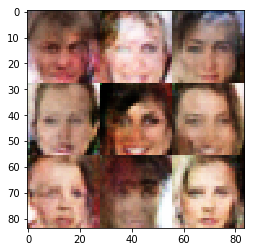

Epoch 1/1... Discriminator Loss: 1.6992... Generator Loss: 0.5356
Epoch 1/1... Discriminator Loss: 0.9319... Generator Loss: 1.1543
Epoch 1/1... Discriminator Loss: 1.4009... Generator Loss: 1.0316
Epoch 1/1... Discriminator Loss: 0.8870... Generator Loss: 1.8796
Epoch 1/1... Discriminator Loss: 1.6144... Generator Loss: 1.8128
Epoch 1/1... Discriminator Loss: 0.8650... Generator Loss: 1.4859
Epoch 1/1... Discriminator Loss: 0.9901... Generator Loss: 0.6753
Epoch 1/1... Discriminator Loss: 1.2609... Generator Loss: 1.3551
Epoch 1/1... Discriminator Loss: 0.8015... Generator Loss: 2.5421
Epoch 1/1... Discriminator Loss: 1.4988... Generator Loss: 0.9290


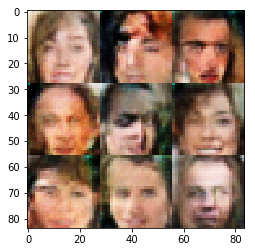

Epoch 1/1... Discriminator Loss: 0.7629... Generator Loss: 1.6722
Epoch 1/1... Discriminator Loss: 0.6237... Generator Loss: 1.1368
Epoch 1/1... Discriminator Loss: 2.3083... Generator Loss: 0.6700
Epoch 1/1... Discriminator Loss: 0.9938... Generator Loss: 1.1001
Epoch 1/1... Discriminator Loss: 1.8363... Generator Loss: 1.3856
Epoch 1/1... Discriminator Loss: 1.5112... Generator Loss: 0.7660
Epoch 1/1... Discriminator Loss: 0.9764... Generator Loss: 1.2729
Epoch 1/1... Discriminator Loss: 1.1346... Generator Loss: 1.1314
Epoch 1/1... Discriminator Loss: 1.6879... Generator Loss: 0.4874
Epoch 1/1... Discriminator Loss: 1.5053... Generator Loss: 2.2251


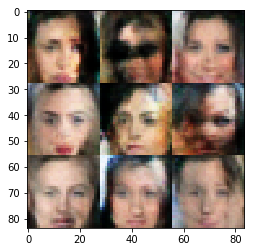

Epoch 1/1... Discriminator Loss: 1.2005... Generator Loss: 1.0993
Epoch 1/1... Discriminator Loss: 1.8185... Generator Loss: 0.8961
Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 1.2680
Epoch 1/1... Discriminator Loss: 1.5008... Generator Loss: 1.0040
Epoch 1/1... Discriminator Loss: 0.8147... Generator Loss: 1.0492
Epoch 1/1... Discriminator Loss: 1.9780... Generator Loss: 1.2930
Epoch 1/1... Discriminator Loss: 0.9592... Generator Loss: 1.0256
Epoch 1/1... Discriminator Loss: 1.7328... Generator Loss: 0.5995
Epoch 1/1... Discriminator Loss: 1.1386... Generator Loss: 1.7274
Epoch 1/1... Discriminator Loss: 1.3090... Generator Loss: 0.9096


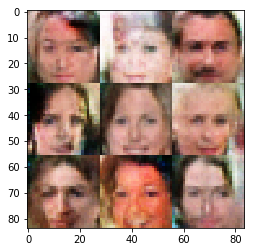

Epoch 1/1... Discriminator Loss: 0.5363... Generator Loss: 1.6577
Epoch 1/1... Discriminator Loss: 0.8526... Generator Loss: 1.1286
Epoch 1/1... Discriminator Loss: 1.2080... Generator Loss: 1.2298
Epoch 1/1... Discriminator Loss: 1.1364... Generator Loss: 1.9060
Epoch 1/1... Discriminator Loss: 1.3744... Generator Loss: 0.6947
Epoch 1/1... Discriminator Loss: 1.6135... Generator Loss: 0.3429
Epoch 1/1... Discriminator Loss: 0.8684... Generator Loss: 1.2925
Epoch 1/1... Discriminator Loss: 1.6927... Generator Loss: 1.0815
Epoch 1/1... Discriminator Loss: 1.3266... Generator Loss: 1.0718
Epoch 1/1... Discriminator Loss: 1.4551... Generator Loss: 0.7662


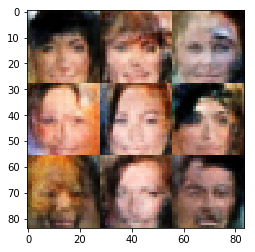

Epoch 1/1... Discriminator Loss: 0.5644... Generator Loss: 1.0776
Epoch 1/1... Discriminator Loss: 1.2597... Generator Loss: 0.5135
Epoch 1/1... Discriminator Loss: 0.6894... Generator Loss: 1.5481
Epoch 1/1... Discriminator Loss: 1.9934... Generator Loss: 1.0019
Epoch 1/1... Discriminator Loss: 1.5702... Generator Loss: 0.8647
Epoch 1/1... Discriminator Loss: 1.2154... Generator Loss: 1.1215
Epoch 1/1... Discriminator Loss: 1.5229... Generator Loss: 0.8561
Epoch 1/1... Discriminator Loss: 0.9585... Generator Loss: 1.1554
Epoch 1/1... Discriminator Loss: 0.6945... Generator Loss: 0.9735
Epoch 1/1... Discriminator Loss: 1.7450... Generator Loss: 0.7854


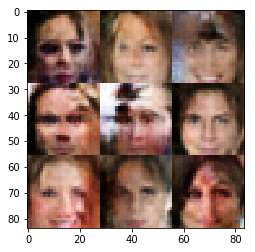

Epoch 1/1... Discriminator Loss: 1.5885... Generator Loss: 0.6976
Epoch 1/1... Discriminator Loss: 1.5409... Generator Loss: 0.6643
Epoch 1/1... Discriminator Loss: 1.3060... Generator Loss: 0.7789
Epoch 1/1... Discriminator Loss: 1.2072... Generator Loss: 1.0386
Epoch 1/1... Discriminator Loss: 1.8038... Generator Loss: 0.7152
Epoch 1/1... Discriminator Loss: 2.4144... Generator Loss: 0.3862
Epoch 1/1... Discriminator Loss: 1.8941... Generator Loss: 0.7144
Epoch 1/1... Discriminator Loss: 0.8769... Generator Loss: 1.1833
Epoch 1/1... Discriminator Loss: 0.9633... Generator Loss: 1.0749
Epoch 1/1... Discriminator Loss: 1.2596... Generator Loss: 0.4162


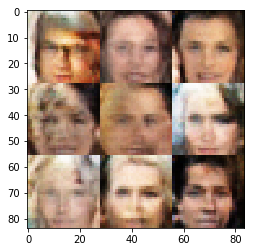

Epoch 1/1... Discriminator Loss: 1.6931... Generator Loss: 0.4574
Epoch 1/1... Discriminator Loss: 1.5329... Generator Loss: 0.6243
Epoch 1/1... Discriminator Loss: 1.6256... Generator Loss: 0.8808
Epoch 1/1... Discriminator Loss: 0.7184... Generator Loss: 2.0879
Epoch 1/1... Discriminator Loss: 1.1054... Generator Loss: 1.3328
Epoch 1/1... Discriminator Loss: 0.5039... Generator Loss: 1.0857
Epoch 1/1... Discriminator Loss: 0.5532... Generator Loss: 0.9634
Epoch 1/1... Discriminator Loss: 0.6683... Generator Loss: 1.0152
Epoch 1/1... Discriminator Loss: 1.5679... Generator Loss: 0.5149
Epoch 1/1... Discriminator Loss: 1.5431... Generator Loss: 0.3903


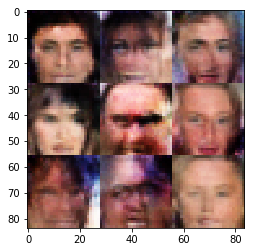

Epoch 1/1... Discriminator Loss: 0.9479... Generator Loss: 2.1403
Epoch 1/1... Discriminator Loss: 1.7322... Generator Loss: 0.5472
Epoch 1/1... Discriminator Loss: 1.0497... Generator Loss: 0.4993
Epoch 1/1... Discriminator Loss: 2.0336... Generator Loss: 0.4979
Epoch 1/1... Discriminator Loss: 1.4719... Generator Loss: 0.6133
Epoch 1/1... Discriminator Loss: 1.7709... Generator Loss: 0.7422
Epoch 1/1... Discriminator Loss: 0.8025... Generator Loss: 1.7485
Epoch 1/1... Discriminator Loss: 1.1089... Generator Loss: 1.1016
Epoch 1/1... Discriminator Loss: 0.8184... Generator Loss: 1.7294
Epoch 1/1... Discriminator Loss: 1.6011... Generator Loss: 0.9943


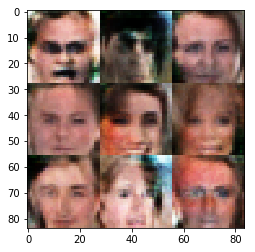

Epoch 1/1... Discriminator Loss: 1.3477... Generator Loss: 1.0058
Epoch 1/1... Discriminator Loss: 0.7279... Generator Loss: 1.8010
Epoch 1/1... Discriminator Loss: 1.4000... Generator Loss: 1.0214
Epoch 1/1... Discriminator Loss: 0.9279... Generator Loss: 1.8372
Epoch 1/1... Discriminator Loss: 1.9217... Generator Loss: 0.6195
Epoch 1/1... Discriminator Loss: 0.8558... Generator Loss: 1.7201
Epoch 1/1... Discriminator Loss: 1.2866... Generator Loss: 1.2498
Epoch 1/1... Discriminator Loss: 1.3856... Generator Loss: 0.7673
Epoch 1/1... Discriminator Loss: 0.8539... Generator Loss: 1.7123
Epoch 1/1... Discriminator Loss: 0.4848... Generator Loss: 1.2262


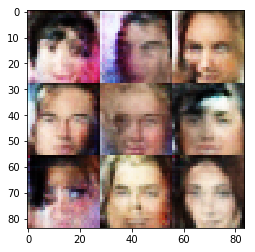

Epoch 1/1... Discriminator Loss: 0.6344... Generator Loss: 1.2905
Epoch 1/1... Discriminator Loss: 2.8469... Generator Loss: 0.2076
Epoch 1/1... Discriminator Loss: 1.0982... Generator Loss: 2.1094
Epoch 1/1... Discriminator Loss: 0.3780... Generator Loss: 2.1393
Epoch 1/1... Discriminator Loss: 1.0197... Generator Loss: 1.4264
Epoch 1/1... Discriminator Loss: 0.7535... Generator Loss: 0.9835
Epoch 1/1... Discriminator Loss: 1.6223... Generator Loss: 0.8642
Epoch 1/1... Discriminator Loss: 1.8108... Generator Loss: 0.4754
Epoch 1/1... Discriminator Loss: 1.4743... Generator Loss: 1.2358
Epoch 1/1... Discriminator Loss: 0.8995... Generator Loss: 1.8939


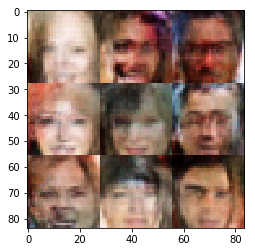

Epoch 1/1... Discriminator Loss: 1.1100... Generator Loss: 0.7191
Epoch 1/1... Discriminator Loss: 0.7780... Generator Loss: 1.8724
Epoch 1/1... Discriminator Loss: 1.5943... Generator Loss: 0.7427
Epoch 1/1... Discriminator Loss: 1.5497... Generator Loss: 1.1043
Epoch 1/1... Discriminator Loss: 1.3017... Generator Loss: 0.7655
Epoch 1/1... Discriminator Loss: 0.9270... Generator Loss: 2.1135
Epoch 1/1... Discriminator Loss: 1.9274... Generator Loss: 1.2587
Epoch 1/1... Discriminator Loss: 1.5158... Generator Loss: 0.7726
Epoch 1/1... Discriminator Loss: 1.1620... Generator Loss: 1.7537
Epoch 1/1... Discriminator Loss: 1.1338... Generator Loss: 1.0749


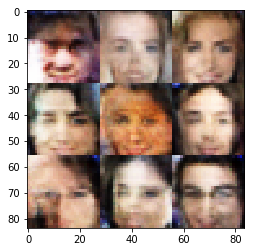

Epoch 1/1... Discriminator Loss: 1.5147... Generator Loss: 0.5479
Epoch 1/1... Discriminator Loss: 0.7664... Generator Loss: 1.3822
Epoch 1/1... Discriminator Loss: 1.6121... Generator Loss: 0.9433
Epoch 1/1... Discriminator Loss: 0.6478... Generator Loss: 1.0946
Epoch 1/1... Discriminator Loss: 1.8493... Generator Loss: 0.6463
Epoch 1/1... Discriminator Loss: 1.2533... Generator Loss: 1.6136
Epoch 1/1... Discriminator Loss: 1.4452... Generator Loss: 0.9395
Epoch 1/1... Discriminator Loss: 0.7477... Generator Loss: 1.4569
Epoch 1/1... Discriminator Loss: 0.6567... Generator Loss: 1.1132
Epoch 1/1... Discriminator Loss: 1.1292... Generator Loss: 1.0276


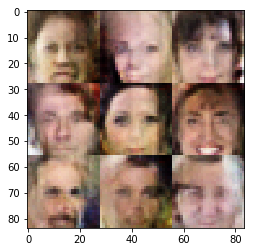

Epoch 1/1... Discriminator Loss: 0.9740... Generator Loss: 1.6727
Epoch 1/1... Discriminator Loss: 1.1393... Generator Loss: 1.2372
Epoch 1/1... Discriminator Loss: 0.4843... Generator Loss: 1.7031
Epoch 1/1... Discriminator Loss: 1.7656... Generator Loss: 0.5272
Epoch 1/1... Discriminator Loss: 1.5654... Generator Loss: 0.6960
Epoch 1/1... Discriminator Loss: 0.7139... Generator Loss: 1.5665
Epoch 1/1... Discriminator Loss: 0.6892... Generator Loss: 1.5576
Epoch 1/1... Discriminator Loss: 2.0214... Generator Loss: 0.5107
Epoch 1/1... Discriminator Loss: 0.9650... Generator Loss: 1.6712
Epoch 1/1... Discriminator Loss: 1.3369... Generator Loss: 0.7354


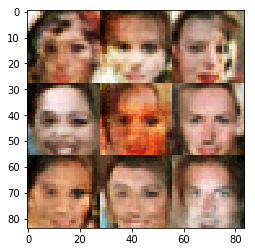

Epoch 1/1... Discriminator Loss: 1.0119... Generator Loss: 0.9840
Epoch 1/1... Discriminator Loss: 1.0787... Generator Loss: 3.2763
Epoch 1/1... Discriminator Loss: 1.8865... Generator Loss: 1.3743
Epoch 1/1... Discriminator Loss: 1.9691... Generator Loss: 0.9442
Epoch 1/1... Discriminator Loss: 1.4458... Generator Loss: 0.3458
Epoch 1/1... Discriminator Loss: 0.9978... Generator Loss: 1.4774
Epoch 1/1... Discriminator Loss: 1.3480... Generator Loss: 0.6130
Epoch 1/1... Discriminator Loss: 1.2229... Generator Loss: 0.9639
Epoch 1/1... Discriminator Loss: 1.6402... Generator Loss: 1.1115
Epoch 1/1... Discriminator Loss: 1.7993... Generator Loss: 0.7588


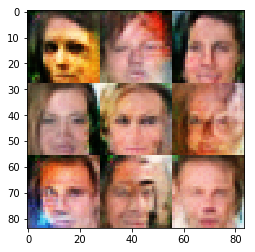

Epoch 1/1... Discriminator Loss: 1.0233... Generator Loss: 1.1800
Epoch 1/1... Discriminator Loss: 1.1129... Generator Loss: 0.9405
Epoch 1/1... Discriminator Loss: 1.0882... Generator Loss: 1.1111
Epoch 1/1... Discriminator Loss: 1.8636... Generator Loss: 1.4250
Epoch 1/1... Discriminator Loss: 0.9463... Generator Loss: 1.0936
Epoch 1/1... Discriminator Loss: 2.0676... Generator Loss: 0.9689
Epoch 1/1... Discriminator Loss: 1.5487... Generator Loss: 0.6678
Epoch 1/1... Discriminator Loss: 1.1472... Generator Loss: 0.5436
Epoch 1/1... Discriminator Loss: 1.0511... Generator Loss: 0.5243
Epoch 1/1... Discriminator Loss: 1.7893... Generator Loss: 0.5080


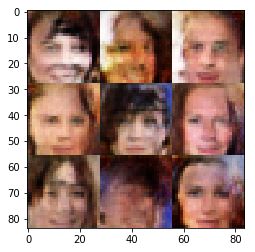

Epoch 1/1... Discriminator Loss: 0.9616... Generator Loss: 1.3102
Epoch 1/1... Discriminator Loss: 1.3456... Generator Loss: 1.3765
Epoch 1/1... Discriminator Loss: 1.3404... Generator Loss: 0.8142
Epoch 1/1... Discriminator Loss: 0.6162... Generator Loss: 0.8070
Epoch 1/1... Discriminator Loss: 1.3088... Generator Loss: 0.7058
Epoch 1/1... Discriminator Loss: 1.8044... Generator Loss: 0.8601
Epoch 1/1... Discriminator Loss: 1.3200... Generator Loss: 2.3923
Epoch 1/1... Discriminator Loss: 2.0696... Generator Loss: 0.9946
Epoch 1/1... Discriminator Loss: 0.9696... Generator Loss: 2.5337
Epoch 1/1... Discriminator Loss: 1.2370... Generator Loss: 1.8226


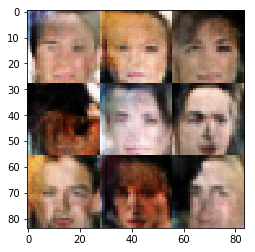

Epoch 1/1... Discriminator Loss: 0.7727... Generator Loss: 1.5801
Epoch 1/1... Discriminator Loss: 1.7635... Generator Loss: 0.5575
Epoch 1/1... Discriminator Loss: 1.0252... Generator Loss: 1.2130
Epoch 1/1... Discriminator Loss: 0.6449... Generator Loss: 1.1156
Epoch 1/1... Discriminator Loss: 1.7537... Generator Loss: 0.9184
Epoch 1/1... Discriminator Loss: 0.8659... Generator Loss: 0.8896
Epoch 1/1... Discriminator Loss: 1.0541... Generator Loss: 0.7346
Epoch 1/1... Discriminator Loss: 1.4845... Generator Loss: 0.7705
Epoch 1/1... Discriminator Loss: 1.6771... Generator Loss: 0.7871
Epoch 1/1... Discriminator Loss: 1.1160... Generator Loss: 0.6483


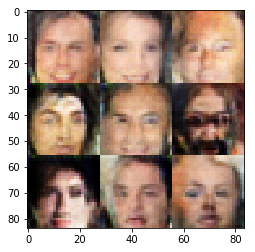

Epoch 1/1... Discriminator Loss: 1.1975... Generator Loss: 0.4353
Epoch 1/1... Discriminator Loss: 1.0981... Generator Loss: 1.3043
Epoch 1/1... Discriminator Loss: 1.5410... Generator Loss: 0.5315
Epoch 1/1... Discriminator Loss: 0.9522... Generator Loss: 1.4220
Epoch 1/1... Discriminator Loss: 1.1585... Generator Loss: 0.8395
Epoch 1/1... Discriminator Loss: 1.8729... Generator Loss: 0.8999
Epoch 1/1... Discriminator Loss: 1.1660... Generator Loss: 0.7266
Epoch 1/1... Discriminator Loss: 1.0242... Generator Loss: 0.8623
Epoch 1/1... Discriminator Loss: 1.7832... Generator Loss: 0.4033
Epoch 1/1... Discriminator Loss: 1.5169... Generator Loss: 0.4977


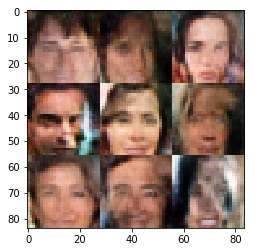

Epoch 1/1... Discriminator Loss: 1.0652... Generator Loss: 1.5743
Epoch 1/1... Discriminator Loss: 0.6245... Generator Loss: 0.9132
Epoch 1/1... Discriminator Loss: 1.3026... Generator Loss: 0.8669
Epoch 1/1... Discriminator Loss: 1.8328... Generator Loss: 0.6109
Epoch 1/1... Discriminator Loss: 1.2747... Generator Loss: 0.4092
Epoch 1/1... Discriminator Loss: 1.1045... Generator Loss: 1.3980
Epoch 1/1... Discriminator Loss: 0.9328... Generator Loss: 0.6029
Epoch 1/1... Discriminator Loss: 0.8738... Generator Loss: 1.2924
Epoch 1/1... Discriminator Loss: 0.9141... Generator Loss: 1.0565
Epoch 1/1... Discriminator Loss: 1.1871... Generator Loss: 0.6616


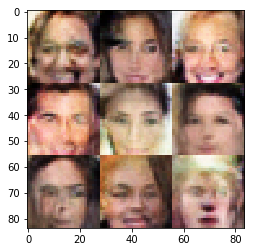

Epoch 1/1... Discriminator Loss: 1.0285... Generator Loss: 1.0529
Epoch 1/1... Discriminator Loss: 1.5827... Generator Loss: 0.7582
Epoch 1/1... Discriminator Loss: 0.9023... Generator Loss: 0.9528
Epoch 1/1... Discriminator Loss: 1.2542... Generator Loss: 1.1825
Epoch 1/1... Discriminator Loss: 1.2209... Generator Loss: 0.4276
Epoch 1/1... Discriminator Loss: 1.1550... Generator Loss: 1.0066
Epoch 1/1... Discriminator Loss: 0.7517... Generator Loss: 1.2640
Epoch 1/1... Discriminator Loss: 0.9540... Generator Loss: 1.0243
Epoch 1/1... Discriminator Loss: 1.8782... Generator Loss: 0.8694
Epoch 1/1... Discriminator Loss: 1.7825... Generator Loss: 0.3834


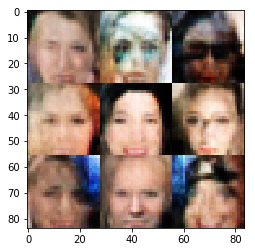

Epoch 1/1... Discriminator Loss: 2.4646... Generator Loss: 0.5752
Epoch 1/1... Discriminator Loss: 1.3440... Generator Loss: 0.7264
Epoch 1/1... Discriminator Loss: 1.5391... Generator Loss: 0.7106
Epoch 1/1... Discriminator Loss: 1.3807... Generator Loss: 0.7837
Epoch 1/1... Discriminator Loss: 1.0751... Generator Loss: 1.2615
Epoch 1/1... Discriminator Loss: 2.0659... Generator Loss: 0.3843
Epoch 1/1... Discriminator Loss: 0.5276... Generator Loss: 1.7672
Epoch 1/1... Discriminator Loss: 0.9094... Generator Loss: 1.1852
Epoch 1/1... Discriminator Loss: 1.6993... Generator Loss: 0.4822
Epoch 1/1... Discriminator Loss: 1.2772... Generator Loss: 0.7937


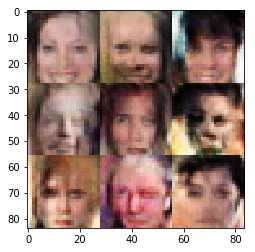

Epoch 1/1... Discriminator Loss: 1.2387... Generator Loss: 0.7486
Epoch 1/1... Discriminator Loss: 0.8762... Generator Loss: 1.1789
Epoch 1/1... Discriminator Loss: 1.3275... Generator Loss: 1.4009
Epoch 1/1... Discriminator Loss: 1.2881... Generator Loss: 1.3392
Epoch 1/1... Discriminator Loss: 0.7744... Generator Loss: 1.0183
Epoch 1/1... Discriminator Loss: 0.6654... Generator Loss: 1.0105
Epoch 1/1... Discriminator Loss: 1.0492... Generator Loss: 0.7675
Epoch 1/1... Discriminator Loss: 1.3698... Generator Loss: 0.4484
Epoch 1/1... Discriminator Loss: 2.1331... Generator Loss: 0.1335
Epoch 1/1... Discriminator Loss: 1.3989... Generator Loss: 0.9939


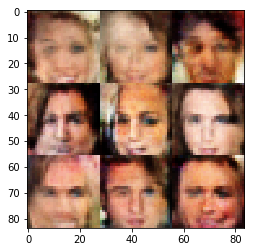

Epoch 1/1... Discriminator Loss: 0.7102... Generator Loss: 1.4932
Epoch 1/1... Discriminator Loss: 1.8565... Generator Loss: 0.3486
Epoch 1/1... Discriminator Loss: 1.3673... Generator Loss: 0.8847
Epoch 1/1... Discriminator Loss: 1.8225... Generator Loss: 0.7600
Epoch 1/1... Discriminator Loss: 1.0811... Generator Loss: 0.6021
Epoch 1/1... Discriminator Loss: 1.5001... Generator Loss: 0.5042
Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 0.5110
Epoch 1/1... Discriminator Loss: 0.7467... Generator Loss: 0.6604
Epoch 1/1... Discriminator Loss: 1.1435... Generator Loss: 1.2754
Epoch 1/1... Discriminator Loss: 1.5428... Generator Loss: 0.4574


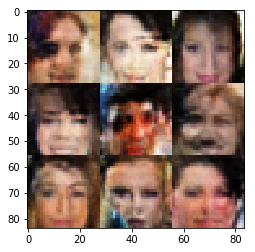

Epoch 1/1... Discriminator Loss: 1.6446... Generator Loss: 1.0493
Epoch 1/1... Discriminator Loss: 0.8688... Generator Loss: 1.5021
Epoch 1/1... Discriminator Loss: 0.5734... Generator Loss: 0.9926
Epoch 1/1... Discriminator Loss: 1.0659... Generator Loss: 1.0291
Epoch 1/1... Discriminator Loss: 1.0473... Generator Loss: 2.3568
Epoch 1/1... Discriminator Loss: 0.5488... Generator Loss: 1.8804
Epoch 1/1... Discriminator Loss: 1.8527... Generator Loss: 0.7334
Epoch 1/1... Discriminator Loss: 1.1216... Generator Loss: 0.4698
Epoch 1/1... Discriminator Loss: 1.1962... Generator Loss: 0.9401
Epoch 1/1... Discriminator Loss: 1.4262... Generator Loss: 1.1355


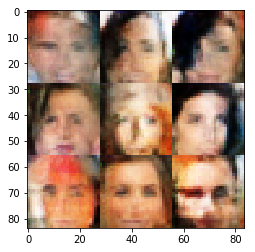

Epoch 1/1... Discriminator Loss: 0.6933... Generator Loss: 1.5146
Epoch 1/1... Discriminator Loss: 0.6124... Generator Loss: 0.9324
Epoch 1/1... Discriminator Loss: 1.6017... Generator Loss: 0.7388
Epoch 1/1... Discriminator Loss: 1.0185... Generator Loss: 1.5077
Epoch 1/1... Discriminator Loss: 1.3129... Generator Loss: 0.6351
Epoch 1/1... Discriminator Loss: 1.8911... Generator Loss: 0.7727


In [14]:
batch_size = 16
z_dim = 200s
learning_rate = 0.0004
beta1 = 0.3

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.